_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*FILL IN YOUR NAMES HERE* </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

In [20]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black

jupyter_black.load()

## Context
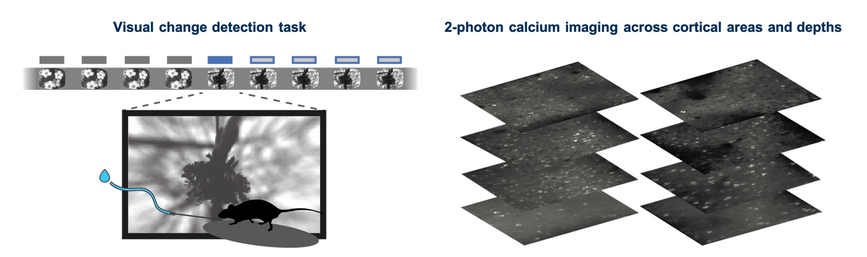

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

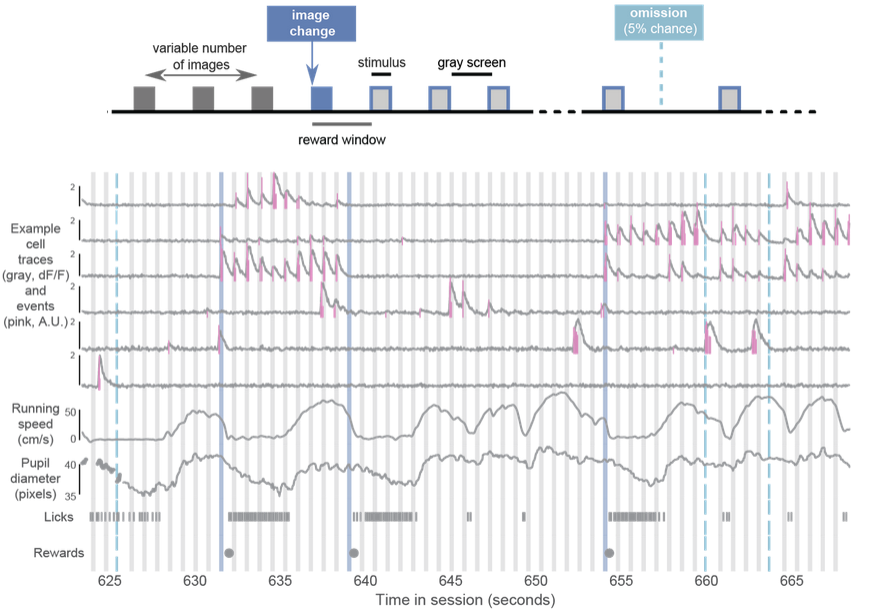

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the stimulus frames
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a locally sparse noise stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [21]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_rf.npz", allow_pickle=True)
    data = dict(data)
    array2df(data, "stim_table", ["frame", "start", "end"])
    array2df(data, "stim_epoch_table", ["start", "end", "stimulus"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (105968,)
[dff] - <class 'numpy.ndarray'>, - (189, 105968)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (8880, 3)
[stim] - <class 'numpy.ndarray'>, - (9000, 16, 28)
[roi_masks] - <class 'numpy.ndarray'>, - (189, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 105968)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure on the location of the receptive fields?** 

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

In [22]:
print(f"Number of samples: {data['t'].shape[0]}")
# Deduced sampling rate
sampling_rate = 1 / np.mean(np.diff(data["t"]))
print(f"Deduced sampling rate: {sampling_rate} Hz")

Number of samples: 105968
Deduced sampling rate: 30.144897456157487 Hz


In [23]:
def neuron_signal_segment(neuron_idx, start_t, end_t, sampling_rate):
    # DEFINE SEGMENT & TIME VECTOR
    sr_new = int(sampling_rate)  # Hz after downsampling
    start_idx = start_t * sr_new
    end_idx = end_t * sr_new
    time = np.linspace(start_t, end_t, end_idx - start_idx, endpoint=False)
    cell_gcamp = neuron_idx
    gcamp_cal_seg = data["dff"][cell_gcamp, start_idx:end_idx]
    return time, gcamp_cal_seg

In [24]:
from scipy.signal import butter, filtfilt, savgol_filter


def process_neuron_signal(neuron_cal_segment, sampling_rate):
    # PARAMETERS
    fs = int(sampling_rate)  # Hz (after downsampling)
    hp_cutoff = 0.01  # Hz, to remove very slow drifts
    savgol_window = 21  # samples (~0.6 s window)
    savgol_poly = 2  # quadratic fit for Savitzky–Golay

    def preprocess_calcium(data):
        # High-pass Butterworth filter
        b, a = butter(N=4, Wn=hp_cutoff / (fs / 2), btype="highpass")
        filtered = filtfilt(b, a, data, axis=0)

        # Savitzky–Golay filter
        smoothed = savgol_filter(
            filtered, window_length=savgol_window, polyorder=savgol_poly, axis=0
        )
        return smoothed

    gcamp_cal_filt = preprocess_calcium(neuron_cal_segment)

    return gcamp_cal_filt

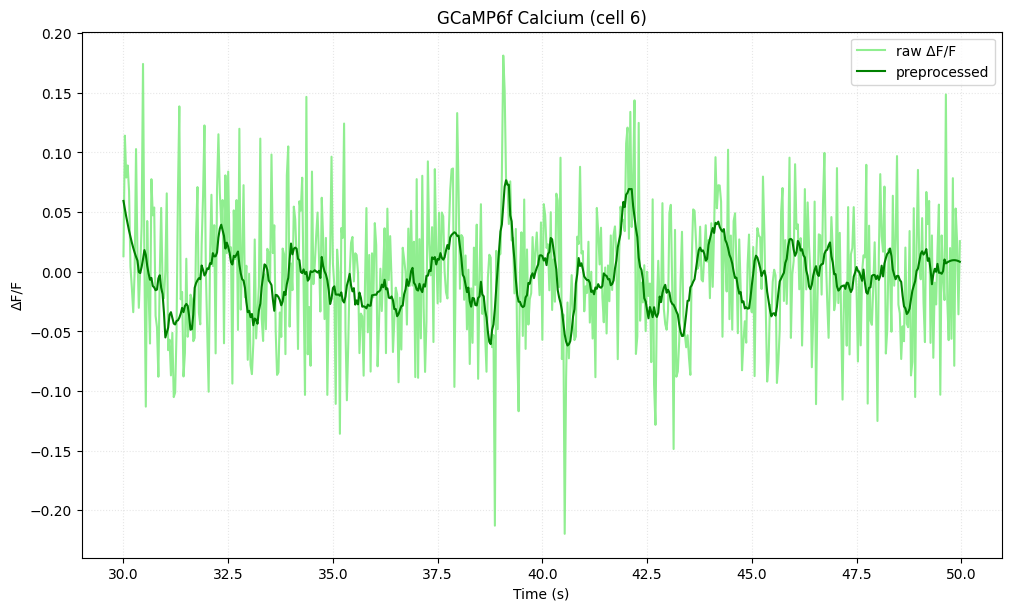

In [25]:
import matplotlib.pyplot as plt

time, gcamp_cal_seg = neuron_signal_segment(6, 30, 50, sampling_rate)
gcamp_cal_filt = process_neuron_signal(gcamp_cal_seg, sampling_rate)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), constrained_layout=True)

# GCaMP6f panel
axs.plot(time, gcamp_cal_seg, color="lightgreen", label="raw ΔF/F")
axs.plot(time, gcamp_cal_filt, color="green", label="preprocessed")
axs.set_title("GCaMP6f Calcium (cell 6)")
axs.set_xlabel("Time (s)")
axs.set_ylabel("ΔF/F")
axs.legend()
axs.grid(alpha=0.3, linestyle=":")

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


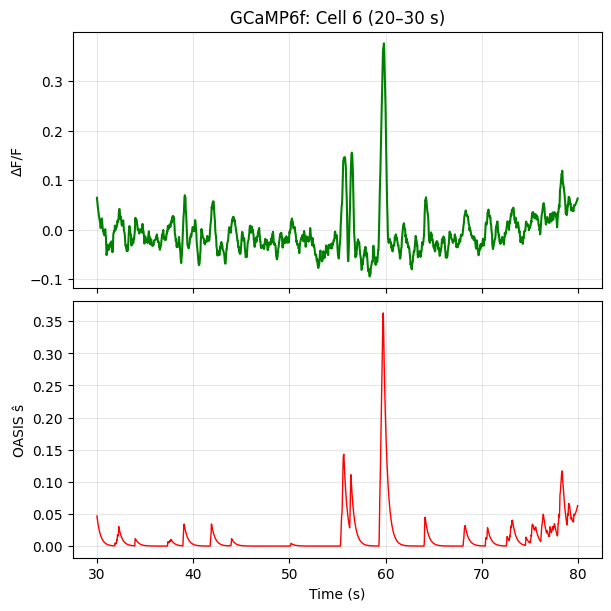

In [26]:
import oasis.functions


# Define a simple Oasis wrapper
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = oasis.functions.deconvolve(trace, penalty=penalty, optimize_g=False)
    return s


time, gcamp_cal_seg = neuron_signal_segment(6, 30, 80, sampling_rate)
gcamp_cal_filt = process_neuron_signal(gcamp_cal_seg, sampling_rate)

# Parameters and indices
fs = sampling_rate  # Sampling rate after down-sampling (Hz)


c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
    gcamp_cal_filt, penalty=1.0, optimize_g=False
)


# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, gcamp_cal_filt, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")

# ← same change here
axs[1].plot(time, c_oasis_gcamp_cal_seg, color="red", linewidth=1)
axs[1].set_ylabel("OASIS ŝ")
axs[1].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],


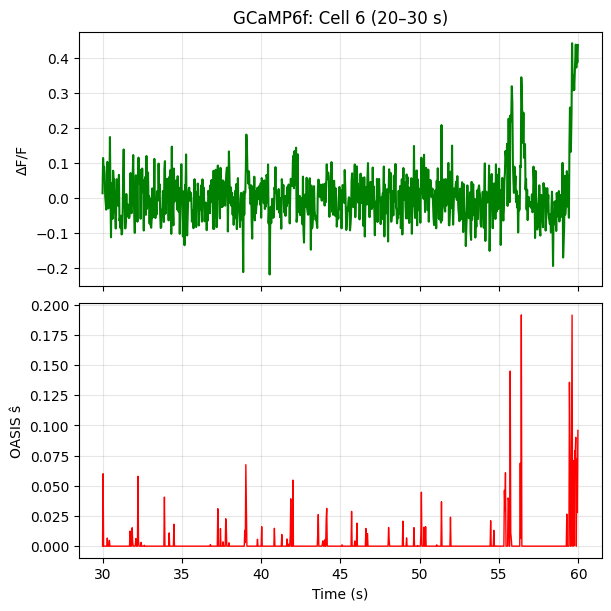

In [27]:
import oasis.functions


# Define a simple Oasis wrapper
def run_oasis(trace, penalty=1.0):
    _, s, _, _, _ = oasis.functions.deconvolve(trace, penalty=penalty, optimize_g=False)
    return s


time, gcamp_cal_seg = neuron_signal_segment(6, 30, 60, sampling_rate)

# Parameters and indices
fs = sampling_rate  # Sampling rate after down-sampling (Hz)

c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
    gcamp_cal_seg, penalty=1.0, optimize_g=False
)

# Plot GCaMP6f results (3×1)
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, constrained_layout=True)
axs[0].plot(time, gcamp_cal_seg, color="green")
axs[0].set_ylabel("ΔF/F")
axs[0].set_title("GCaMP6f: Cell 6 (20–30 s)")

# ← same change here
axs[1].plot(time, s_oasis_gcamp_cal_seg, color="red", linewidth=1)
axs[1].set_ylabel("OASIS ŝ")
axs[1].set_xlabel("Time (s)")

for ax in axs:
    ax.grid(alpha=0.3)
plt.show()

In [28]:
# Run Oasis on the on raw calcium signal for all neurons
# use tqdm  to show progress
from tqdm import tqdm

oasis_results = np.empty((data["dff"].shape[0], data["dff"].shape[1]), dtype=object)
for neuron_idx in tqdm(range(data["dff"].shape[0]), desc="Processing neurons"):
    neuron_cal_signal = data["dff"][neuron_idx, :]
    # Run Oasis on the filtered signal
    c_oasis_gcamp_cal_seg, s_oasis_gcamp_cal_seg, *_ = oasis.functions.deconvolve(
        neuron_cal_signal, penalty=1.0, optimize_g=False
    )

    # Store results in data dictionary
    oasis_results[neuron_idx] = np.array(s_oasis_gcamp_cal_seg)

# Save the processed data

Processing neurons:   0%|          | 0/189 [00:00<?, ?it/s]/home/andi/anaconda3/envs/calcium-env/lib/python3.11/site-packages/oasis/functions.py:817: FutureWarning: Beginning in SciPy 1.17, multidimensional input will be treated as a batch, not `ravel`ed. To preserve the existing behavior and silence this warning, `ravel` arguments before passing them to `toeplitz`.
  A = scipy.linalg.toeplitz(xc[np.arange(lags)],
Processing neurons: 100%|██████████| 189/189 [00:27<00:00,  6.92it/s]


In [29]:
# --- Phase 3: Tuning Function Fitting ---
# Goal: Load the outputs from the previous notebooks (00 & 02) and use them
# to estimate the receptive field (RF) for each neuron.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as U
import importlib
import os
import glob

# Reload utils to ensure you're using the latest version of your functions
importlib.reload(U)

print("Starting Phase 3: Tuning Function Fitting...")

# --- Step 1: Load Inputs from Saved Files ---

try:
    # ACTION: Change 'aakarsh' to your namespace if needed.
    namespace = "aakarsh"

    # --- Load the latest output from the preprocessing notebook (00-background.ipynb) ---
    background_dir = f"data/{namespace}/background/"
    list_of_background_files = glob.glob(os.path.join(background_dir, "*.npz"))
    if not list_of_background_files:
        raise FileNotFoundError(f"No background data files found in '{background_dir}'")

    latest_background_file = max(list_of_background_files, key=os.path.getctime)
    print(f"Loading latest background data from: {latest_background_file}")

    stim_data = np.load(latest_background_file, allow_pickle=True)
    stim_filtered = stim_data["stim_filtered"]
    stim_table_filtered_df = pd.DataFrame(
        stim_data["stim_table_filtered"], columns=stim_data["stim_table_columns"]
    )

    # --- Load the latest output from the spike inference notebook (02-spike-inference.ipynb) ---
    spike_inference_dir = f"data/{namespace}/preprocessed/"
    list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, "*.npz"))
    if not list_of_spike_files:
        raise FileNotFoundError(
            f"No spike inference files found in '{spike_inference_dir}'"
        )

    latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
    print(f"Loading latest spike inference data from: {latest_spike_file}")

    spike_data = np.load(latest_spike_file, allow_pickle=True)
    print(spike_data.keys())

    inferred_spikes = spike_data["spike_counts"]
    time_vector = spike_data["time_vector"]
    sampling_rate = spike_data["sampling_frequency"]

    data = U.load_data()  # Load the latest spike inference data
    data = U.preprocess_data(data)  # Preprocess the data

except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary input file: {e}")
    print(
        "Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly."
    )
    raise

Starting Phase 3: Tuning Function Fitting...
Loading latest background data from: data/aakarsh/background/cleaned_2025_07_16_17_35_52.npz
Loading latest spike inference data from: data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz
KeysView(NpzFile 'data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz' with keys: processed_neuron_signal, spike_counts, thresholds, sampling_frequency, time_vector)
Performing initial data preprocessing...
Preprocessing complete.


In [30]:
active_stim_per_timestep = U.get_active_stimulus_per_timestep(
    data["stim_table"], total_timesteps=len(data["t"])
)

Mapping active stimulus frame to each timestep...
Mapping complete.


In [31]:
importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions
inferred_spikes = spike_data["spike_counts"]
# binned_spikes.shape, presented_frame_ids.shape
binned_spikes, presented_frame_ids = (
    inferred_spikes,
    active_stim_per_timestep,
)  # stimulus data is already binned.
# \ U.bin_spikes_to_frames_from_active_stim_per_timestep(inferred_spikes, active_stim_per_timestep)

In [32]:
# Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
binned_spikes = binned_spikes[:, presented_frame_ids != -1]
presented_frame_ids = presented_frame_ids[presented_frame_ids != -1]
print(
    f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}"
)

binned_spikes.shape: (189, 62521), presented_frame_ids.shape: (62521,)


In [33]:
assert (
    np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0
), "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [34]:
# Prepare the stimulus matrix from the presented frame IDs
importlib.reload(
    U
)  # Reload utils to ensure you're using the latest version of your functions

flattened_stim, stim_h, stim_w = U.prepare_stimulus_matrix_from_ids(
    presented_frame_ids, full_stim_movie=data["stim"]
)

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 62521)


In [35]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert (
    flattened_on_stimuli.shape == flattened_stim.shape
), "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert (
    flattened_off_stimuli.shape == flattened_stim.shape
), "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Flattened Stimulus Shape: (448, 62521)
Flattened On Stimuli Shape: (448, 62521)
Flattened Off Stimuli Shape: (448, 62521)

Assertions passed! The shapes are now correct.


In [40]:
from rfest import splineLNP
from rfest import build_design_matrix
from tqdm import tqdm


w_est_spline_coeffs = []

selected_neurons = range(binned_spikes.shape[0])  # Select all neurons for fitting
# selected_neurons = [32]
for neuron_idx in tqdm(selected_neurons, desc="Fitting neurons"):
    neuron_to_fit = neuron_idx
    print(f"binned_spikes.shape: {binned_spikes.shape}")
    neuron_binned_spikes = binned_spikes[neuron_to_fit, :]
    flattened_stim_for_rfest = flattened_on_stimuli.copy()
    print(f"flattened_stim_for_rfest.shape: {flattened_stim_for_rfest.shape}")
    num_lags = 10  # Number of lags to consider for the GLM
    dims = (num_lags, stim_h, stim_w)
    print(f"dims: {dims}")
    df = (8, 8, 12)  # (time, height, width)

    X_design = build_design_matrix(flattened_stim_for_rfest.T, nlag=num_lags)
    # Remove the first num_lags-1 entries from the binned spikes to match the response length
    y_response = np.array(neuron_binned_spikes)
    y_response = y_response.astype(np.float64)

    print(f"X_design.shape: {X_design.shape}")

    print(f"X_design.shape: {X_design.shape}")
    print(f"y_response.shape: {y_response.shape}")
    model = splineLNP(X_design, y_response, dims=dims, df=df)
    print(
        f"Model initialized for Neuron {neuron_to_fit} with dims: {dims} and df: {df}"
    )
    # Fit the model. This performs the optimization.
    print(f"Fitting splineLNP model for Neuron {neuron_to_fit}...")
    model.fit(beta=0.01, num_iters=200, verbose=10)

    # The estimated receptive field is stored in model.w_opt
    w_est_spline = model.w_opt
    w_est_spline_coeffs.append(w_est_spline)
    print(f"\n Neuron {neuron_to_fit} Fitting complete!")

Fitting neurons:   0%|          | 0/189 [00:00<?, ?it/s]

binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 0 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 0...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.787        43767.422       
10           5.306        35241.449       
20           5.874        28735.479       
30           6.388        24014.135       
40           6.899        20711.468       
50           7.395        18456.949       
60           7.904        16945.300       
70           8.415        15951.270       
80           8.912        15316.757       
90           9.416        14931.195       
100          10.240       14714.675       
110          10.801       14606.826       
120          11.344       14561.738       
130          11.867       14547.085       
140          12.399     

Fitting neurons:   1%|          | 1/189 [00:29<1:32:44, 29.60s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 0 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 1 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 1...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.634        43551.398       
10           5.148        34883.619       
20           5.671        28226.362       
30           6.189        23348.358       
40           6.710        19889.890       
50           7.231        17486.171       
60           7.750        15836.075       
70           8.263        14717.266       
80           8.777        13974.185       
90           9.572        13499.002       
100          10.087       13214.430       
110          10.587       13

Fitting neurons:   1%|          | 2/189 [00:58<1:30:21, 28.99s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 1 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 2 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 2...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.653        43358.030       
10           5.172        34562.226       
20           5.702        27768.285       
30           6.238        22748.404       
40           6.797        19148.110       
50           7.366        16607.349       
60           7.949        14828.264       
70           8.579        13590.664       
80           9.180        12740.890       
90           9.733        12173.571       
100          10.659       11814.655       
110          11.308       11

Fitting neurons:   2%|▏         | 3/189 [01:26<1:28:54, 28.68s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 2 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 3 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 3...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.483        43965.381       
10           5.241        35569.610       
20           5.914        29202.441       
30           6.538        24624.403       
40           7.118        21463.346       
50           7.642        19342.948       
60           8.155        17953.635       
70           8.687        17067.107       
80           9.235        16522.803       
90           9.805        16208.081       
100          10.307       16041.945       
110          10.800       15

Fitting neurons:   2%|▏         | 4/189 [01:54<1:27:14, 28.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 3 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 4 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 4...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.364        43762.912       
10           5.308        35235.164       
20           5.872        28727.298       
30           6.419        24003.945       
40           6.941        20699.187       
50           7.456        18442.542       
60           7.984        16928.782       
70           8.534        15932.721       
80           9.083        15296.337       
90           9.645        14909.160       
100          10.196       14691.372       
110          10.792       14

Fitting neurons:   3%|▎         | 5/189 [02:23<1:27:38, 28.58s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 4 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 5 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 5...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.478        43427.116       
10           5.248        34675.865       
20           5.835        27929.513       
30           6.433        22959.122       
40           7.009        19408.482       
50           7.601        16915.973       
60           8.187        15182.665       
70           8.776        13987.668       
80           9.394        13176.682       
90           9.988        12643.445       
100          10.591       12312.631       
110          11.177       12

Fitting neurons:   3%|▎         | 6/189 [02:52<1:27:41, 28.75s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 5 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 6 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 6...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.348        43642.485       
10           5.206        35030.548       
20           5.774        28432.887       
30           6.296        23616.798       
40           6.807        20220.319       
50           7.332        17876.563       
60           7.837        16282.853       
70           8.355        15215.702       
80           8.888        14518.449       
90           9.402        14081.953       
100          9.906        13827.503       
110          10.417       13

Fitting neurons:   4%|▎         | 7/189 [03:19<1:25:43, 28.26s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 6 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 7 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 7...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.644        43601.367       
10           5.191        34969.069       
20           5.716        28349.672       
30           6.228        23510.805       
40           7.057        20091.123       
50           7.665        17724.378       
60           8.206        16108.429       
70           8.720        15020.293       
80           9.282        14303.893       
90           9.845        13850.828       
100          10.394       13583.204       
110          10.924       13

Fitting neurons:   4%|▍         | 8/189 [03:47<1:25:09, 28.23s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 7 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 8 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 8...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.600        44189.704       
10           5.121        35942.162       
20           5.630        29732.881       
30           6.151        25317.325       
40           6.663        22315.692       
50           7.211        20344.459       
60           8.037        19088.668       
70           8.608        18316.274       
80           9.112        17864.096       
90           9.623        17618.031       
100          10.102       17497.579       
110          10.592       17

Fitting neurons:   5%|▍         | 9/189 [04:15<1:23:48, 27.94s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 8 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 9 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 9...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.613        44262.697       
10           5.178        36065.161       
20           5.713        29909.108       
30           6.277        25548.135       
40           6.836        22599.664       
50           7.337        20677.575       
60           7.863        19465.004       
70           8.723        18728.664       
80           9.279        18304.653       
90           9.752        18078.719       
100          10.247       17970.991       
110          10.731       17

Fitting neurons:   5%|▌         | 10/189 [04:42<1:22:59, 27.82s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 9 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 10 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 10...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.779        43447.686       
10           5.332        34711.096       
20           5.866        27980.376       
30           6.436        23026.153       
40           6.949        19491.572       
50           7.479        17014.439       
60           7.991        15295.436       
70           8.520        14113.434       
80           9.008        13313.948       
90           9.604        12790.487       
100          10.429       12467.422       
110          10.964       

Fitting neurons:   6%|▌         | 11/189 [05:10<1:22:43, 27.88s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 10 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 11 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 11...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.573        43497.765       
10           5.159        34794.571       
20           5.763        28099.513       
30           6.308        23182.307       
40           6.830        19684.726       
50           7.395        17243.341       
60           7.930        15557.978       
70           8.449        14406.945       
80           8.970        13635.253       
90           9.499        13135.768       
100          10.068       12832.034       
110          10.574      

Fitting neurons:   6%|▋         | 12/189 [05:37<1:21:12, 27.53s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 11 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 12 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 12...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.550        44109.723       
10           5.092        35810.753       
20           5.563        29546.707       
30           6.146        25074.799       
40           6.968        22017.900       
50           7.553        19995.035       
60           8.105        18693.179       
70           8.653        17881.656       
80           9.195        17398.224       
90           9.741        17129.234       
100          10.305       16993.860       
110          10.872      

Fitting neurons:   7%|▋         | 13/189 [06:04<1:20:33, 27.46s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 12 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 13 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 13...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.523        43161.080       
10           5.085        34234.674       
20           5.650        27301.209       
30           6.211        22136.164       
40           6.764        18390.021       
50           7.488        15707.104       
60           8.215        13792.398       
70           8.814        12427.349       
80           9.336        11459.658       
90           9.848        10786.065       
100          10.382       10336.167       
110          10.902      

Fitting neurons:   7%|▋         | 14/189 [06:31<1:19:35, 27.29s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 13 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 14 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 14...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.440        43095.695       
10           4.921        34127.096       
20           5.421        27148.533       
30           5.947        21936.450       
40           6.489        18142.803       
50           6.974        15413.194       
60           7.461        13453.398       
70           8.310        12045.252       
80           8.877        11036.745       
90           9.391        10325.168       
100          9.885        9841.314        
110          10.402      

Fitting neurons:   8%|▊         | 15/189 [06:57<1:17:55, 26.87s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 14 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 15 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 15...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.391        43838.833       
10           4.916        35358.064       
20           5.422        28900.292       
30           5.950        24228.817       
40           6.456        20975.653       
50           6.944        18768.354       
60           7.455        17300.200       
70           7.939        16344.879       
80           8.472        15743.367       
90           8.949        15384.224       
100          9.428        15186.921       
110          10.281      

Fitting neurons:   8%|▊         | 16/189 [07:23<1:16:41, 26.60s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 15 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 16 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 16...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.383        44244.927       
10           5.297        36033.468       
20           5.946        29862.583       
30           6.520        25486.452       
40           7.098        22523.329       
50           7.679        20587.843       
60           8.290        19363.648       
70           8.901        18617.750       
80           9.497        18186.369       
90           10.098       17955.210       
100          10.686       17844.164       
110          11.245      

Fitting neurons:   9%|▉         | 17/189 [07:51<1:17:24, 27.00s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 16 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 17 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 17...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.601        42999.951       
10           5.158        33969.830       
20           5.699        26925.494       
30           6.575        21644.736       
40           7.188        17781.577       
50           7.741        14983.389       
60           8.270        12956.986       
70           8.801        11484.641       
80           9.442        10414.579       
90           10.053       9644.684        
100          10.600       9107.334        
110          11.120      

Fitting neurons:  10%|▉         | 18/189 [08:18<1:17:05, 27.05s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 17 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 18 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 18...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.465        43892.657       
10           4.970        35453.168       
20           5.477        29039.420       
30           5.978        24413.198       
40           6.469        21204.329       
50           6.966        19038.405       
60           7.676        17607.350       
70           8.305        16684.014       
80           8.821        16108.833       
90           9.310        15770.007       
100          9.776        15586.948       
110          10.246      

Fitting neurons:  10%|█         | 19/189 [08:44<1:15:26, 26.62s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 18 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 19 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 19...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.371        44070.101       
10           4.866        35741.915       
20           5.363        29446.765       
30           5.833        24942.975       
40           6.318        21855.032       
50           6.796        19803.438       
60           7.254        18476.215       
70           7.718        17643.340       
80           8.511        17142.951       
90           9.089        16861.527       
100          9.622        16718.007       
110          10.164      

Fitting neurons:  11%|█         | 20/189 [09:09<1:14:17, 26.37s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 19 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 20 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 20...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.632        44179.326       
10           5.181        35920.484       
20           5.718        29699.155       
30           6.272        25271.351       
40           6.843        22258.008       
50           7.421        20276.226       
60           8.001        19011.423       
70           8.572        18231.708       
80           9.151        17773.888       
90           9.724        17523.731       
100          10.634       17400.504       
110          11.275      

Fitting neurons:  11%|█         | 21/189 [09:37<1:14:31, 26.62s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 20 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 21 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 21...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.566        43666.978       
10           5.136        35076.900       
20           5.686        28502.549       
30           6.188        23710.380       
40           6.729        20337.250       
50           7.303        18015.248       
60           7.881        16441.029       
70           8.414        15390.750       
80           8.929        14707.556       
90           9.410        14282.176       
100          9.898        14035.829       
110          10.384      

Fitting neurons:  12%|█▏        | 22/189 [10:04<1:14:34, 26.79s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 21 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 22 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 22...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.439        43980.550       
10           4.981        35597.475       
20           5.804        29243.846       
30           6.416        24679.661       
40           6.951        21532.023       
50           7.460        19423.951       
60           7.999        18045.431       
70           8.543        17167.913       
80           9.077        16630.724       
90           9.610        16321.194       
100          10.150       16158.424       
110          10.655      

Fitting neurons:  12%|█▏        | 23/189 [10:30<1:13:33, 26.59s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 22 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 23 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 23...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.649        43089.117       
10           5.133        34116.440       
20           5.629        27133.517       
30           6.137        21916.880       
40           6.672        18118.619       
50           7.520        15384.455       
60           8.067        13420.235       
70           8.571        12007.831       
80           9.060        10995.256       
90           9.556        10279.855       
100          10.050       9792.541        
110          10.555      

Fitting neurons:  13%|█▎        | 24/189 [10:57<1:13:19, 26.66s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 23 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 24 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 24...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.711        43141.775       
10           5.202        34205.246       
20           5.670        27260.958       
30           6.153        22084.524       
40           6.633        18326.670       
50           7.118        15631.936       
60           7.920        13705.448       
70           8.447        12328.741       
80           8.940        11349.620       
90           9.418        10665.050       
100          9.878        10205.071       
110          10.340      

Fitting neurons:  13%|█▎        | 25/189 [11:23<1:12:55, 26.68s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 24 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 25 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 25...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.610        43734.841       
10           5.117        35187.755       
20           5.636        28659.279       
30           6.127        23914.658       
40           6.645        20588.884       
50           7.154        18312.309       
60           7.693        16780.301       
70           8.219        15768.077       
80           8.784        15117.939       
90           9.664        14719.717       
100          10.252       14493.821       
110          10.769      

Fitting neurons:  14%|█▍        | 26/189 [11:50<1:12:32, 26.70s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 25 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 26 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 26...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.119        43557.575       
10           4.563        34893.284       
20           5.006        28239.741       
30           5.444        23365.607       
40           5.878        19911.047       
50           6.315        17511.161       
60           6.750        15864.735       
70           7.186        14749.360       
80           7.630        14009.400       
90           8.070        13536.923       
100          8.506        13254.526       
110          8.940       

Fitting neurons:  14%|█▍        | 27/189 [12:13<1:08:42, 25.45s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 26 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 27 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 27...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.100        43982.626       
10           4.559        35600.708       
20           5.001        29248.304       
30           5.449        24685.394       
40           5.909        21539.042       
50           6.352        19432.229       
60           6.797        18054.909       
70           7.265        17178.504       
80           7.748        16642.310       
90           8.187        16333.632       
100          8.628        16171.553       
110          9.069       

Fitting neurons:  15%|█▍        | 28/189 [12:35<1:05:28, 24.40s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 27 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 28 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 28...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.040        43876.730       
10           4.507        35429.117       
20           4.944        29006.684       
30           5.384        24371.382       
40           5.865        21153.327       
50           6.336        18978.408       
60           6.829        17538.807       
70           7.288        16607.610       
80           7.737        16025.501       
90           8.187        15680.929       
100          8.650        15493.492       
110          9.095       

Fitting neurons:  15%|█▌        | 29/189 [12:56<1:02:33, 23.46s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 28 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 29 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 29...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.095        43299.529       
10           4.554        34467.285       
20           4.983        27634.418       
30           5.416        22573.987       
40           5.903        18932.855       
50           6.345        16352.173       
60           6.809        14534.901       
70           7.255        13261.375       
80           7.742        12378.432       
90           8.222        11781.442       
100          8.687        11397.511       
110          9.179       

Fitting neurons:  16%|█▌        | 30/189 [13:17<1:00:16, 22.75s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 29 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 30 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 30...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.121        44068.051       
10           4.585        35741.132       
20           5.075        29447.322       
30           5.523        24944.812       
40           5.956        21857.936       
50           6.391        19807.085       
60           6.839        18480.255       
70           7.267        17647.461       
80           7.698        17146.933       
90           8.129        16865.268       
100          8.562        16721.508       
110          9.000       

Fitting neurons:  16%|█▋        | 31/189 [13:38<58:07, 22.08s/it]  

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 30 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 31 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 31...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.115        43532.242       
10           4.566        34853.224       
20           5.012        28183.973       
30           5.452        23293.480       
40           5.906        19822.438       
50           6.361        17406.448       
60           6.830        15744.670       
70           7.296        14614.988       
80           7.761        13862.068       
90           8.223        13378.367       
100          8.687        13086.945       
110          9.132       

Fitting neurons:  17%|█▋        | 32/189 [13:58<56:50, 21.72s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 31 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 32 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 32...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.114        44279.932       
10           4.585        36095.350       
20           5.051        29953.034       
30           5.505        25606.015       
40           5.981        22670.887       
50           6.453        20760.765       
60           6.908        19558.247       
70           7.355        18829.744       
80           7.810        18411.245       
90           8.257        18188.568       
100          8.706        18082.116       
110          9.169       

Fitting neurons:  17%|█▋        | 33/189 [14:19<55:52, 21.49s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 32 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 33 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 33...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.096        44125.459       
10           4.556        35833.374       
20           5.010        29576.654       
30           5.478        25112.404       
40           5.944        22063.255       
50           6.404        20047.951       
60           6.857        18753.192       
70           7.320        17948.022       
80           7.785        17469.927       
90           8.238        17205.030       
100          8.697        17072.420       
110          9.155       

Fitting neurons:  18%|█▊        | 34/189 [14:40<55:04, 21.32s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 33 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 34 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 34...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.133        43799.664       
10           4.606        35295.587       
20           5.094        28812.962       
30           5.569        24115.712       
40           6.031        20836.837       
50           6.493        18604.848       
60           6.958        17113.765       
70           7.434        16137.861       
80           7.896        15518.655       
90           8.351        15145.232       
100          8.787        14937.454       
110          9.228       

Fitting neurons:  19%|█▊        | 35/189 [15:02<54:48, 21.35s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 34 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 35 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 35...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.099        44575.710       
10           4.578        36582.893       
20           5.052        30644.553       
30           5.521        26506.456       
40           5.991        23774.190       
50           6.463        22050.375       
60           6.934        21009.745       
70           7.392        20413.621       
80           7.855        20095.505       
90           8.324        19941.757       
100          8.799        19876.924       
110          9.270       

Fitting neurons:  19%|█▉        | 36/189 [15:23<54:28, 21.36s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 35 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 36 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 36...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.174        43627.752       
10           4.677        35009.783       
20           5.194        28405.686       
30           5.695        23582.798       
40           6.216        20179.279       
50           6.724        17828.402       
60           7.214        16227.646       
70           7.698        15153.706       
80           8.200        14450.157       
90           8.703        14008.162       
100          9.190        13749.350       
110          9.726       

Fitting neurons:  20%|█▉        | 37/189 [15:45<54:40, 21.58s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 36 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 37 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 37...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.165        43512.209       
10           4.661        34817.604       
20           5.146        28131.713       
30           5.649        23224.048       
40           6.148        19736.058       
50           6.655        17304.009       
60           7.153        15627.509       
70           7.669        14484.701       
80           8.178        13720.435       
90           8.684        13227.365       
100          9.216        12928.771       
110          9.742       

Fitting neurons:  20%|██        | 38/189 [16:09<55:42, 22.13s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 37 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 38 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 38...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.141        44008.781       
10           4.640        35642.297       
20           5.126        29306.282       
30           5.594        24760.190       
40           6.048        21630.262       
50           6.499        19538.674       
60           6.952        18174.751       
70           7.410        17309.467       
80           7.861        16781.781       
90           8.325        16478.779       
100          8.779        16319.531       
110          9.263       

Fitting neurons:  21%|██        | 39/189 [16:31<55:12, 22.08s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 38 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 39 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 39...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.160        43797.214       
10           4.603        35291.932       
20           5.052        28808.022       
30           5.500        24109.432       
40           5.953        20829.211       
50           6.407        18595.909       
60           6.860        17103.586       
70           7.310        16126.547       
80           7.760        15506.344       
90           8.210        15132.102       
100          8.692        14923.710       
110          9.155       

Fitting neurons:  21%|██        | 40/189 [16:52<54:00, 21.75s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 39 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 40 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 40...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.121        43892.657       
10           4.575        35449.131       
20           5.027        29031.046       
30           5.493        24400.475       
40           5.935        21187.598       
50           6.379        19018.279       
60           6.819        17584.575       
70           7.260        16659.339       
80           7.707        16082.916       
90           8.148        15743.360       
100          8.592        15559.918       
110          9.035       

Fitting neurons:  22%|██▏       | 41/189 [17:14<53:56, 21.87s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 40 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 41 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 41...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.037        44395.605       
10           4.506        36282.325       
20           4.966        30215.917       
30           5.412        25946.949       
40           5.868        23088.207       
50           6.308        21249.120       
60           6.750        20109.423       
70           7.201        19433.508       
80           7.654        19056.119       
90           8.105        18862.810       
100          8.558        18775.074       
110          9.016       

Fitting neurons:  22%|██▏       | 42/189 [17:34<52:43, 21.52s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 41 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 42 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 42...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.057        43906.277       
10           4.526        35473.779       
20           5.003        29067.454       
30           5.505        24448.934       
40           5.974        21247.778       
50           6.436        19089.298       
60           6.902        17665.176       
70           7.358        16748.052       
80           7.815        16178.151       
90           8.291        15843.474       
100          8.785        15663.302       
110          9.238       

Fitting neurons:  23%|██▎       | 43/189 [17:56<52:25, 21.54s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 42 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 43 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 43...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.057        43985.628       
10           4.511        35605.723       
20           4.983        29255.416       
30           5.423        24694.554       
40           5.879        21549.999       
50           6.369        19444.537       
60           6.847        18067.978       
70           7.299        17191.670       
80           7.760        16654.885       
90           8.217        16344.952       
100          8.659        16181.014       
110          9.104       

Fitting neurons:  23%|██▎       | 44/189 [18:17<51:51, 21.46s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 43 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 44 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 44...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.010        43279.365       
10           4.442        34431.894       
20           4.877        27582.778       
30           5.318        22505.522       
40           5.757        18847.637       
50           6.206        16250.837       
60           6.647        14418.441       
70           7.090        13130.981       
80           7.543        12235.427       
90           7.981        11627.336       
100          8.425        11234.126       
110          8.868       

Fitting neurons:  24%|██▍       | 45/189 [18:38<50:47, 21.16s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 44 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 45 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 45...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.126        43131.142       
10           4.605        34186.758       
20           5.072        27234.066       
30           5.515        22048.915       
40           5.955        18282.371       
50           6.395        15579.269       
60           6.839        13644.917       
70           7.289        12260.935       
80           7.745        11275.173       
90           8.206        10584.665       
100          8.669        10119.606       
110          9.122       

Fitting neurons:  24%|██▍       | 46/189 [18:59<50:33, 21.22s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 45 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 46 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 46...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.188        43364.167       
10           4.653        34571.764       
20           5.174        27781.482       
30           5.633        22765.446       
40           6.082        19169.064       
50           6.530        16632.175       
60           6.974        14856.849       
70           7.414        13622.840       
80           7.854        12776.432       
90           8.294        12212.161       
100          8.742        11855.841       
110          9.186       

Fitting neurons:  25%|██▍       | 47/189 [19:21<50:20, 21.27s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 46 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 47 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 47...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.029        44324.863       
10           4.572        36169.707       
20           5.077        30058.734       
30           5.535        25743.885       
40           5.981        22840.115       
50           6.442        20958.996       
60           6.899        19781.978       
70           7.349        19074.707       
80           7.800        18672.735       
90           8.258        18461.820       
100          8.706        18362.810       
110          9.161       

Fitting neurons:  25%|██▌       | 48/189 [19:42<50:01, 21.29s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 47 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 48 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 48...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.005        44365.992       
10           4.449        36235.282       
20           4.921        30150.322       
30           5.423        25862.273       
40           5.897        22984.859       
50           6.340        21128.429       
60           6.782        19973.452       
70           7.224        19284.849       
80           7.674        18897.686       
90           8.149        18697.579       
100          8.594        18605.717       
110          9.039       

Fitting neurons:  26%|██▌       | 49/189 [20:03<49:54, 21.39s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 48 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 49 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 49...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.064        43956.256       
10           4.525        35553.866       
20           4.983        29179.640       
30           5.464        24594.344       
40           5.960        21426.171       
50           6.409        19299.116       
60           6.862        17903.829       
70           7.310        17012.153       
80           7.784        16463.626       
90           8.245        16145.665       
100          8.712        15977.270       
110          9.171       

Fitting neurons:  26%|██▋       | 50/189 [20:25<49:52, 21.53s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 49 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 50 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 50...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.125        44717.060       
10           4.576        36818.476       
20           5.037        30980.227       
30           5.523        26944.073       
40           6.012        24309.602       
50           6.524        22673.768       
60           7.048        21707.207       
70           7.575        21168.925       
80           8.052        20891.887       
90           8.511        20763.806       
100          8.968        20712.363       
110          9.435       

Fitting neurons:  27%|██▋       | 51/189 [20:48<50:03, 21.77s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 50 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 51 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 51...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.284        44646.201       
10           4.782        36698.844       
20           5.307        30808.795       
30           5.817        26719.978       
40           6.332        24035.186       
50           6.855        22354.369       
60           7.393        21350.282       
70           7.895        20783.058       
80           8.396        20485.818       
90           8.944        20345.437       
100          9.487        20287.876       
110          10.005      

Fitting neurons:  28%|██▊       | 52/189 [21:11<50:56, 22.31s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 51 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 52 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 52...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.297        43364.517       
10           4.908        34572.318       
20           5.506        27782.221       
30           6.111        22766.360       
40           6.951        19170.149       
50           7.796        16633.429       
60           8.418        14858.268       
70           8.999        13624.417       
80           9.575        12778.151       
90           10.160       12214.000       
100          10.737       11857.768       
110          11.319      

Fitting neurons:  28%|██▊       | 53/189 [21:37<53:09, 23.45s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 52 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 53 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 53...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.670        43233.085       
10           5.293        34354.343       
20           5.870        27471.805       
30           6.448        22359.783       
40           6.992        18666.994       
50           7.525        16036.214       
60           8.047        14171.447       
70           8.588        12853.611       
80           9.111        11929.988       
90           9.610        11296.620       
100          10.117       10881.772       
110          10.625      

Fitting neurons:  29%|██▊       | 54/189 [22:05<55:43, 24.77s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 53 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 54 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 54...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.693        43822.351       
10           5.310        35330.338       
20           5.933        28860.596       
30           6.546        24176.778       
40           7.184        20911.426       
50           7.803        18692.583       
60           8.388        17213.888       
70           9.008        16249.278       
80           9.631        15639.928       
90           10.762       15274.569       
100          11.523       15072.772       
110          12.207      

Fitting neurons:  29%|██▉       | 55/189 [22:34<58:18, 26.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 54 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 55 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 55...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.827        44012.743       
10           5.465        35647.267       
20           6.121        29312.377       
30           6.735        24767.630       
40           7.317        21639.392       
50           8.100        19549.937       
60           9.084        18188.628       
70           9.685        17326.391       
80           10.331       16802.073       
90           10.913       16502.600       
100          11.469       16346.891       
110          11.985      

Fitting neurons:  30%|██▉       | 56/189 [23:04<59:53, 27.02s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 55 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 56 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 56...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.402        43673.075       
10           4.979        35084.085       
20           5.554        28510.901       
30           6.538        23720.050       
40           7.159        20348.453       
50           7.703        18028.226       
60           8.241        16456.007       
70           8.813        15407.884       
80           9.388        14726.884       
90           9.898        14303.569       
100          10.417       14058.970       
110          10.941      

Fitting neurons:  30%|███       | 57/189 [23:31<59:48, 27.19s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 56 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 57 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 57...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.630        44058.663       
10           5.246        35725.100       
20           5.800        29424.196       
30           6.324        24914.391       
40           6.872        21820.385       
50           7.390        19762.909       
60           7.931        18430.199       
70           8.475        17592.428       
80           8.997        17087.925       
90           9.541        16803.330       
100          10.046       16657.653       
110          10.542      

Fitting neurons:  31%|███       | 58/189 [23:59<59:42, 27.35s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 57 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 58 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 58...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.426        43696.758       
10           4.952        35124.273       
20           5.485        28568.673       
30           6.012        23795.929       
40           6.549        20442.143       
50           7.123        18138.680       
60           7.656        16581.644       
70           8.212        15546.779       
80           8.729        14876.849       
90           9.209        14462.171       
100          9.843        14223.579       
110          10.748      

Fitting neurons:  31%|███       | 59/189 [24:26<59:22, 27.41s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 58 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 59 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 59...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.611        44011.280       
10           5.227        35645.799       
20           5.878        29310.902       
30           6.436        24766.116       
40           7.001        21637.777       
50           7.568        19548.146       
60           8.091        18186.593       
70           8.610        17324.072       
80           9.590        16799.469       
90           10.229       16499.757       
100          10.773       16343.893       
110          11.285      

Fitting neurons:  32%|███▏      | 60/189 [24:54<59:05, 27.49s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 59 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 60 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 60...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.648        44137.921       
10           5.257        35849.136       
20           5.879        29595.931       
30           6.413        25135.434       
40           6.929        22090.226       
50           7.509        20078.927       
60           8.091        18788.053       
70           9.129        17986.413       
80           9.752        17511.228       
90           10.357       17248.381       
100          10.910       17116.835       
110          11.475      

Fitting neurons:  32%|███▏      | 61/189 [25:22<59:03, 27.68s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 60 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 61 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 61...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.484        43747.497       
10           5.084        35208.406       
20           5.691        28688.443       
30           6.320        23952.622       
40           7.204        20635.587       
50           8.032        18367.361       
60           8.698        16843.069       
70           9.267        15837.749       
80           9.837        15193.547       
90           10.426       14800.135       
100          11.037       14577.791       
110          11.657      

Fitting neurons:  33%|███▎      | 62/189 [25:51<59:29, 28.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 61 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 62 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 62...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.308        43642.132       
10           5.257        35034.082       
20           5.811        28440.575       
30           6.411        23628.643       
40           6.948        20235.995       
50           7.516        17895.492       
60           8.031        16304.323       
70           8.561        15238.988       
80           9.093        14542.899       
90           9.625        14107.047       
100          10.144       13852.889       
110          10.731      

Fitting neurons:  33%|███▎      | 63/189 [26:18<58:25, 27.82s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 62 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 63 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 63...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.465        43595.313       
10           5.005        34953.779       
20           5.511        28324.536       
30           6.031        23475.674       
40           6.584        20046.454       
50           7.126        17671.134       
60           7.656        16047.873       
70           8.260        14953.798       
80           8.790        14232.819       
90           9.386        13776.451       
100          9.956        13506.670       
110          10.509      

Fitting neurons:  34%|███▍      | 64/189 [26:45<56:52, 27.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 63 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 64 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 64...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.612        43773.501       
10           5.126        35252.952       
20           5.670        28752.762       
30           6.178        24037.338       
40           6.730        20740.425       
50           7.269        18491.232       
60           7.803        16984.305       
70           8.395        15994.303       
80           8.967        15363.079       
90           9.540        14980.043       
100          10.161       14765.294       
110          11.076      

Fitting neurons:  34%|███▍      | 65/189 [27:12<56:26, 27.31s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 64 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 65 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 65...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.763        43640.611       
10           5.348        35031.867       
20           5.945        28437.612       
30           6.547        23624.890       
40           7.150        20231.436       
50           7.758        17890.130       
60           8.356        16298.185       
70           8.950        15232.118       
80           9.543        14535.364       
90           10.193       14098.943       
100          11.233       13844.342       
110          11.883      

Fitting neurons:  35%|███▍      | 66/189 [27:40<56:24, 27.52s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 65 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 66 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 66...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.724        43803.261       
10           5.264        35302.906       
20           5.836        28824.252       
30           6.443        24131.061       
40           7.016        20856.118       
50           7.570        18627.742       
60           8.143        17139.838       
70           8.701        16166.622       
80           9.244        15549.591       
90           10.028       15177.834       
100          10.776       14971.235       
110          11.376      

Fitting neurons:  35%|███▌      | 67/189 [28:08<56:02, 27.56s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 66 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 67 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 67...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.724        43377.402       
10           5.250        34596.934       
20           5.785        27819.376       
30           6.308        22816.435       
40           6.845        19232.935       
50           7.383        16708.211       
60           7.924        14944.015       
70           8.474        13719.943       
80           9.473        12882.195       
90           10.067       12325.224       
100          10.627       11974.717       
110          11.176      

Fitting neurons:  36%|███▌      | 68/189 [28:36<56:07, 27.83s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 67 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 68 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 68...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.779        44087.210       
10           5.314        35772.353       
20           5.913        29491.386       
30           6.545        25002.109       
40           7.137        21928.261       
50           7.708        19889.662       
60           8.721        18573.867       
70           9.319        17750.570       
80           9.875        17257.760       
90           10.416       16981.883       
100          10.951       16842.002       
110          11.492      

Fitting neurons:  37%|███▋      | 69/189 [29:04<55:58, 27.99s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 68 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 69 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 69...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.407        43828.191       
10           4.955        35343.621       
20           5.646        28881.799       
30           6.612        24206.027       
40           7.231        20948.379       
50           7.772        18736.506       
60           8.316        17263.811       
70           8.861        16304.137       
80           9.434        15698.660       
90           10.002       15336.167       
100          10.566       15136.328       
110          11.158      

Fitting neurons:  37%|███▋      | 70/189 [29:34<56:10, 28.33s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 69 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 70 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 70...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.368        44723.901       
10           5.156        36827.202       
20           5.958        30990.992       
30           6.585        26957.072       
40           7.123        24325.031       
50           7.679        22691.779       
60           8.226        21727.843       
70           8.816        21192.080       
80           9.354        20917.312       
90           9.890        20791.172       
100          10.430       20741.360       
110          10.976      

Fitting neurons:  38%|███▊      | 71/189 [30:01<55:19, 28.13s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 70 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 71 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 71...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.774        43497.769       
10           5.367        34790.914       
20           5.916        28091.929       
30           6.470        23170.760       
40           7.020        19669.464       
50           7.583        17224.836       
60           8.130        15536.820       
70           8.662        14383.745       
80           9.207        13610.575       
90           9.771        13110.073       
100          10.305       12805.652       
110          10.865      

Fitting neurons:  38%|███▊      | 72/189 [30:30<55:11, 28.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 71 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 72 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 72...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.658        43382.307       
10           5.213        34602.990       
20           5.757        27826.646       
30           6.289        22825.032       
40           6.854        19243.011       
50           7.401        16719.936       
60           7.942        14957.553       
70           8.506        13735.426       
80           9.052        12899.686       
90           9.611        12344.675       
100          10.159       11995.915       
110          10.720      

Fitting neurons:  39%|███▊      | 73/189 [30:58<54:24, 28.14s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 72 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 73 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 73...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.716        43705.458       
10           5.280        35137.605       
20           5.850        28586.973       
30           6.396        23819.473       
40           6.927        20471.093       
50           7.480        18173.085       
60           8.105        16621.457       
70           8.711        15591.847       
80           9.260        14926.891       
90           9.792        14516.736       
100          10.347       14282.039       
110          11.377      

Fitting neurons:  39%|███▉      | 74/189 [31:26<53:57, 28.15s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 73 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 74 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 74...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.636        44030.174       
10           5.200        35677.743       
20           5.754        29356.753       
30           6.312        24826.271       
40           6.875        21711.950       
50           7.448        19635.417       
60           8.008        18285.579       
70           8.564        17433.082       
80           9.124        16916.598       
90           9.825        16622.980       
100          10.671       16471.211       
110          11.247      

Fitting neurons:  40%|███▉      | 75/189 [31:54<53:39, 28.24s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 74 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 75 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 75...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.714        43531.431       
10           5.263        34850.530       
20           5.829        28179.259       
30           6.373        23286.719       
40           6.922        19813.756       
50           7.473        17396.093       
60           8.055        15732.963       
70           8.653        14602.275       
80           9.290        13848.684       
90           9.932        13364.619       
100          10.901       13073.097       
110          11.542      

Fitting neurons:  40%|████      | 76/189 [32:22<53:10, 28.23s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 75 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 76 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 76...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.778        43282.051       
10           5.393        34436.391       
20           5.937        27589.195       
30           6.537        22513.931       
40           7.178        18858.048       
50           7.813        16263.206       
60           8.464        14432.689       
70           9.091        13147.003       
80           9.838        12253.098       
90           10.813       11646.498       
100          11.393       11254.568       
110          11.996      

Fitting neurons:  41%|████      | 77/189 [32:51<52:48, 28.29s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 76 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 77 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 77...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.654        44683.980       
10           5.243        36765.788       
20           5.809        30906.731       
30           6.414        26849.349       
40           7.007        24194.456       
50           7.535        22540.212       
60           8.068        21558.176       
70           8.718        21007.923       
80           9.570        20722.586       
90           10.167       20589.603       
100          10.780       20535.947       
110          11.397      

Fitting neurons:  41%|████▏     | 78/189 [33:19<52:00, 28.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 77 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 78 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 78...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.700        43814.348       
10           5.362        35318.600       
20           6.010        28844.863       
30           6.987        24156.855       
40           7.854        20887.248       
50           8.509        18664.224       
60           9.122        17181.546       
70           9.737        16213.273       
80           10.355       15600.713       
90           10.964       15232.736       
100          11.585       15029.032       
110          12.209      

Fitting neurons:  42%|████▏     | 79/189 [33:48<52:12, 28.48s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 78 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 79 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 79...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.869        43501.808       
10           5.516        34800.208       
20           6.130        28106.859       
30           6.681        23191.466       
40           7.201        19695.769       
50           7.763        17256.297       
60           8.309        15572.837       
70           8.859        14423.655       
80           9.424        13653.705       
90           9.945        13155.768       
100          10.508       12853.280       
110          11.011      

Fitting neurons:  42%|████▏     | 80/189 [34:16<51:32, 28.37s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 79 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 80 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 80...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.904        43448.833       
10           5.530        34710.122       
20           6.144        27977.155       
30           6.755        23020.721       
40           7.358        19484.165       
50           7.972        17005.452       
60           8.570        15285.349       
70           9.330        14102.739       
80           10.312       13303.089       
90           11.012       12779.810       
100          11.636       12457.141       
110          12.241      

Fitting neurons:  43%|████▎     | 81/189 [34:46<52:03, 28.92s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 80 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 81 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 81...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.601        43789.710       
10           5.181        35278.148       
20           5.738        28787.547       
30           6.734        24082.094       
40           7.340        20795.177       
50           7.960        18555.650       
60           8.551        17057.777       
70           9.129        16075.979       
80           9.778        15451.878       
90           10.411       15074.640       
100          10.997       14864.161       
110          11.590      

Fitting neurons:  43%|████▎     | 82/189 [35:15<51:38, 28.95s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 81 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 82 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 82...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.741        43687.837       
10           5.338        35109.100       
20           5.912        28546.846       
30           6.477        23767.282       
40           7.052        20406.851       
50           7.602        18097.234       
60           8.172        16534.756       
70           8.735        15495.295       
80           9.345        14821.709       
90           9.935        14404.386       
100          10.488       14164.209       
110          11.041      

Fitting neurons:  44%|████▍     | 83/189 [35:43<50:20, 28.49s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 82 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 83 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 83...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.890        43346.218       
10           5.524        34541.860       
20           6.153        27738.781       
30           6.716        22709.429       
40           7.306        19099.699       
50           7.890        16549.859       
60           8.518        14762.263       
70           9.064        13516.844       
80           9.706        12660.034       
90           10.741       12086.587       
100          11.443       11722.640       
110          12.087      

Fitting neurons:  44%|████▍     | 84/189 [36:12<50:11, 28.68s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 83 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 84 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 84...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.631        43205.397       
10           5.148        34309.612       
20           5.701        27408.865       
30           6.283        22277.848       
40           6.803        18565.869       
50           7.372        15916.232       
60           8.170        14033.284       
70           8.956        12698.141       
80           9.612        11758.270       
90           10.208       11110.018       
100          10.811       10682.204       
110          11.420      

Fitting neurons:  45%|████▍     | 85/189 [36:39<49:02, 28.29s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 84 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 85 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 85...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.396        43825.397       
10           4.955        35335.438       
20           5.909        28867.881       
30           6.448        24186.323       
40           6.966        20923.220       
50           7.462        18706.536       
60           8.000        17229.848       
70           8.529        16267.048       
80           9.068        15659.270       
90           9.605        15295.208       
100          10.147       15094.406       
110          10.712      

Fitting neurons:  46%|████▌     | 86/189 [37:07<48:18, 28.14s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 85 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 86 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 86...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.787        44389.840       
10           5.366        36275.692       
20           5.912        30208.340       
30           6.454        25938.296       
40           6.999        23078.315       
50           7.590        21237.843       
60           8.209        20096.693       
70           8.879        19419.376       
80           9.550        19040.774       
90           10.197       18846.552       
100          10.815       18758.241       
110          11.631      

Fitting neurons:  46%|████▌     | 87/189 [37:36<48:12, 28.36s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 86 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 87 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 87...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.633        44261.361       
10           5.177        36065.389       
20           5.704        29910.956       
30           6.237        25551.447       
40           6.776        22604.006       
50           7.322        20682.289       
60           7.887        19469.324       
70           8.533        18731.843       
80           9.436        18306.060       
90           10.028       18077.886       
100          10.586       17967.615       
110          11.090      

Fitting neurons:  47%|████▋     | 88/189 [38:03<47:16, 28.08s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 87 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 88 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 88...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.717        43469.865       
10           5.276        34747.455       
20           5.845        28031.886       
30           6.398        23093.428       
40           6.991        19574.674       
50           7.987        17112.933       
60           8.581        15408.539       
70           9.161        14240.126       
80           9.692        13452.979       
90           10.207       12940.305       
100          10.716       12626.072       
110          11.235      

Fitting neurons:  47%|████▋     | 89/189 [38:32<47:00, 28.21s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 88 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 89 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 89...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.596        43812.922       
10           5.371        35304.590       
20           6.408        28817.429       
30           7.078        24115.920       
40           7.695        20833.675       
50           8.307        18599.610       
60           8.919        17107.849       
70           9.528        16132.476       
80           10.117       15514.582       
90           10.672       15142.674       
100          11.227       14936.013       
110          11.761      

Fitting neurons:  48%|████▊     | 90/189 [39:01<47:15, 28.64s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 89 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 90 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 90...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.905        43337.651       
10           5.541        34528.683       
20           6.166        27720.677       
30           6.782        22686.168       
40           7.425        19071.187       
50           8.053        16516.139       
60           8.662        14723.473       
70           9.276        13473.192       
80           9.878        12611.812       
90           10.495       12034.212       
100          11.587       11666.722       
110          12.307      

Fitting neurons:  48%|████▊     | 91/189 [39:31<47:17, 28.95s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 90 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 91 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 91...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.830        44423.249       
10           5.446        36328.369       
20           6.056        30281.539       
30           6.679        26032.614       
40           7.270        23193.306       
50           7.901        21372.027       
60           8.843        20247.761       
70           9.481        19584.420       
80           10.070       19216.518       
90           10.617       19029.666       
100          11.190       18945.750       
110          11.750      

Fitting neurons:  49%|████▊     | 92/189 [40:00<46:39, 28.86s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 91 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 92 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 92...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.572        43562.479       
10           5.161        34899.609       
20           5.734        28247.605       
30           6.577        23375.143       
40           7.430        19922.383       
50           8.049        17524.406       
60           8.624        15879.963       
70           9.171        14766.596       
80           9.752        14028.586       
90           10.285       13557.889       
100          10.804       13276.963       
110          11.316      

Fitting neurons:  49%|████▉     | 93/189 [40:27<45:28, 28.42s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 92 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 93 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 93...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.786        43327.204       
10           5.415        34511.661       
20           6.009        27696.649       
30           6.543        22654.852       
40           7.081        19032.540       
50           7.638        16470.329       
60           8.203        14670.816       
70           8.761        13414.101       
80           9.304        12546.788       
90           9.871        11963.892       
100          10.429       11591.950       
110          10.979      

Fitting neurons:  50%|████▉     | 94/189 [40:55<44:42, 28.24s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 93 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 94 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 94...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.664        43484.661       
10           5.225        34768.613       
20           5.769        28059.829       
30           6.290        23128.518       
40           6.804        19617.129       
50           7.365        17162.807       
60           7.982        15465.736       
70           8.570        14304.397       
80           9.177        13523.878       
90           9.738        13017.101       
100          10.816       12707.667       
110          11.508      

Fitting neurons:  50%|█████     | 95/189 [41:23<44:03, 28.12s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 94 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 95 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 95...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.687        43102.137       
10           5.234        34136.740       
20           5.830        27161.590       
30           6.420        21953.099       
40           6.986        18163.154       
50           7.549        15437.294       
60           8.282        13481.252       
70           9.142        12076.844       
80           9.754        11072.026       
90           10.342       10364.022       
100          10.919       9883.476        
110          11.556      

Fitting neurons:  51%|█████     | 96/189 [41:51<43:41, 28.19s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 95 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 96 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 96...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.483        43944.806       
10           5.024        35536.081       
20           5.573        29155.108       
30           6.102        24562.808       
40           6.749        21387.638       
50           7.720        19253.858       
60           8.370        17852.339       
70           8.956        16955.108       
80           9.534        16401.880       
90           10.082       16080.225       
100          10.633       15909.227       
110          11.192      

Fitting neurons:  51%|█████▏    | 97/189 [42:18<42:22, 27.64s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 96 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 97 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 97...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.343        43496.940       
10           4.861        34793.112       
20           5.850        28097.380       
30           6.450        23179.479       
40           7.061        19681.213       
50           7.640        17239.175       
60           8.185        15553.210       
70           8.693        14401.635       
80           9.270        13629.468       
90           9.806        13129.584       
100          10.353       12825.534       
110          10.931      

Fitting neurons:  52%|█████▏    | 98/189 [42:45<41:42, 27.51s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 97 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 98 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 98...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.428        43718.327       
10           5.378        35160.934       
20           5.944        28621.423       
30           6.513        23865.298       
40           7.049        20527.965       
50           7.616        18240.161       
60           8.161        16697.548       
70           8.778        15675.570       
80           9.377        15016.748       
90           9.971        14611.155       
100          10.498       14379.418       
110          11.106      

Fitting neurons:  52%|█████▏    | 99/189 [43:11<40:31, 27.01s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 98 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 99 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 99...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.598        43558.255       
10           5.123        34898.934       
20           5.656        28250.691       
30           6.207        23381.826       
40           6.785        19932.042       
50           7.367        17536.058       
60           7.938        15892.444       
70           8.437        14778.736       
80           8.952        14039.364       
90           9.527        13566.554       
100          10.069       13283.112       
110          10.689      

Fitting neurons:  53%|█████▎    | 100/189 [43:38<40:06, 27.04s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 99 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 100 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 100...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.675        43948.862       
10           5.287        35543.535       
20           5.898        29166.170       
30           6.484        24577.556       
40           7.086        21405.960       
50           7.692        19275.473       
60           8.310        17876.852       
70           8.859        16982.064       
80           9.615        16430.787       
90           10.396       16110.586       
100          11.045       15940.561       
110          11.611    

Fitting neurons:  53%|█████▎    | 101/189 [44:06<40:24, 27.56s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 100 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 101 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 101...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.678        43946.796       
10           5.260        35540.281       
20           5.887        29161.660       
30           6.506        24571.756       
40           7.265        21398.893       
50           8.222        19267.217       
60           8.795        17867.529       
70           9.322        16971.827       
80           9.854        16419.818       
90           10.366       16099.085       
100          10.911       15928.736       
110          11.483   

Fitting neurons:  54%|█████▍    | 102/189 [44:36<40:36, 28.00s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 101 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 102 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 102...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.597        43609.573       
10           5.228        34979.581       
20           5.820        28362.659       
30           6.767        23526.493       
40           7.365        20109.766       
50           7.964        17746.231       
60           8.561        16133.711       
70           9.130        15049.138       
80           9.660        14336.293       
90           10.203       13886.569       
100          10.744       13621.828       
110          11.296   

Fitting neurons:  54%|█████▍    | 103/189 [45:04<40:17, 28.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 102 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 103 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 103...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.473        44159.471       
10           5.296        35889.899       
20           6.080        29657.171       
30           6.646        25217.596       
40           7.162        22192.616       
50           7.679        20199.849       
60           8.207        18925.154       
70           8.729        18136.997       
80           9.241        17672.477       
90           9.750        17417.543       
100          10.269       17291.440       
110          10.798   

Fitting neurons:  55%|█████▌    | 104/189 [45:31<39:13, 27.69s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 103 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 104 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 104...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.861        42984.661       
10           5.472        33943.676       
20           6.086        26887.722       
30           6.698        21594.864       
40           7.298        17719.521       
50           7.826        14909.402       
60           8.338        12871.512       
70           8.855        11388.190       
80           9.381        10307.675       
90           9.931        9527.899        
100          10.515       8981.442        
110          11.037   

Fitting neurons:  56%|█████▌    | 105/189 [45:58<38:45, 27.69s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 104 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 105 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 105...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.796        43942.050       
10           5.324        35530.444       
20           5.853        29146.379       
30           6.371        24550.923       
40           6.897        21372.727       
50           7.460        19236.218       
60           7.992        17832.371       
70           8.494        16933.263       
80           9.019        16378.616       
90           9.538        16055.985       
100          10.065       15884.415       
110          10.608   

Fitting neurons:  56%|█████▌    | 106/189 [46:25<38:02, 27.50s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 105 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 106 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 106...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.866        43869.341       
10           5.487        35411.216       
20           6.088        28977.595       
30           6.703        24330.966       
40           7.295        21102.158       
50           7.879        18917.658       
60           8.471        17469.996       
70           9.071        16532.388       
80           9.672        15945.489       
90           10.241       15597.629       
100          10.861       15408.210       
110          11.896   

Fitting neurons:  57%|█████▋    | 107/189 [46:54<37:56, 27.76s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 106 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 107 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 107...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.605        43303.491       
10           5.122        34471.155       
20           5.627        27638.195       
30           6.119        22577.767       
40           6.631        18936.834       
50           7.123        16356.623       
60           7.618        14540.123       
70           8.109        13267.659       
80           8.613        12386.009       
90           9.534        11790.436       
100          10.094       11407.877       
110          10.662   

Fitting neurons:  57%|█████▋    | 108/189 [47:20<36:48, 27.27s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 107 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 108 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 108...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.769        43869.395       
10           5.332        35412.260       
20           5.858        28979.683       
30           6.377        24334.093       
40           6.884        21106.250       
50           7.407        18922.585       
60           7.929        17475.603       
70           8.451        16538.519       
80           9.011        15952.006       
90           9.789        15604.423       
100          10.545       15415.207       
110          11.113   

Fitting neurons:  58%|█████▊    | 109/189 [47:46<36:04, 27.06s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 108 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 109 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 109...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.623        43457.772       
10           5.138        34728.893       
20           5.656        28006.412       
30           6.172        23060.719       
40           6.692        19534.620       
50           7.204        17065.624       
60           7.724        15354.217       
70           8.280        14179.156       
80           9.246        13385.865       
90           9.840        12867.744       
100          10.425       12549.017       
110          10.967   

Fitting neurons:  58%|█████▊    | 110/189 [48:13<35:33, 27.01s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 109 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 110 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 110...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.551        45442.638       
10           5.082        38020.721       
20           5.608        32687.755       
30           6.139        29162.432       
40           6.646        27009.929       
50           7.158        25795.019       
60           7.691        25166.605       
70           8.525        24875.061       
80           9.223        24758.049       
90           9.794        24719.518       
100          10.305       24709.723       
110          10.831   

Fitting neurons:  59%|█████▊    | 111/189 [48:40<35:06, 27.01s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 110 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 111 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 111...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.878        43807.370       
10           5.418        35308.917       
20           5.967        28832.287       
30           6.503        24141.217       
40           7.051        20868.432       
50           7.586        18642.189       
60           8.518        17156.330       
70           9.108        16185.008       
80           9.680        15569.653       
90           10.244       15199.277       
100          10.770       14993.696       
110          11.353   

Fitting neurons:  59%|█████▉    | 112/189 [49:08<34:54, 27.20s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 111 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 112 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 112...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.693        43667.888       
10           5.231        35079.122       
20           5.752        28506.174       
30           6.264        23715.410       
40           6.763        20343.569       
50           7.416        18022.639       
60           8.225        16449.214       
70           8.816        15399.424       
80           9.356        14716.422       
90           9.919        14290.958       
100          10.439       14044.290       
110          10.982   

Fitting neurons:  60%|█████▉    | 113/189 [49:36<34:37, 27.34s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 112 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 113 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 113...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.460        43276.897       
10           5.070        34426.706       
20           5.693        27574.676       
30           6.304        22494.423       
40           7.191        18833.605       
50           7.827        16234.061       
60           8.396        14399.186       
70           8.955        13109.542       
80           9.520        12212.108       
90           10.073       11602.442       
100          10.612       11207.971       
110          11.136   

Fitting neurons:  60%|██████    | 114/189 [50:03<34:11, 27.36s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 113 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 114 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 114...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.437        44034.625       
10           5.025        35671.806       
20           5.588        29339.719       
30           6.237        24798.178       
40           7.238        21673.717       
50           7.858        19588.596       
60           8.419        18231.961       
70           8.949        17374.338       
80           9.501        16854.032       
90           10.050       16557.402       
100          10.605       16402.950       
110          11.176   

Fitting neurons:  61%|██████    | 115/189 [50:30<33:40, 27.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 114 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 115 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 115...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.446        43218.315       
10           4.995        34330.481       
20           5.520        27438.240       
30           6.155        22316.101       
40           7.038        18613.096       
50           7.575        15972.281       
60           8.136        14097.845       
70           8.699        12770.815       
80           9.228        11838.576       
90           9.790        11197.337       
100          10.287       10775.661       
110          10.817   

Fitting neurons:  61%|██████▏   | 116/189 [50:57<33:07, 27.22s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 115 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 116 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 116...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.270        43634.278       
10           4.758        35021.443       
20           5.258        28422.813       
30           6.027        23605.541       
40           6.654        20207.524       
50           7.230        17861.794       
60           7.714        16265.668       
70           8.168        15195.743       
80           8.626        14495.527       
90           9.152        14056.126       
100          9.755        13799.116       
110          10.266   

Fitting neurons:  62%|██████▏   | 117/189 [51:23<32:04, 26.72s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 116 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 117 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 117...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.249        44068.832       
10           4.710        35742.044       
20           5.165        29448.366       
30           5.618        24946.004       
40           6.061        21859.302       
50           6.506        19808.660       
60           7.286        18482.068       
70           7.778        17649.527       
80           8.278        17149.250       
90           8.727        16867.810       
100          9.173        16724.235       
110          9.622    

Fitting neurons:  62%|██████▏   | 118/189 [51:46<30:32, 25.81s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 117 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 118 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 118...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.431        43379.710       
10           4.916        34599.855       
20           5.405        27822.955       
30           5.860        22820.731       
40           6.325        19238.014       
50           6.774        16714.141       
60           7.224        14950.856       
70           7.690        13727.742       
80           8.142        12890.968       
90           8.616        12334.937       
100          9.413        11985.265       
110          9.900    

Fitting neurons:  63%|██████▎   | 119/189 [52:10<29:21, 25.17s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 118 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 119 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 119...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.480        43414.797       
10           4.982        34657.207       
20           5.441        27904.079       
30           5.900        22926.582       
40           6.415        19368.694       
50           6.871        16868.980       
60           7.315        15128.651       
70           7.767        13926.934       
80           8.216        13109.667       
90           8.686        12570.793       
100          9.135        12235.267       
110          9.584    

Fitting neurons:  63%|██████▎   | 120/189 [52:35<28:52, 25.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 119 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 120 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 120...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.398        44166.464       
10           4.902        35907.930       
20           5.381        29686.907       
30           5.846        25259.038       
40           6.311        22244.871       
50           6.762        20261.278       
60           7.212        18993.689       
70           7.663        18210.453       
80           8.113        17748.785       
90           8.566        17494.906       
100          9.036        17368.422       
110          9.494    

Fitting neurons:  64%|██████▍   | 121/189 [53:00<28:16, 24.94s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 120 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 121 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 121...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.221        43798.816       
10           5.066        35290.379       
20           5.579        28803.115       
30           6.085        24101.222       
40           6.562        20818.056       
50           7.026        18582.403       
60           7.497        17088.434       
70           7.962        16110.443       
80           8.442        15489.881       
90           8.920        15115.709       
100          9.403        14907.632       
110          9.880    

Fitting neurons:  65%|██████▍   | 122/189 [53:24<27:38, 24.76s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 121 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 122 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 122...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.106        43446.764       
10           4.587        34705.735       
20           5.406        27970.288       
30           5.908        23011.314       
40           6.378        19472.296       
50           6.834        16991.316       
60           7.325        15269.211       
70           7.784        14084.896       
80           8.231        13283.844       
90           8.696        12759.468       
100          9.147        12435.999       
110          9.598    

Fitting neurons:  65%|██████▌   | 123/189 [53:49<27:21, 24.87s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 122 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 123 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 123...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.213        43448.386       
10           4.683        34713.041       
20           5.185        27983.662       
30           5.766        23030.825       
40           6.547        19497.610       
50           7.075        17021.775       
60           7.572        15303.973       
70           8.037        14123.069       
80           8.498        13324.579       
90           8.968        12802.016       
100          9.448        12479.752       
110          9.915    

Fitting neurons:  66%|██████▌   | 124/189 [54:14<27:06, 25.02s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 123 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 124 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 124...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.128        43971.240       
10           4.625        35575.692       
20           5.121        29208.749       
30           5.742        24631.063       
40           6.528        21470.600       
50           7.066        19351.094       
60           7.566        17962.950       
70           8.044        17077.767       
80           8.522        16534.829       
90           8.994        16221.308       
100          9.477        16056.051       
110          9.972    

Fitting neurons:  66%|██████▌   | 125/189 [54:40<26:53, 25.20s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 124 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 125 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 125...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.075        43332.949       
10           4.537        34522.794       
20           4.992        27713.516       
30           5.485        22677.589       
40           6.393        19060.987       
50           6.931        16504.068       
60           7.458        14709.263       
70           7.943        13456.589       
80           8.420        12592.614       
90           8.899        12012.324       
100          9.399        11642.214       
110          9.895    

Fitting neurons:  67%|██████▋   | 126/189 [55:05<26:21, 25.11s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 125 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 126 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 126...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.148        43423.992       
10           4.601        34670.682       
20           5.063        27922.137       
30           5.552        22949.471       
40           6.395        19396.550       
50           6.915        16901.826       
60           7.416        15166.419       
70           7.911        13969.468       
80           8.384        13156.703       
90           8.890        12621.904       
100          9.344        12289.801       
110          9.804    

Fitting neurons:  67%|██████▋   | 127/189 [55:30<25:50, 25.01s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 126 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 127 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 127...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.118        43092.429       
10           4.582        34123.568       
20           5.040        27144.725       
30           5.502        21932.279       
40           6.231        18138.120       
50           6.799        15407.799       
60           7.325        13447.062       
70           7.809        12037.742       
80           8.288        11027.848       
90           8.789        10314.732       
100          9.268        9829.299        
110          9.741    

Fitting neurons:  68%|██████▊   | 128/189 [55:55<25:25, 25.01s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 127 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 128 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 128...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.223        43614.073       
10           4.696        34987.792       
20           5.160        28374.822       
30           5.645        23542.713       
40           6.388        20129.963       
50           6.974        17770.156       
60           7.464        16161.006       
70           7.919        15079.382       
80           8.371        14369.027       
90           8.817        13921.301       
100          9.301        13658.038       
110          9.802    

Fitting neurons:  68%|██████▊   | 129/189 [56:20<24:57, 24.97s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 128 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 129 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 129...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.138        43280.503       
10           4.590        34433.647       
20           5.041        27585.173       
30           5.488        22508.584       
40           5.943        18851.379       
50           6.733        16255.262       
60           7.220        14423.545       
70           7.702        13136.750       
80           8.155        12241.837       
90           8.604        11634.346       
100          9.054        11241.666       
110          9.501    

Fitting neurons:  69%|██████▉   | 130/189 [56:44<24:17, 24.70s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 129 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 130 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 130...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.318        43895.801       
10           4.819        35451.063       
20           5.319        29031.697       
30           5.787        24399.922       
40           6.265        21186.083       
50           6.734        19016.161       
60           7.202        17582.239       
70           7.664        16657.126       
80           8.175        16081.055       
90           8.938        15741.933       
100          9.416        15558.864       
110          9.893    

Fitting neurons:  69%|██████▉   | 131/189 [57:06<23:10, 23.97s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 130 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 131 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 131...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.404        43674.559       
10           4.904        35085.858       
20           5.389        28512.984       
30           5.873        23722.480       
40           6.350        20351.276       
50           6.830        18031.495       
60           7.301        16459.767       
70           7.784        15412.167       
80           8.264        14731.690       
90           8.761        14308.860       
100          9.629        14064.664       
110          10.170   

Fitting neurons:  70%|██████▉   | 132/189 [57:30<22:55, 24.13s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 131 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 132 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 132...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.480        43273.023       
10           4.937        34420.858       
20           5.398        27566.729       
30           5.864        22484.279       
40           6.324        18821.217       
50           6.782        16219.434       
60           7.236        14382.360       
70           7.709        13090.585       
80           8.177        12191.122       
90           8.692        11579.587       
100          9.463        11183.495       
110          9.960    

Fitting neurons:  70%|███████   | 133/189 [57:55<22:40, 24.29s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 132 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 133 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 133...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.418        43433.694       
10           4.912        34685.773       
20           5.391        27942.964       
30           5.867        22976.282       
40           6.342        19429.424       
50           6.813        16940.680       
60           7.296        15211.048       
70           7.759        14019.574       
80           8.226        13211.885       
90           8.685        12681.606       
100          9.267        12353.261       
110          10.035   

Fitting neurons:  71%|███████   | 134/189 [58:20<22:33, 24.60s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 133 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 134 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 134...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.386        43938.690       
10           4.851        35523.768       
20           5.306        29136.192       
30           5.768        24537.169       
40           6.224        21355.543       
50           6.674        19215.906       
60           7.124        17809.342       
70           7.575        16907.977       
80           8.033        16351.550       
90           8.509        16027.605       
100          8.977        15855.150       
110          9.469    

Fitting neurons:  71%|███████▏  | 135/189 [58:44<21:56, 24.39s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 134 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 135 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 135...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.334        43093.727       
10           4.847        34123.796       
20           5.341        27143.811       
30           5.829        21930.251       
40           6.310        18135.119       
50           6.784        15404.059       
60           7.272        13442.871       
70           7.762        12033.403       
80           8.219        11023.651       
90           8.684        10310.919       
100          9.155        9826.031        
110          9.624    

Fitting neurons:  72%|███████▏  | 136/189 [59:08<21:18, 24.12s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 135 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 136 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 136...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.457        44956.476       
10           4.969        37216.689       
20           5.459        31546.975       
30           5.920        27681.997       
40           6.392        25210.742       
50           6.843        23720.175       
60           7.297        22873.858       
70           7.752        22427.224       
80           8.203        22213.264       
90           8.655        22123.312       
100          9.108        22091.454       
110          9.559    

Fitting neurons:  72%|███████▏  | 137/189 [59:33<21:03, 24.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 136 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 137 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 137...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.357        43348.926       
10           4.835        34546.126       
20           5.299        27744.712       
30           5.733        22717.100       
40           6.167        19109.125       
50           6.602        16561.009       
60           7.042        14775.069       
70           7.480        13531.213       
80           7.916        12675.849       
90           8.353        12103.692       
100          8.801        11740.822       
110          9.274    

Fitting neurons:  73%|███████▎  | 138/189 [59:57<20:37, 24.27s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 137 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 138 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 138...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.123        43676.624       
10           4.919        35090.183       
20           5.440        28519.718       
30           5.928        23731.671       
40           6.384        20362.834       
50           6.851        18045.210       
60           7.306        16475.356       
70           7.767        15429.310       
80           8.254        14750.060       
90           8.749        14328.132       
100          9.229        14084.529       
110          9.696    

Fitting neurons:  74%|███████▎  | 139/189 [1:00:21<20:17, 24.35s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 138 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 139 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 139...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.192        43860.695       
10           5.072        35397.261       
20           5.598        28957.959       
30           6.114        24305.439       
40           6.639        21070.784       
50           7.141        18880.715       
60           7.644        17427.944       
70           8.181        16485.817       
80           8.702        15895.103       
90           9.212        15544.231       
100          9.816        15352.664       
110          10.312   

Fitting neurons:  74%|███████▍  | 140/189 [1:00:47<20:15, 24.81s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 139 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 140 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 140...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.146        43357.131       
10           4.979        34559.517       
20           5.510        27763.639       
30           6.020        22741.788       
40           6.486        19139.611       
50           6.965        16597.153       
60           7.419        14816.613       
70           7.887        13577.821       
80           8.382        12727.112       
90           8.920        12159.095       
100          9.408        11799.692       
110          9.922    

Fitting neurons:  75%|███████▍  | 141/189 [1:01:12<19:52, 24.84s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 140 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 141 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 141...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.223        43396.200       
10           4.736        34624.029       
20           5.514        27855.326       
30           6.010        22861.726       
40           6.503        19287.879       
50           6.973        16772.935       
60           7.439        15018.484       
70           7.896        13803.965       
80           8.360        12975.361       
90           8.846        12426.790       
100          9.303        12083.454       
110          9.752    

Fitting neurons:  75%|███████▌  | 142/189 [1:01:36<19:14, 24.57s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 141 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 142 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 142...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.175        43847.061       
10           5.034        35365.730       
20           5.537        28907.366       
30           6.036        24235.491       
40           6.481        20982.346       
50           6.942        18775.624       
60           7.404        17308.608       
70           7.894        16354.864       
80           8.372        15755.138       
90           8.832        15397.692       
100          9.316        15201.709       
110          9.796    

Fitting neurons:  76%|███████▌  | 143/189 [1:02:01<18:59, 24.76s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 142 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 143 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 143...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.163        43416.627       
10           4.814        34658.765       
20           5.470        27905.335       
30           5.962        22927.567       
40           6.430        19369.506       
50           6.900        16869.764       
60           7.377        15129.571       
70           7.893        13928.145       
80           8.377        13111.288       
90           8.828        12572.882       
100          9.277        12237.797       
110          9.725    

Fitting neurons:  76%|███████▌  | 144/189 [1:02:26<18:35, 24.79s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 143 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 144 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 144...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.137        43736.534       
10           5.015        35183.843       
20           5.491        28649.373       
30           5.961        23898.774       
40           6.413        20567.533       
50           6.858        18286.384       
60           7.324        16750.875       
70           7.828        15736.219       
80           8.312        15084.573       
90           8.788        14685.531       
100          9.257        14459.224       
110          9.705    

Fitting neurons:  77%|███████▋  | 145/189 [1:02:52<18:19, 24.98s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 144 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 145 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 145...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.190        43589.142       
10           4.658        34944.264       
20           5.113        28311.449       
30           5.635        23458.859       
40           6.378        20025.876       
50           6.869        17646.877       
60           7.356        16020.112       
70           7.822        14922.785       
80           8.302        14198.884       
90           8.775        13740.027       
100          9.252        13468.303       
110          9.720    

Fitting neurons:  77%|███████▋  | 146/189 [1:03:15<17:38, 24.62s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 145 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 146 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 146...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            3.984        43198.444       
10           4.433        34298.679       
20           4.882        27393.678       
30           5.341        22258.210       
40           6.100        18541.708       
50           6.579        15887.587       
60           7.056        14000.266       
70           7.506        12660.910       
80           7.953        11717.029       
90           8.398        11065.052       
100          8.843        10633.949       
110          9.285    

Fitting neurons:  78%|███████▊  | 147/189 [1:03:39<17:03, 24.37s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 146 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 147 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 147...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.062        43432.930       
10           4.508        34687.572       
20           4.955        27947.510       
30           5.405        22983.570       
40           5.862        19439.221       
50           6.337        16952.573       
60           6.901        15224.527       
70           7.654        14034.115       
80           8.186        13227.008       
90           8.652        12696.927       
100          9.118        12368.529       
110          9.603    

Fitting neurons:  78%|███████▊  | 148/189 [1:04:03<16:30, 24.15s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 147 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 148 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 148...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.524        43252.136       
10           4.990        34384.542       
20           5.456        27513.914       
30           5.915        22414.343       
40           6.380        18734.188       
50           6.848        16115.901       
60           7.661        14263.271       
70           8.162        12957.076       
80           8.651        12044.463       
90           9.132        11421.237       
100          9.599        11015.256       
110          10.064   

Fitting neurons:  79%|███████▉  | 149/189 [1:04:28<16:19, 24.48s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 148 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 149 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 149...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.261        43376.311       
10           4.717        34591.864       
20           5.163        27810.056       
30           5.621        22802.816       
40           6.089        19215.248       
50           6.550        16686.919       
60           7.052        14919.709       
70           7.511        13693.254       
80           7.975        12853.726       
90           8.628        12295.512       
100          9.350        11944.201       
110          9.879    

Fitting neurons:  79%|███████▉  | 150/189 [1:04:51<15:38, 24.06s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 149 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 150 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 150...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.244        44334.446       
10           4.689        36175.828       
20           5.133        30061.195       
30           5.586        25742.998       
40           6.033        22836.752       
50           6.478        20954.385       
60           6.932        19777.388       
70           7.394        19071.166       
80           7.850        18670.852       
90           8.305        18461.755       
100          8.774        18364.400       
110          9.229    

Fitting neurons:  80%|███████▉  | 151/189 [1:05:14<15:01, 23.71s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 150 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 151 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 151...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.402        43340.886       
10           4.862        34530.757       
20           5.337        27721.518       
30           5.793        22685.844       
40           6.266        19069.938       
50           6.725        16514.329       
60           7.172        14721.529       
70           7.626        13471.541       
80           8.073        12610.820       
90           8.523        12034.128       
100          9.005        11667.622       
110          9.457    

Fitting neurons:  80%|████████  | 152/189 [1:05:41<15:13, 24.68s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 151 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 152 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 152...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.736        43430.221       
10           5.253        34680.697       
20           5.750        27936.187       
30           6.235        22967.717       
40           6.751        19419.018       
50           7.252        16928.414       
60           7.756        15196.932       
70           8.248        14003.649       
80           8.743        13194.233       
90           9.234        12662.374       
100          9.763        12332.681       
110          10.281   

Fitting neurons:  81%|████████  | 153/189 [1:06:09<15:24, 25.67s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 152 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 153 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 153...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.602        43942.788       
10           5.105        35532.497       
20           5.573        29149.855       
30           6.045        24555.847       
40           6.552        21379.022       
50           7.023        19243.722       
60           7.488        17840.874       
70           7.955        16942.540       
80           8.414        16388.453       
90           8.882        16066.189       
100          9.349        15894.822       
110          9.818    

Fitting neurons:  81%|████████▏ | 154/189 [1:06:37<15:21, 26.31s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 153 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 154 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 154...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.671        43874.005       
10           5.145        35416.799       
20           5.619        28984.145       
30           6.110        24338.597       
40           6.578        21111.040       
50           7.048        18927.980       
60           7.516        17481.926       
70           7.983        16546.022       
80           8.447        15960.813       
90           8.922        15614.492       
100          9.782        15426.336       
110          10.288   

Fitting neurons:  82%|████████▏ | 155/189 [1:07:05<15:16, 26.97s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 154 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 155 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 155...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.680        43813.791       
10           5.172        35320.191       
20           5.642        28848.751       
30           6.105        24163.026       
40           6.581        20895.488       
50           7.050        18674.165       
60           7.521        17192.745       
70           8.093        16225.288       
80           8.840        15613.159       
90           9.334        15245.323       
100          9.814        15041.576       
110          10.283   

Fitting neurons:  83%|████████▎ | 156/189 [1:07:33<14:57, 27.20s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 155 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 156 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 156...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.737        42946.891       
10           5.211        33879.149       
20           5.682        26794.588       
30           6.165        21471.929       
40           6.640        17566.558       
50           7.144        14726.994       
60           7.660        12660.700       
70           8.463        11150.164       
80           8.969        10043.636       
90           9.474        9239.139        
100          9.956        8669.707        
110          10.462   

Fitting neurons:  83%|████████▎ | 157/189 [1:08:01<14:40, 27.52s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 156 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 157 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 157...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.734        44003.575       
10           5.215        35630.790       
20           5.686        29288.117       
30           6.161        24735.404       
40           6.649        21599.430       
50           7.135        19502.842       
60           7.614        18135.257       
70           8.120        17267.754       
80           8.961        16739.257       
90           9.531        16436.716       
100          10.065       16279.001       
110          10.565   

Fitting neurons:  84%|████████▎ | 158/189 [1:08:28<14:10, 27.44s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 157 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 158 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 158...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.631        43298.834       
10           5.102        34464.150       
20           5.572        27628.681       
30           6.043        22565.620       
40           6.508        18921.996       
50           6.976        16339.097       
60           7.447        14519.962       
70           7.928        13244.953       
80           8.408        12360.891       
90           9.095        11763.110       
100          9.777        11378.655       
110          10.287   

Fitting neurons:  84%|████████▍ | 159/189 [1:08:55<13:37, 27.26s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 158 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 159 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 159...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.869        43935.716       
10           5.343        35519.893       
20           5.820        29131.338       
30           6.287        24531.250       
40           6.758        21348.479       
50           7.236        19207.634       
60           7.710        17799.830       
70           8.182        16897.240       
80           8.657        16339.663       
90           9.133        16014.715       
100          9.886        15841.458       
110          10.473   

Fitting neurons:  85%|████████▍ | 160/189 [1:09:24<13:23, 27.72s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 159 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 160 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 160...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.991        44070.610       
10           5.488        35748.929       
20           6.004        29460.686       
30           6.533        24963.736       
40           7.023        21881.970       
50           7.559        19835.415       
60           8.050        18511.861       
70           8.534        17681.273       
80           9.021        17181.951       
90           9.522        16900.630       
100          9.996        16756.537       
110          10.821   

Fitting neurons:  85%|████████▌ | 161/189 [1:09:53<13:02, 27.95s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 160 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 161 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 161...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.896        43902.293       
10           5.374        35468.645       
20           5.877        29061.110       
30           6.365        24441.303       
40           6.842        21238.785       
50           7.351        19078.889       
60           7.839        17653.335       
70           8.347        16734.822       
80           8.830        16163.651       
90           9.336        15827.910       
100          10.195       15646.950       
110          10.774   

Fitting neurons:  86%|████████▌ | 162/189 [1:10:22<12:46, 28.39s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 161 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 162 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 162...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.191        43733.856       
10           5.683        35186.235       
20           6.212        28657.167       
30           6.701        23911.910       
40           7.216        20585.482       
50           7.741        18308.258       
60           8.244        16775.626       
70           8.767        15762.818       
80           9.292        15112.154       
90           10.008       14713.484       
100          10.786       14487.236       
110          11.285   

Fitting neurons:  86%|████████▌ | 163/189 [1:10:52<12:29, 28.84s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 162 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 163 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 163...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.022        43804.849       
10           5.537        35301.131       
20           6.053        28818.894       
30           6.572        24122.139       
40           7.088        20843.932       
50           7.607        18612.805       
60           8.129        17122.755       
70           8.652        16147.978       
80           9.230        15529.871       
90           10.115       15157.370       
100          10.652       14950.185       
110          11.187   

Fitting neurons:  87%|████████▋ | 164/189 [1:11:23<12:14, 29.39s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 163 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 164 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 164...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.066        43620.575       
10           5.570        34993.036       
20           6.076        28378.740       
30           6.605        23545.457       
40           7.117        20131.922       
50           7.627        17771.886       
60           8.135        16163.116       
70           8.654        15082.423       
80           9.183        14373.386       
90           9.697        13927.122       
100          10.354       13665.170       
110          11.144   

Fitting neurons:  87%|████████▋ | 165/189 [1:11:52<11:47, 29.47s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 164 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 165 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 165...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            5.399        43407.088       
10           5.990        34640.730       
20           6.520        27878.229       
30           7.066        22891.120       
40           7.696        19323.876       
50           8.245        16815.479       
60           8.776        15067.393       
70           9.288        13858.956       
80           9.847        13036.038       
90           10.349       12492.583       
100          10.960       12153.553       
110          11.713   

Fitting neurons:  88%|████████▊ | 166/189 [1:12:23<11:24, 29.78s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 165 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 166 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 166...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.662        44057.606       
10           5.150        35720.437       
20           5.641        29415.705       
30           6.117        24902.067       
40           6.592        21804.499       
50           7.078        19743.952       
60           7.557        18408.772       
70           8.033        17569.143       
80           8.515        17063.336       
90           9.377        16777.889       
100          9.902        16631.695       
110          10.418   

Fitting neurons:  88%|████████▊ | 167/189 [1:12:49<10:32, 28.74s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 166 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 167 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 167...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.535        43851.674       
10           5.017        35381.225       
20           5.499        28934.457       
30           5.973        24274.281       
40           6.447        21032.156       
50           6.917        18835.142       
60           7.394        17376.185       
70           7.880        16428.778       
80           8.357        15833.779       
90           8.846        15479.674       
100          9.324        15285.934       
110          9.931    

Fitting neurons:  89%|████████▉ | 168/189 [1:13:14<09:36, 27.47s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 167 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 168 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 168...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.527        44007.627       
10           5.028        35644.223       
20           5.487        29311.535       
30           5.952        24768.856       
40           6.424        21642.252       
50           6.885        19553.790       
60           7.337        18192.776       
70           7.790        17330.224       
80           8.251        16805.169       
90           8.700        16504.782       
100          9.149        16348.208       
110          9.600    

Fitting neurons:  89%|████████▉ | 169/189 [1:13:38<08:51, 26.59s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 168 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 169 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 169...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.290        43249.918       
10           4.846        34383.382       
20           5.321        27513.893       
30           5.770        22415.426       
40           6.210        18736.203       
50           6.653        16118.572       
60           7.094        14266.266       
70           7.547        12960.058       
80           7.989        12047.128       
90           8.430        11423.359       
100          8.872        11016.730       
110          9.315    

Fitting neurons:  90%|████████▉ | 170/189 [1:14:02<08:10, 25.80s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 169 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 170 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 170...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.299        43312.764       
10           4.756        34485.640       
20           5.232        27658.246       
30           5.745        22603.636       
40           6.627        18968.605       
50           7.172        16394.221       
60           7.692        14583.366       
70           8.180        13316.289       
80           8.683        12439.687       
90           9.176        11848.694       
100          9.650        11470.043       
110          10.118   

Fitting neurons:  90%|█████████ | 171/189 [1:14:25<07:31, 25.07s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 170 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 171 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 171...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.290        43567.765       
10           4.752        34910.025       
20           5.207        28263.503       
30           5.666        23396.664       
40           6.257        19949.380       
50           7.020        17556.486       
60           7.565        15916.578       
70           8.075        14807.120       
80           8.527        14072.363       
90           9.014        13604.242       
100          9.497        13325.205       
110          9.949    

Fitting neurons:  91%|█████████ | 172/189 [1:14:51<07:06, 25.10s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 171 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 172 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 172...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.415        43700.724       
10           4.887        35129.048       
20           5.370        28574.330       
30           5.845        23802.624       
40           6.332        20450.120       
50           7.034        18148.250       
60           7.686        16593.142       
70           8.238        15560.504       
80           8.770        14893.016       
90           9.256        14480.860       
100          9.742        14244.716       
110          10.229   

Fitting neurons:  92%|█████████▏| 173/189 [1:15:16<06:45, 25.33s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 172 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 173 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 173...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.668        44093.245       
10           5.195        35781.991       
20           5.711        29504.867       
30           6.290        25019.557       
40           6.781        21949.614       
50           7.262        19914.687       
60           7.742        18602.197       
70           8.217        17781.739       
80           8.763        17291.231       
90           9.590        17017.072       
100          10.132       16878.329       
110          10.629   

Fitting neurons:  92%|█████████▏| 174/189 [1:15:42<06:21, 25.45s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 173 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 174 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 174...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.482        43760.230       
10           4.946        35233.177       
20           5.412        28725.994       
30           5.881        24003.116       
40           6.343        20698.366       
50           6.803        18441.027       
60           7.257        16925.730       
70           7.709        15927.265       
80           8.161        15287.697       
90           8.617        14896.724       
100          9.074        14674.740       
110          9.724    

Fitting neurons:  93%|█████████▎| 175/189 [1:16:07<05:54, 25.35s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 174 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 175 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 175...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.435        43442.917       
10           4.927        34702.771       
20           5.406        27968.275       
30           5.879        23010.170       
40           6.369        19471.763       
50           6.839        16991.012       
60           7.310        15268.699       
70           7.788        14083.754       
80           8.252        13281.736       
90           8.714        12756.199       
100          9.185        12431.576       
110          9.646    

Fitting neurons:  93%|█████████▎| 176/189 [1:16:32<05:27, 25.21s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 175 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 176 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 176...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.389        44004.519       
10           5.107        35633.588       
20           5.634        29292.891       
30           6.110        24742.172       
40           6.625        21608.078       
50           7.124        19513.146       
60           7.625        18146.937       
70           8.198        17280.514       
80           8.689        16752.820       
90           9.162        16450.846       
100          9.620        16293.507       
110          10.073   

Fitting neurons:  94%|█████████▎| 177/189 [1:16:58<05:05, 25.42s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 176 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 177 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 177...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.255        43661.381       
10           4.866        35065.940       
20           5.650        28485.874       
30           6.164        23687.851       
40           6.642        20309.029       
50           7.114        17981.758       
60           7.591        16402.860       
70           8.062        15348.578       
80           8.527        14662.097       
90           8.998        14234.165       
100          9.492        13986.003       
110          9.961    

Fitting neurons:  94%|█████████▍| 178/189 [1:17:23<04:39, 25.39s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 177 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 178 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 178...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.215        43395.085       
10           4.680        34622.670       
20           5.163        27853.705       
30           5.664        22859.816       
40           6.342        19285.643       
50           6.995        16770.333       
60           7.492        15015.478       
70           7.960        13800.526       
80           8.440        12971.477       
90           8.925        12422.475       
100          9.397        12078.760       
110          9.875    

Fitting neurons:  95%|█████████▍| 179/189 [1:17:48<04:11, 25.16s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 178 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 179 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 179...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.430        44030.271       
10           4.905        35668.015       
20           5.385        29336.547       
30           5.887        24795.587       
40           6.363        21671.583       
50           6.865        19586.767       
60           7.340        18230.322       
70           7.813        17372.864       
80           8.651        16852.825       
90           9.152        16556.699       
100          9.657        16403.089       
110          10.135   

Fitting neurons:  95%|█████████▌| 180/189 [1:18:12<03:42, 24.67s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 179 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 180 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 180...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.331        43763.384       
10           4.783        35234.298       
20           5.262        28725.003       
30           5.717        24000.233       
40           6.185        20694.199       
50           6.641        18436.514       
60           7.108        16921.995       
70           7.576        15925.450       
80           8.094        15288.817       
90           8.569        14901.559       
100          9.118        14683.785       
110          9.847    

Fitting neurons:  96%|█████████▌| 181/189 [1:18:36<03:16, 24.52s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 180 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 181 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 181...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.353        43686.268       
10           4.871        35105.913       
20           5.385        28541.942       
30           5.856        23760.624       
40           6.338        20398.482       
50           6.815        18087.270       
60           7.279        16523.359       
70           7.738        15482.654       
80           8.206        14808.020       
90           8.670        14389.854       
100          9.146        14149.039       
110          9.614    

Fitting neurons:  96%|█████████▋| 182/189 [1:19:00<02:51, 24.57s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 181 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 182 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 182...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.111        43565.815       
10           4.571        34908.916       
20           5.437        28263.278       
30           5.957        23397.234       
40           6.463        19950.492       
50           6.949        17557.749       
60           7.412        15917.528       
70           7.872        14807.285       
80           8.329        14071.323       
90           8.797        13601.679       
100          9.285        13320.938       
110          9.777    

Fitting neurons:  97%|█████████▋| 183/189 [1:19:24<02:25, 24.19s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 182 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 183 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 183...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.141        45041.127       
10           4.617        37355.131       
20           5.093        31742.519       
30           5.647        27935.481       
40           6.385        25519.265       
50           6.885        24077.285       
60           7.370        23270.603       
70           7.832        22853.478       
80           8.290        22659.145       
90           8.766        22580.537       
100          9.227        22554.220       
110          9.687    

Fitting neurons:  97%|█████████▋| 184/189 [1:19:48<02:01, 24.30s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 183 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 184 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 184...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.128        43329.003       
10           4.600        34512.864       
20           5.076        27697.219       
30           5.538        22654.828       
40           6.002        19032.051       
50           6.719        16469.572       
60           7.338        14670.022       
70           7.849        13413.502       
80           8.355        12546.585       
90           8.833        11964.224       
100          9.349        11592.862       
110          9.822    

Fitting neurons:  98%|█████████▊| 185/189 [1:20:12<01:36, 24.02s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 184 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 185 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 185...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.169        44158.489       
10           4.623        35887.712       
20           5.080        29653.686       
30           5.544        25212.796       
40           6.019        22186.584       
50           6.528        20192.749       
60           7.333        18917.196       
70           7.831        18128.405       
80           8.359        17663.463       
90           8.835        17408.295       
100          9.320        17282.110       
110          9.786    

Fitting neurons:  98%|█████████▊| 186/189 [1:20:36<01:12, 24.04s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 185 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 186 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 186...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.150        43747.584       
10           4.618        35208.967       
20           5.084        28689.504       
30           5.553        23954.187       
40           6.022        20637.632       
50           6.580        18369.838       
60           7.303        16845.918       
70           7.813        15840.909       
80           8.301        15196.962       
90           8.782        14803.762       
100          9.246        14581.599       
110          9.714    

Fitting neurons:  99%|█████████▉| 187/189 [1:21:00<00:48, 24.18s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 186 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 187 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 187...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.310        43470.124       
10           4.781        34749.419       
20           5.249        28035.681       
30           5.710        23099.067       
40           6.175        19582.037       
50           6.634        17121.788       
60           7.096        15418.594       
70           7.560        14251.075       
80           8.024        13464.537       
90           8.840        12952.230       
100          9.324        12638.180       
110          9.806    

Fitting neurons:  99%|█████████▉| 188/189 [1:21:23<00:23, 23.80s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 187 Fitting complete!
binned_spikes.shape: (189, 62521)
flattened_stim_for_rfest.shape: (448, 62521)
dims: (10, 16, 28)
X_design.shape: (62521, 4480)
X_design.shape: (62521, 4480)
y_response.shape: (62521,)
Model initialized for Neuron 188 with dims: (10, 16, 28) and df: (8, 8, 12)
Fitting splineLNP model for Neuron 188...
Iters        Time (s)     Cost (train)    Metric (train)  Metric (dev)    
0            4.518        43608.414       
10           4.997        34976.228       
20           5.468        28356.963       
30           5.935        23518.413       
40           6.413        20099.412       
50           6.898        17733.831       
60           7.392        16119.563       
70           7.892        15033.565       
80           8.469        14319.609       
90           9.238        13869.066       
100          9.751        13603.760       
110          10.246   

Fitting neurons: 100%|██████████| 189/189 [1:21:48<00:00, 25.97s/it]

Stop: reached 200 steps.

Returning model: best_train_cost at iteration 199 of 199 (Max: 200).


 Neuron 188 Fitting complete!


In [41]:
w_est_spline_coeffs_np = np.array(w_est_spline_coeffs)
print(f"w_est_spline_coeffs_np.shape: {w_est_spline_coeffs_np.shape}")
print(f"w_est_spline_coeffs_np.dtype: {w_est_spline_coeffs_np.dtype}")

w_est_spline_coeffs_np.shape: (189, 4480)
w_est_spline_coeffs_np.dtype: float64


In [42]:
# Save the all_rfs_spatial to a file for later use
from datetime import datetime

output_dir = f"data/{namespace}/receptive_fields_spline/"
os.makedirs(output_dir, exist_ok=True)
run_date_prefix_current_time = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
output_file = os.path.join(
    output_dir, f"w_est_spline_coeffs_{run_date_prefix_current_time}.npz"
)

np.savez(
    output_file,
    w_est_spline_coeffs=w_est_spline_coeffs_np,
    binned_spikes=binned_spikes,
    flattened_off_stimuli=flattened_off_stimuli,
    flattened_on_stimuli=flattened_on_stimuli,
    stim_h=stim_h,
    stim_w=stim_w,
    num_lags=num_lags,
    df=df,
    dims=dims,
)
print(f"w_est_spline_coeffs saved to: {output_file}")

w_est_spline_coeffs saved to: data/aakarsh/receptive_fields_spline/w_est_spline_coeffs_2025_07_20_02_05_12.npz


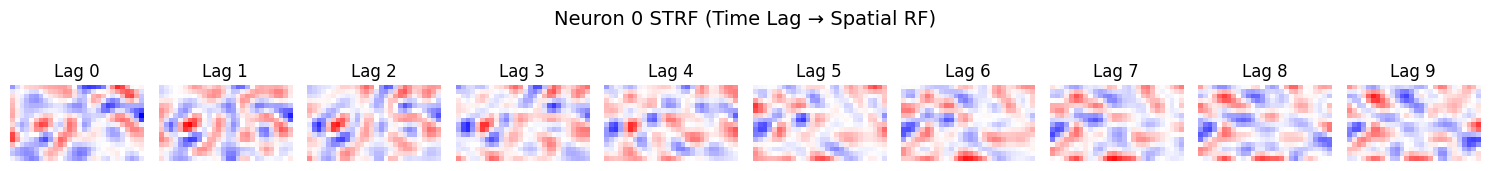

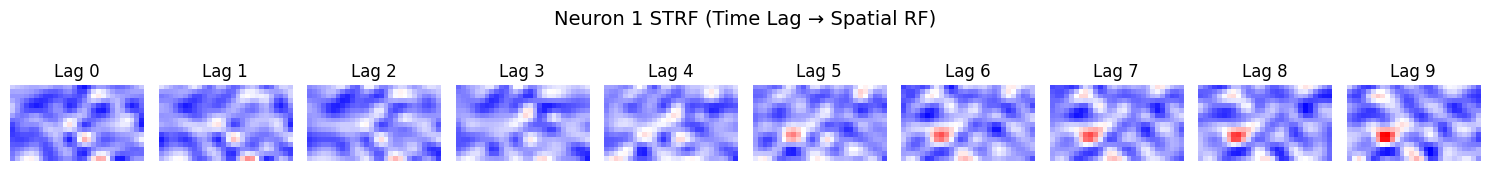

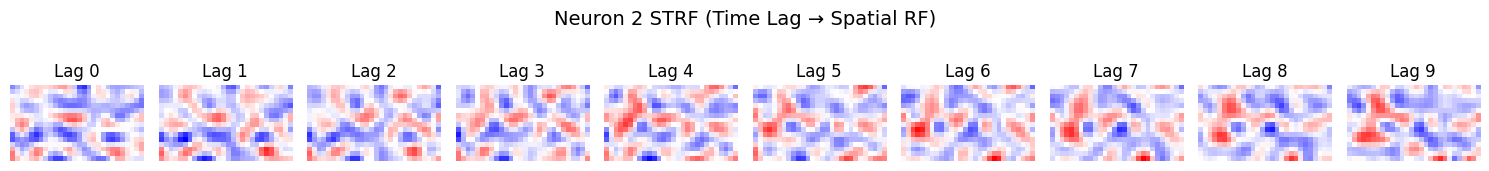

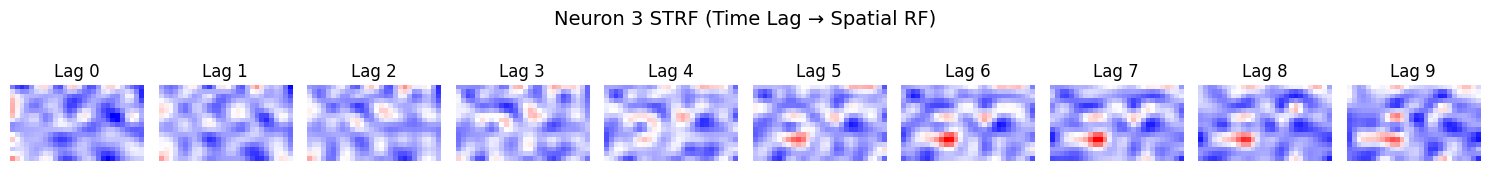

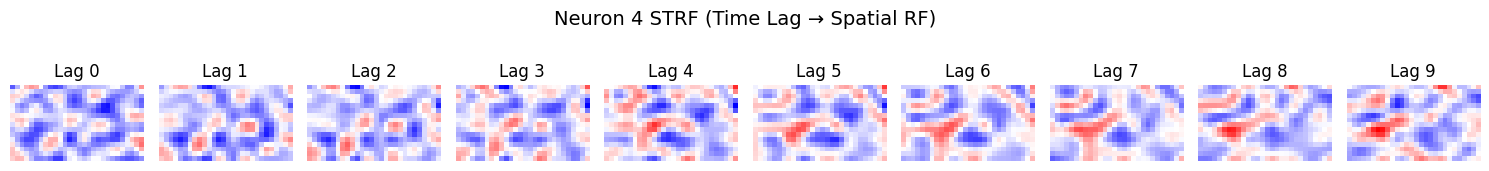

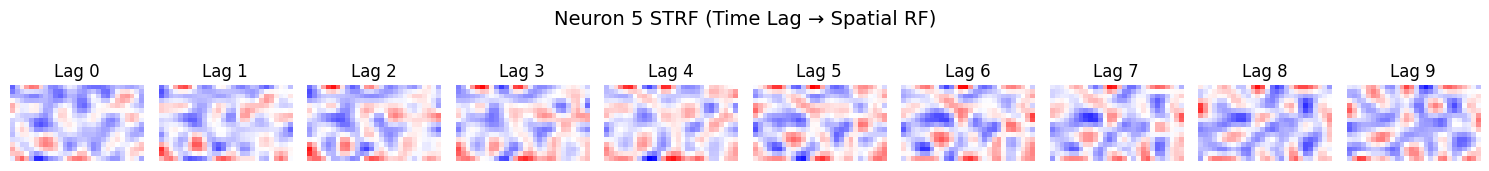

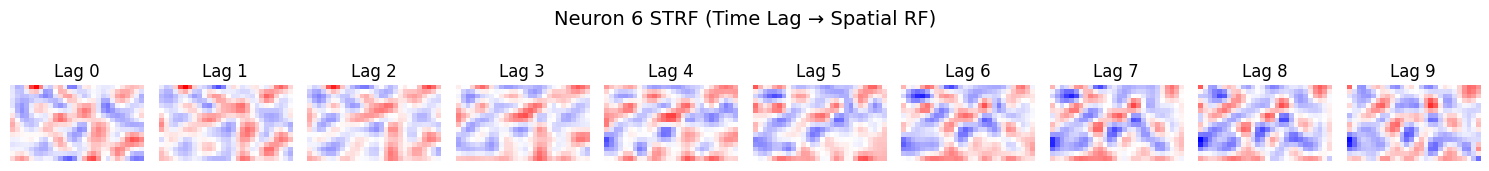

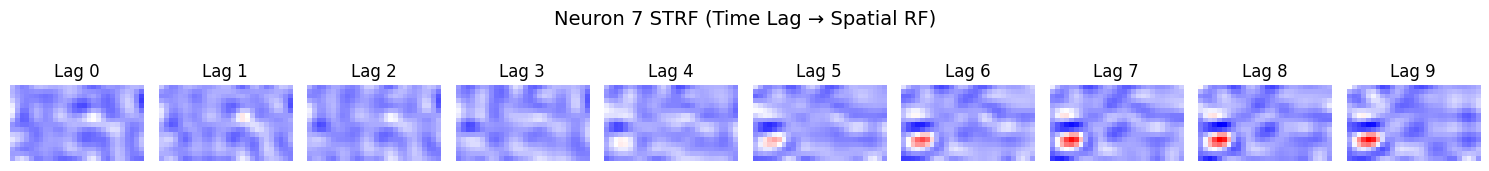

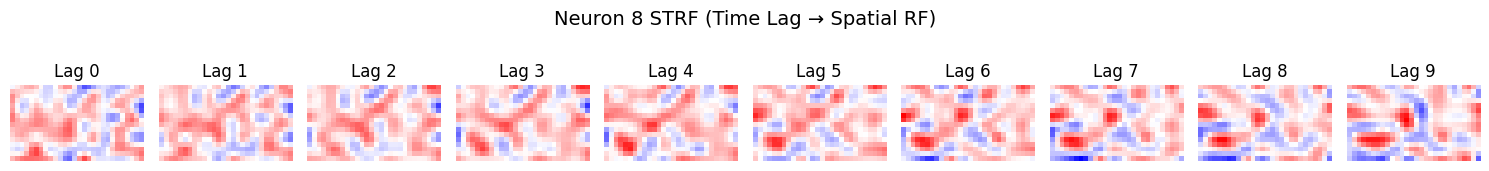

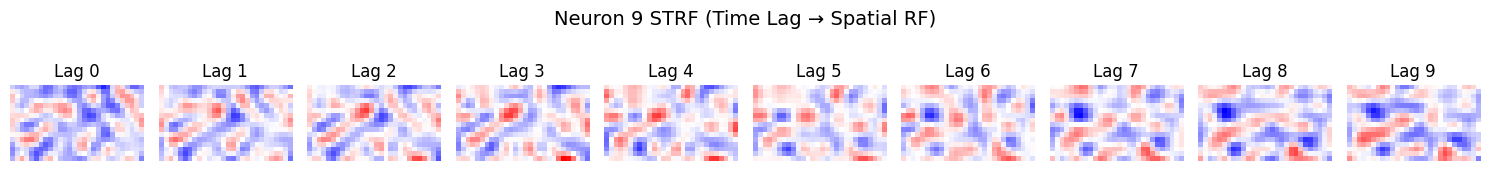

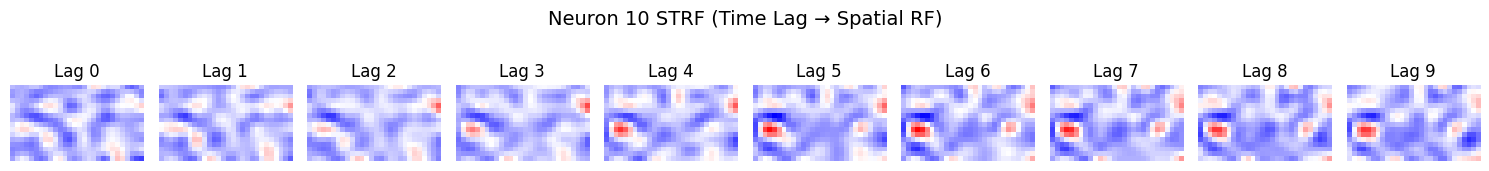

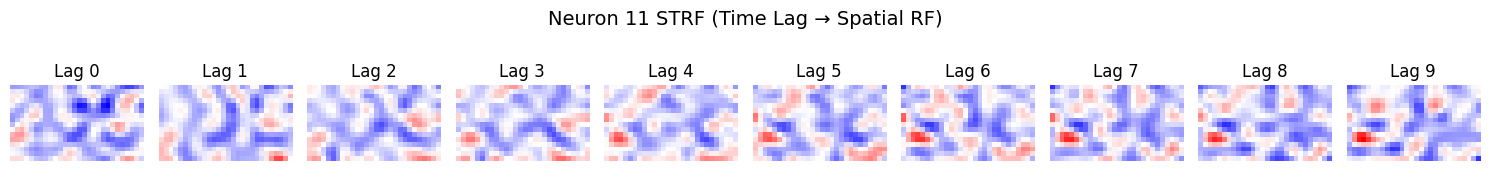

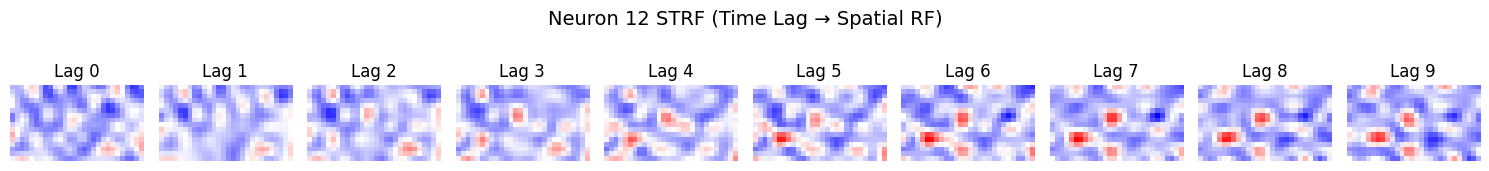

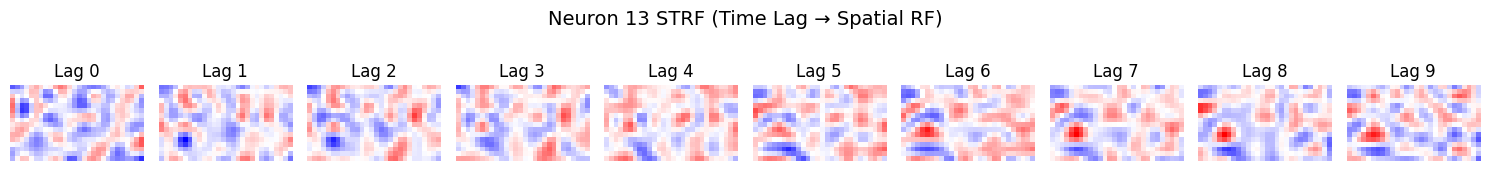

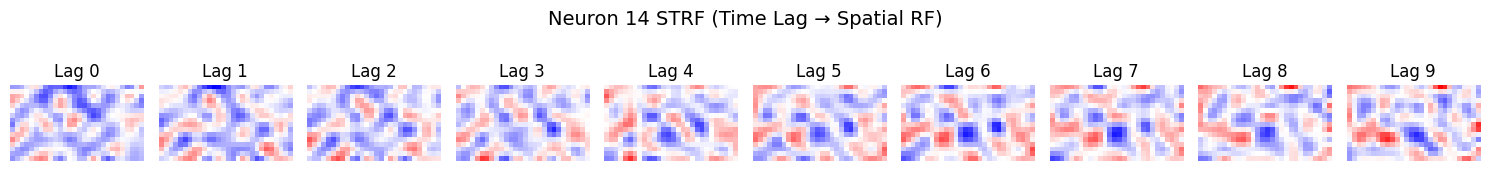

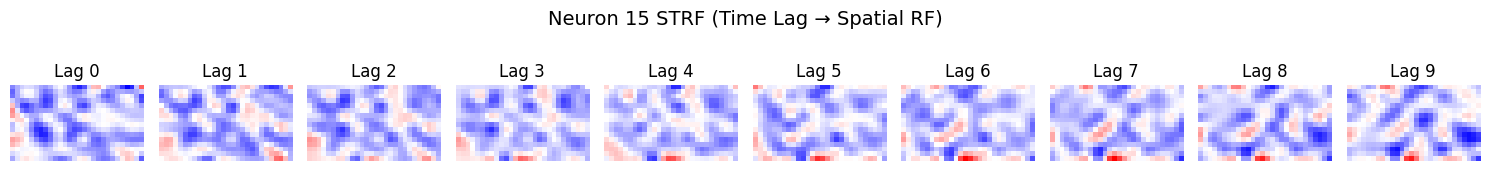

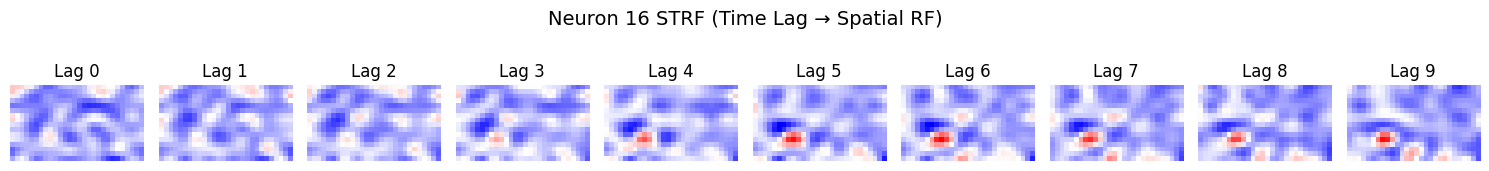

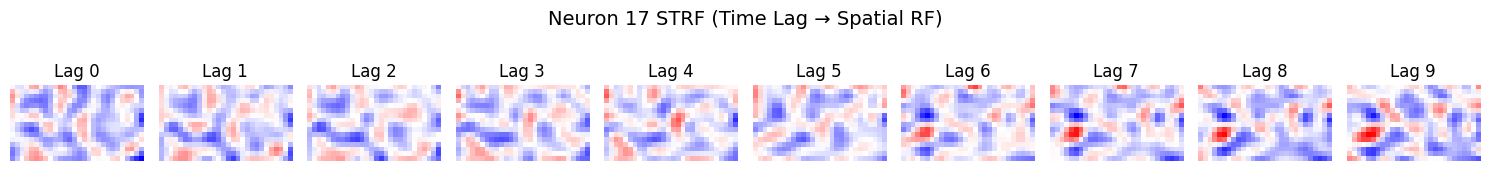

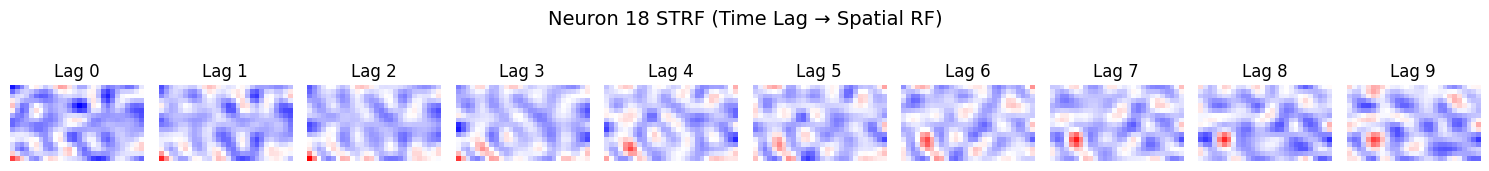

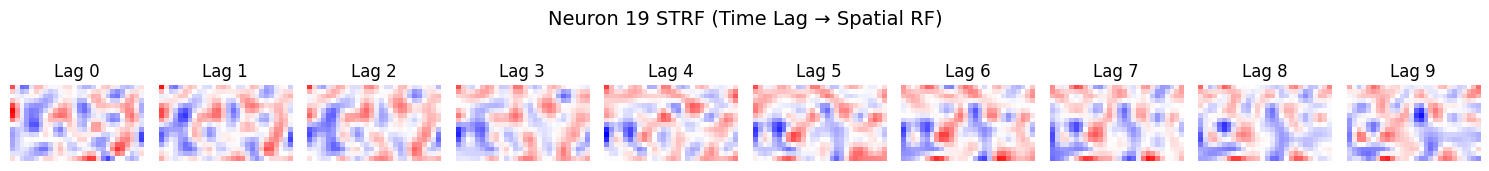

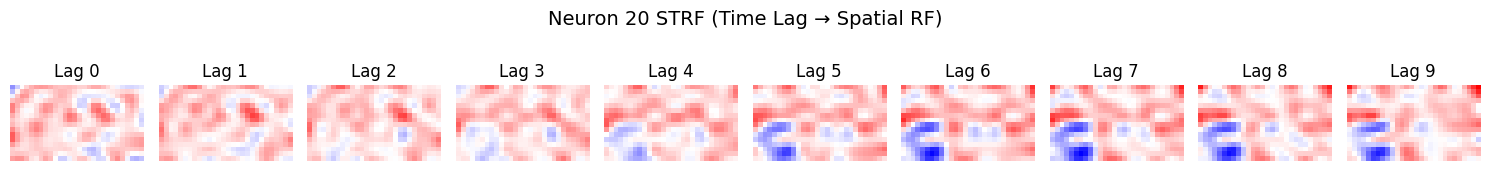

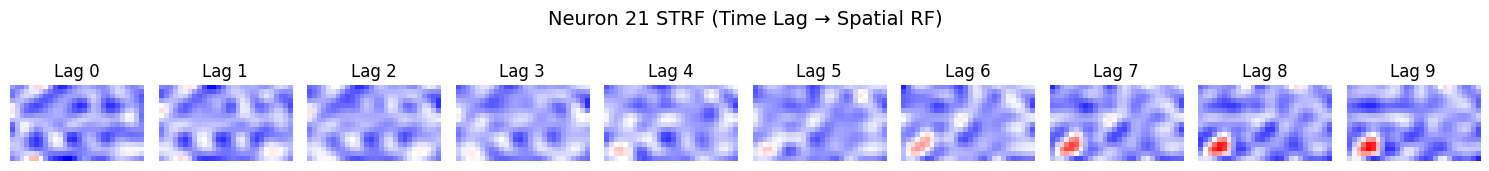

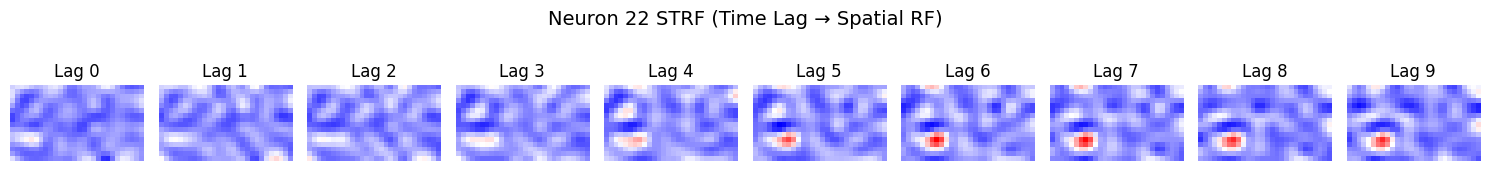

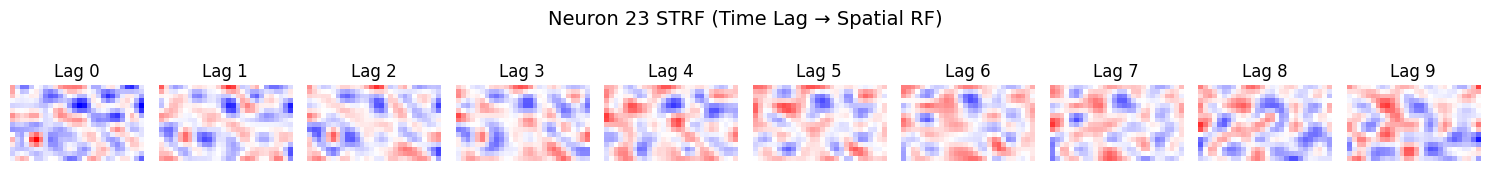

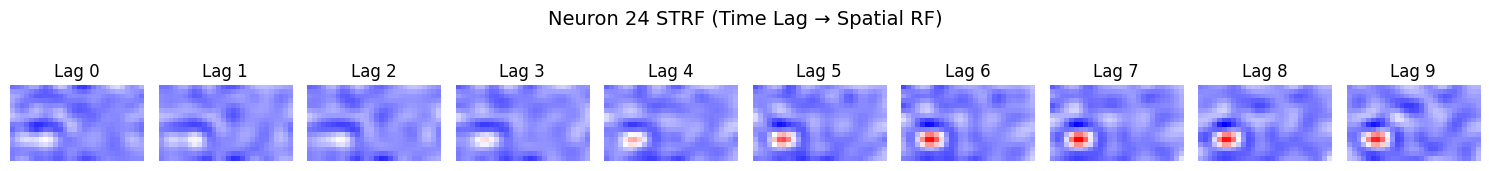

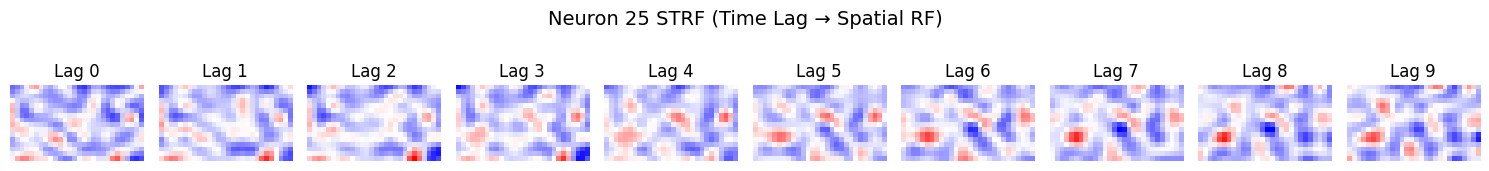

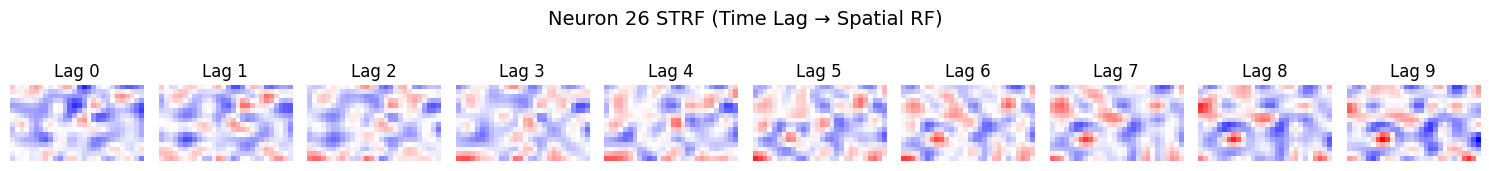

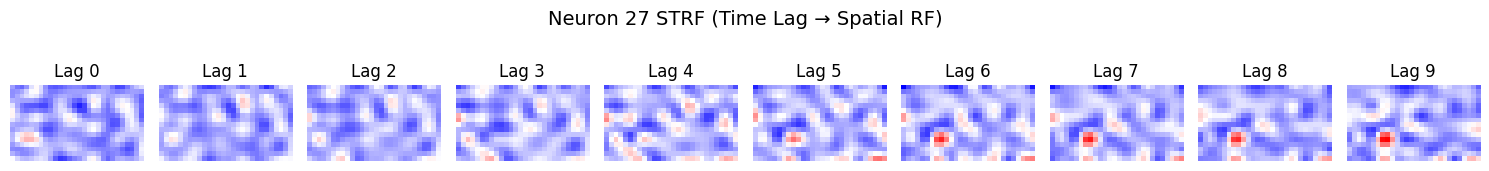

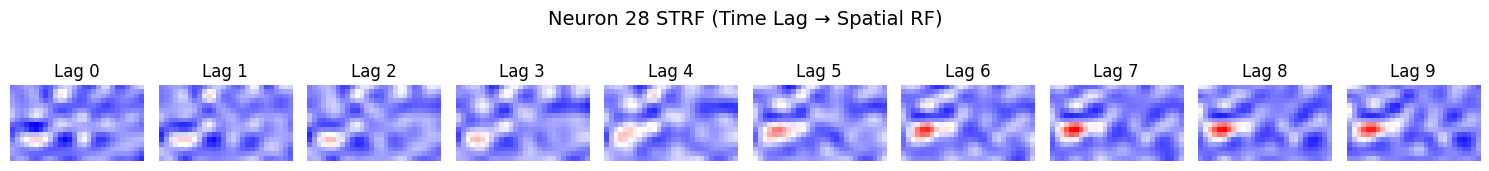

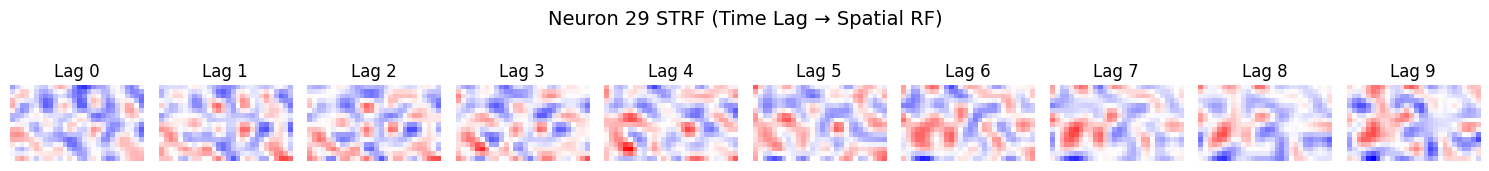

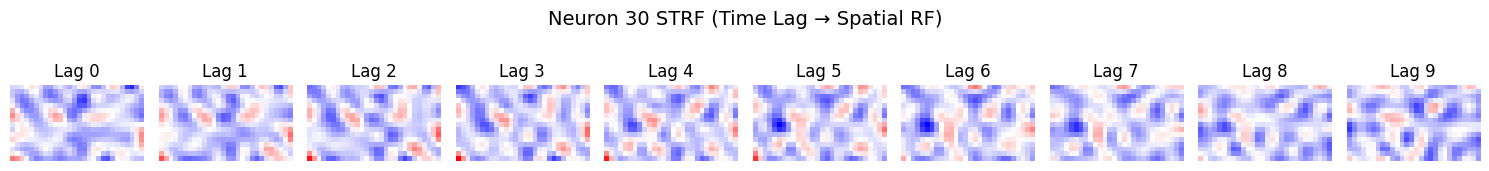

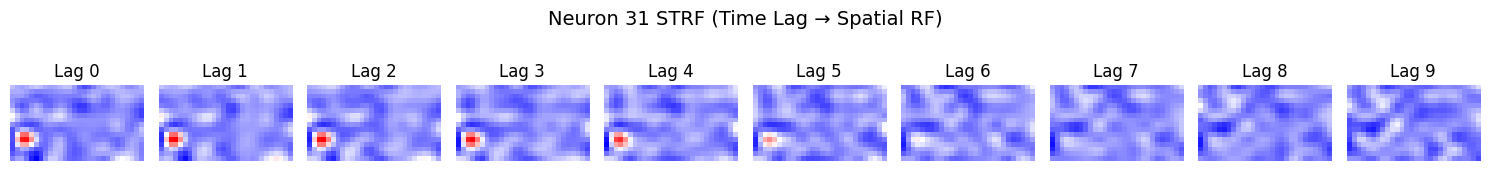

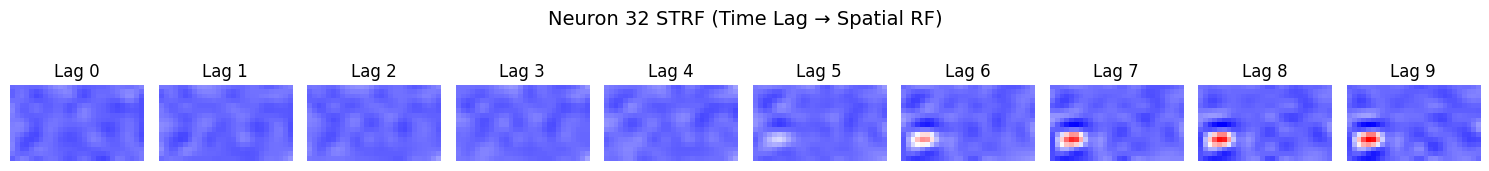

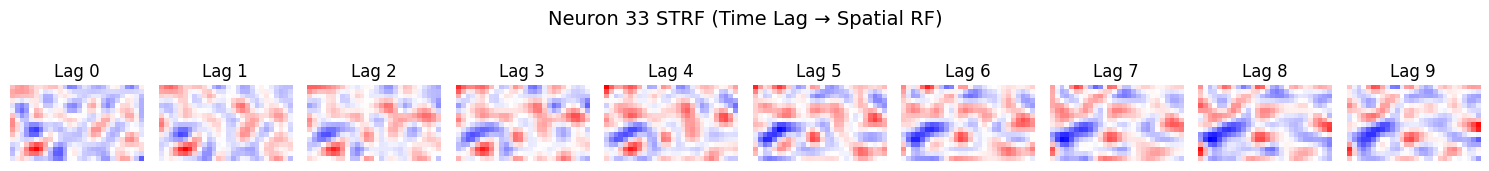

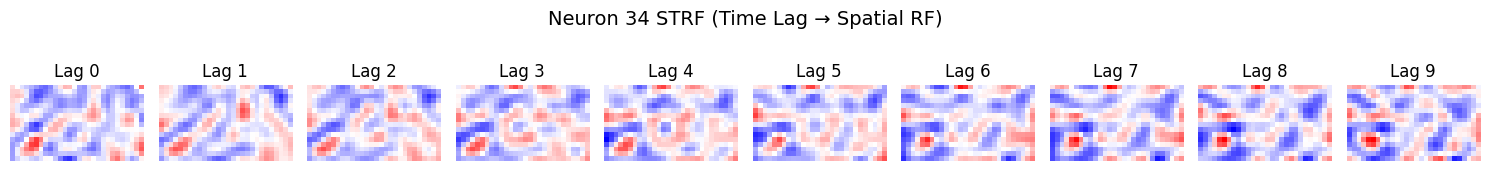

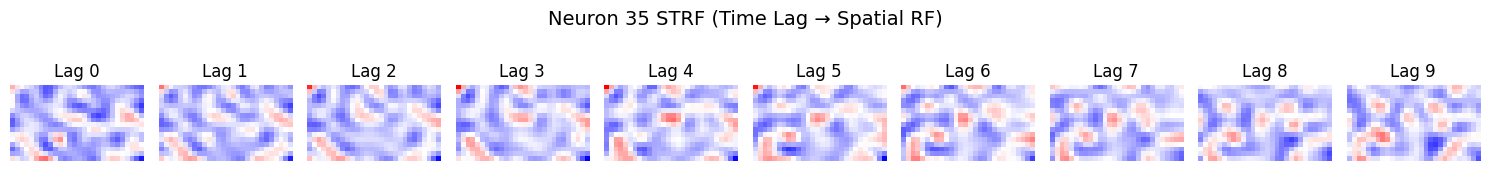

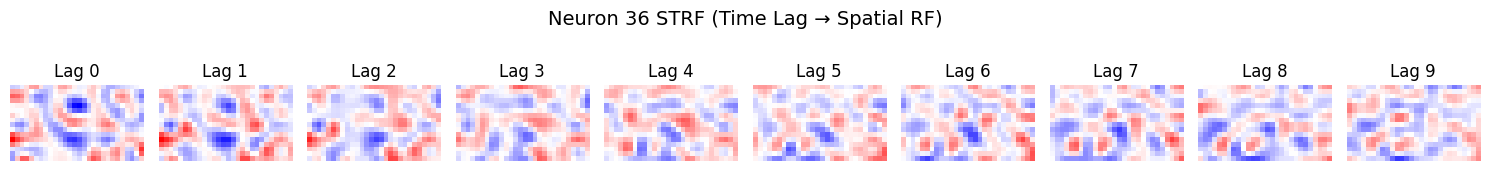

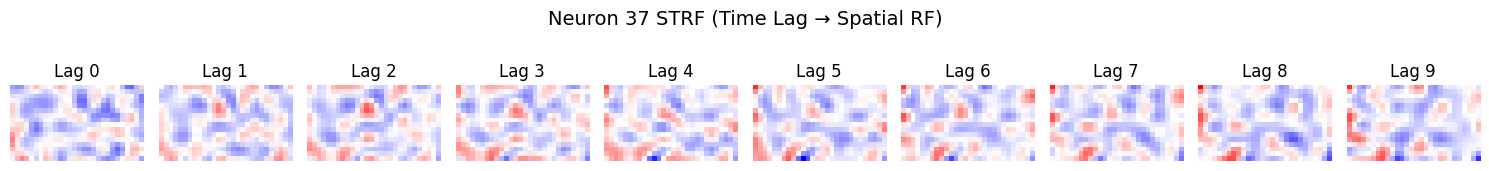

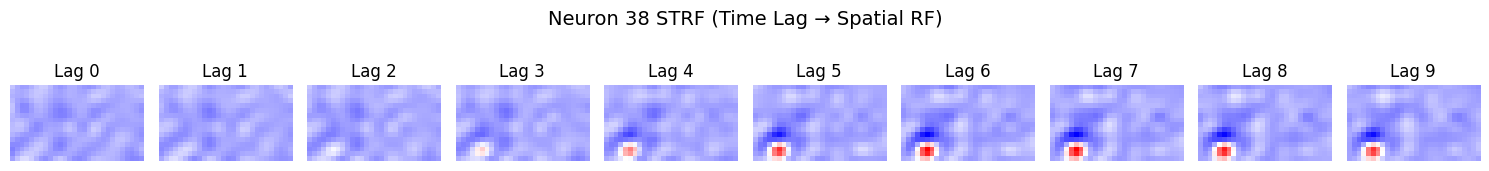

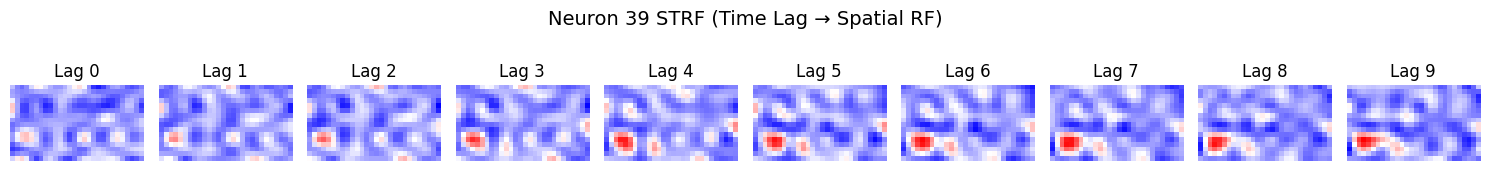

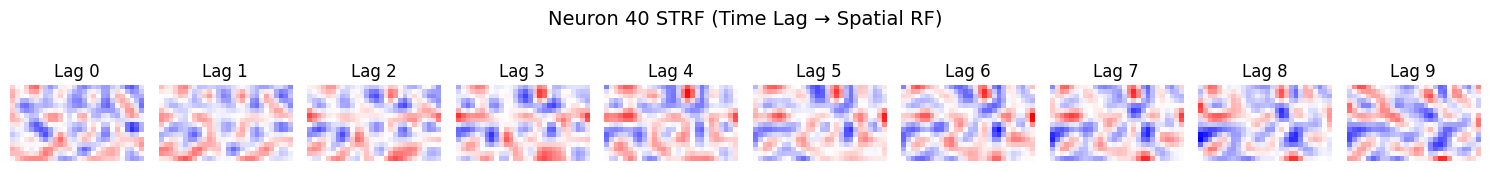

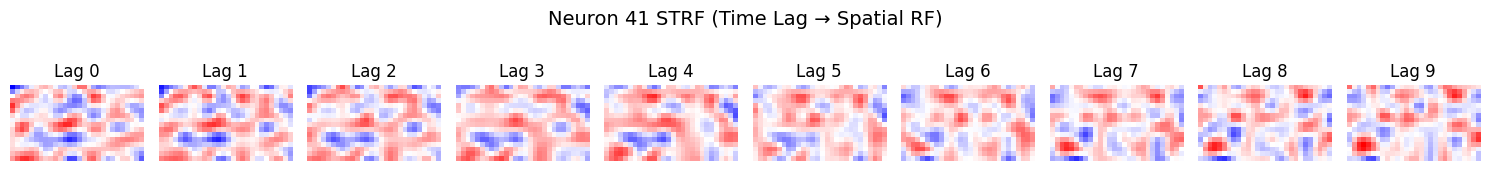

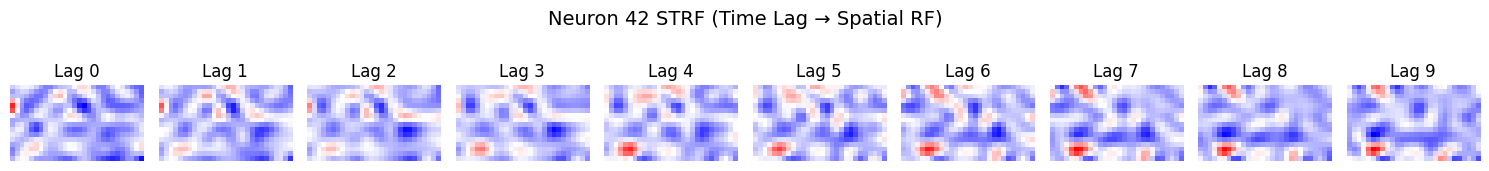

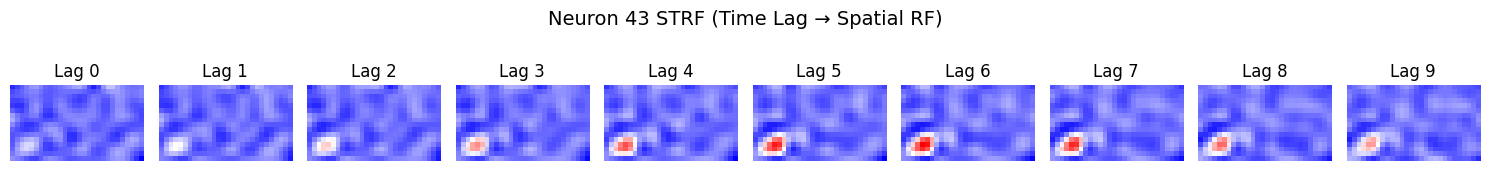

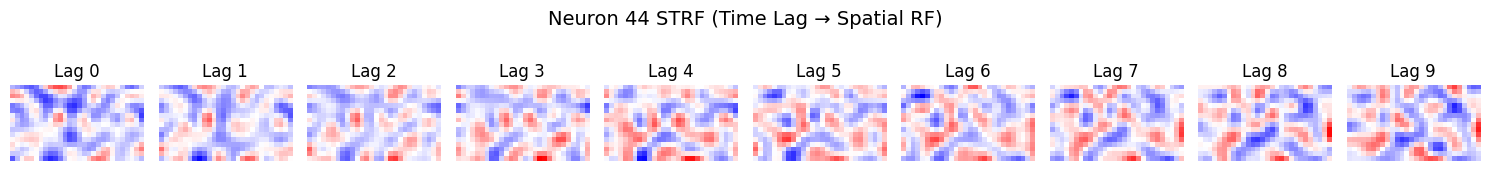

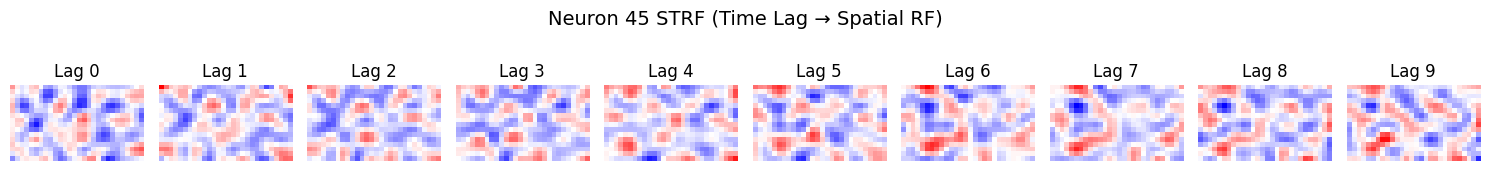

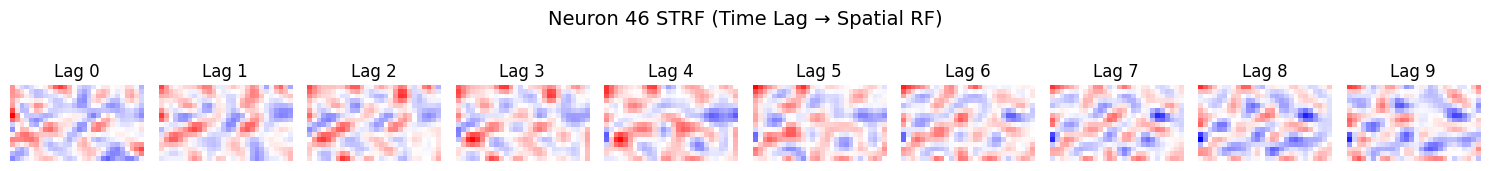

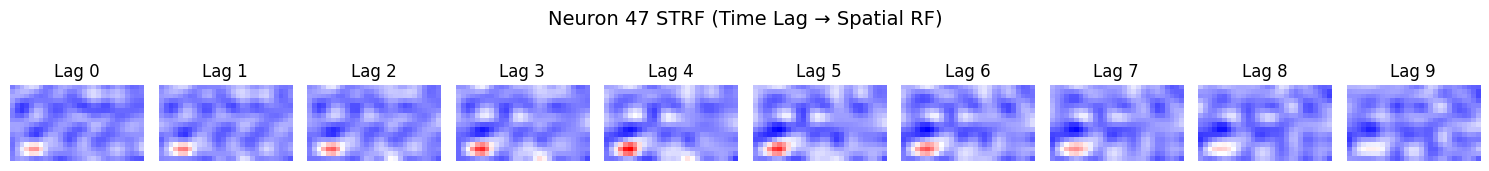

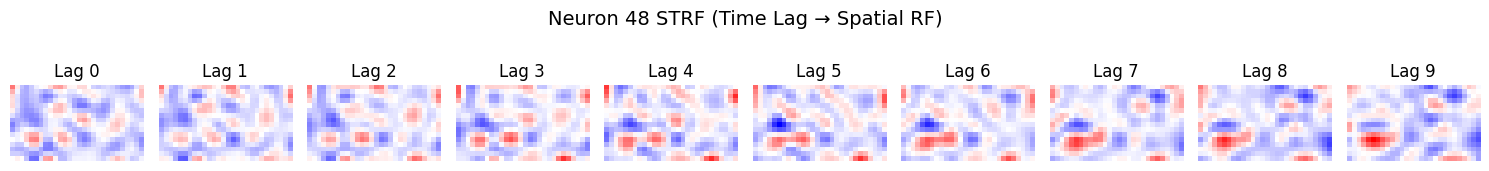

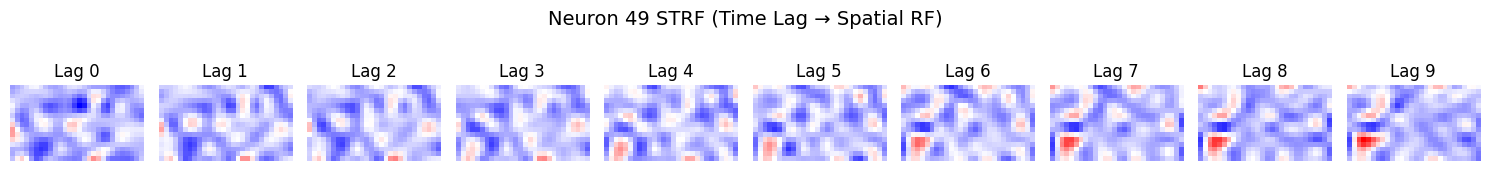

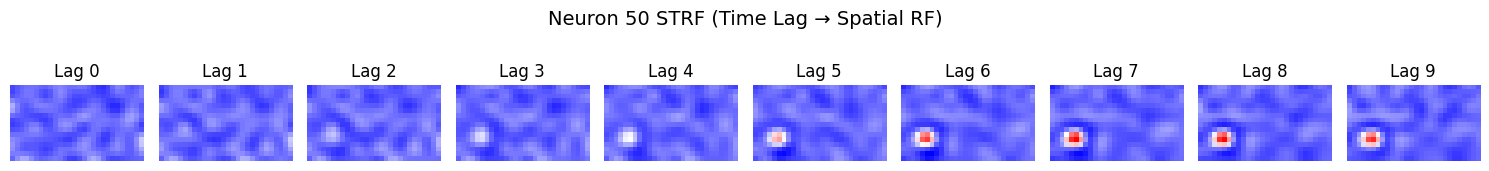

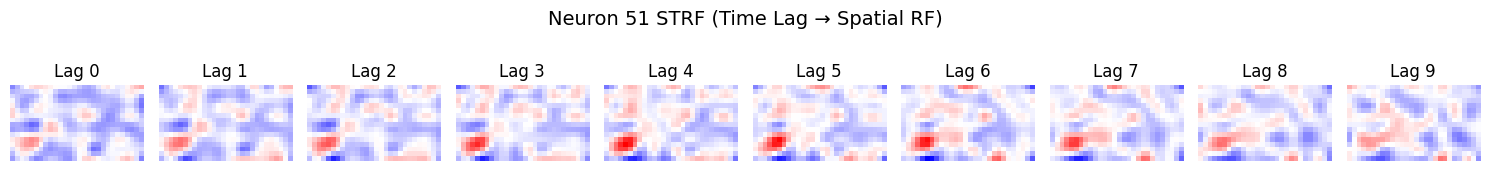

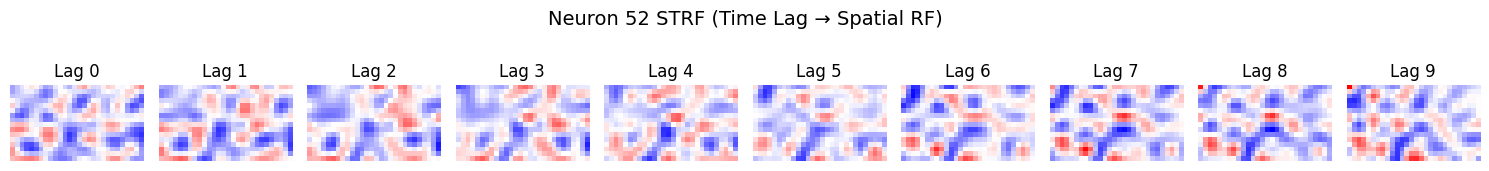

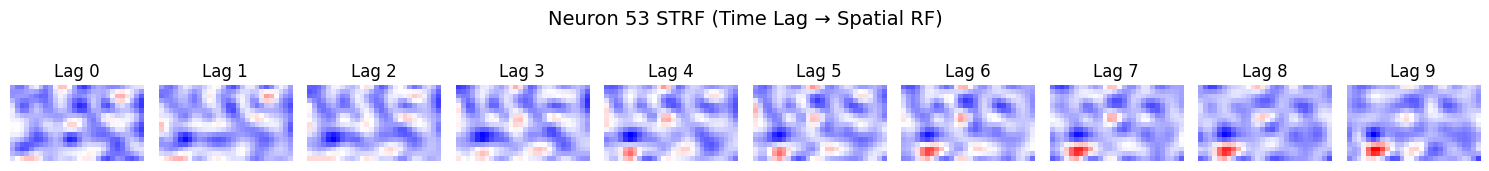

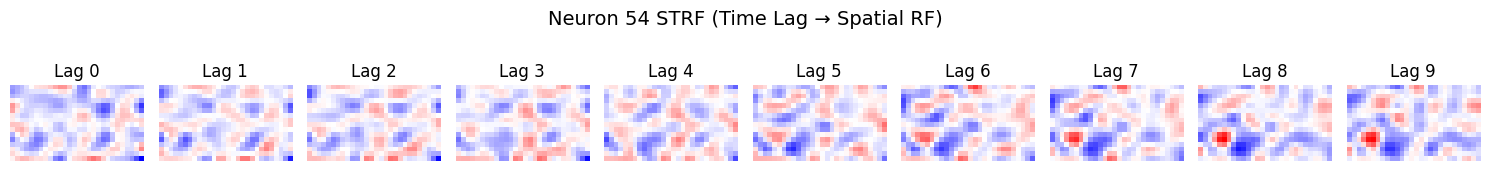

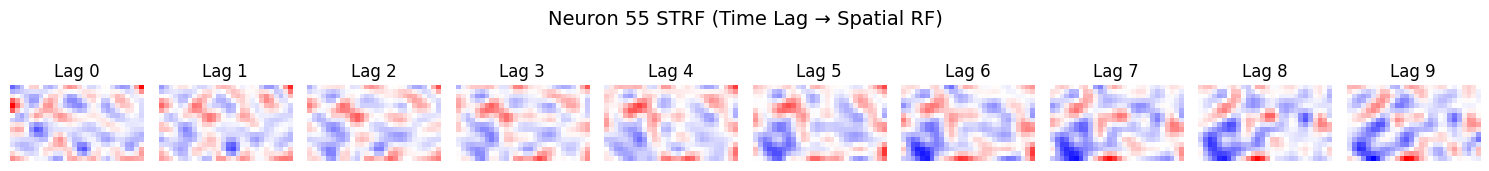

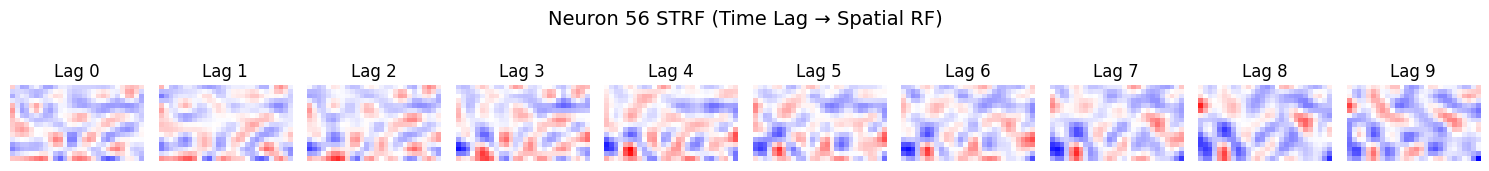

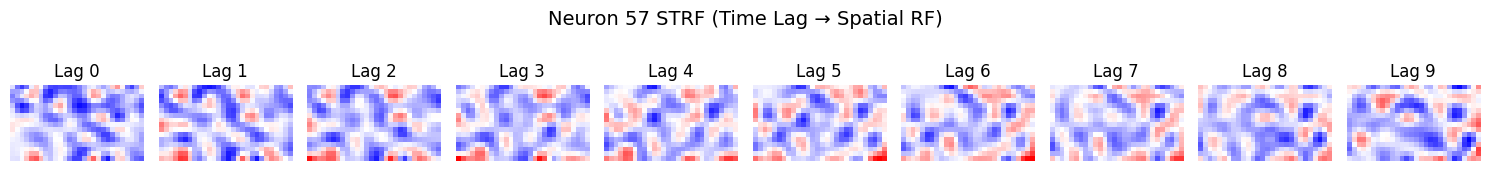

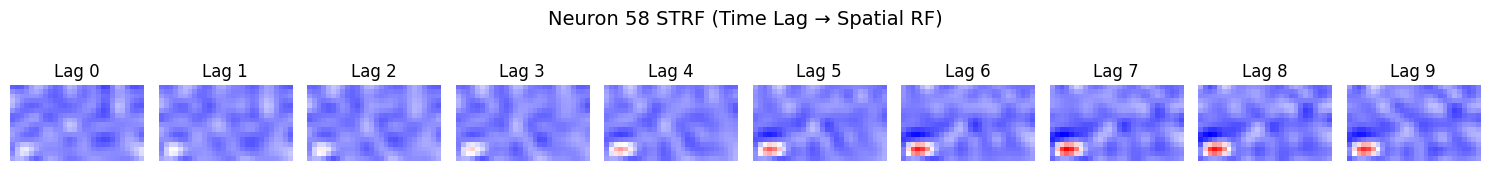

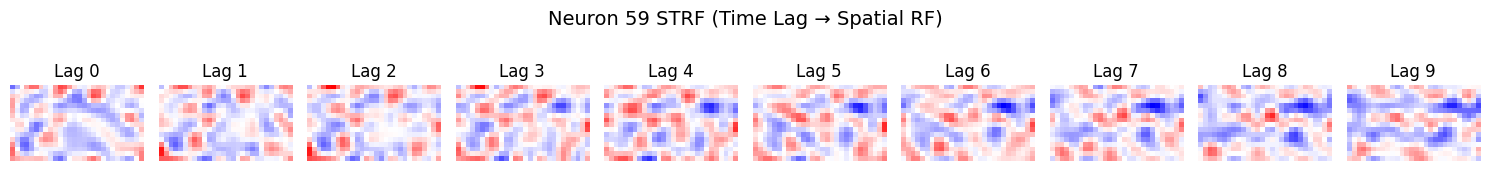

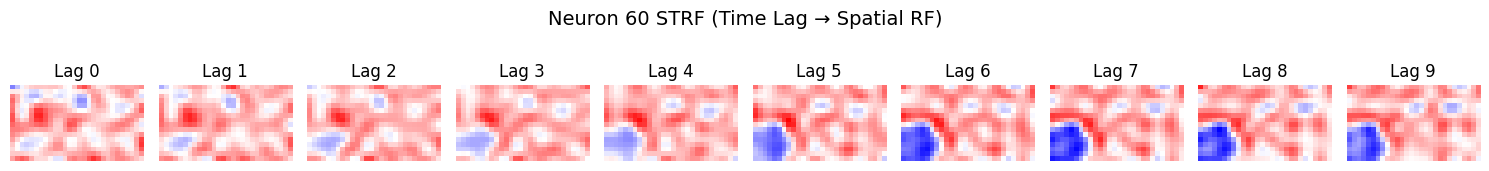

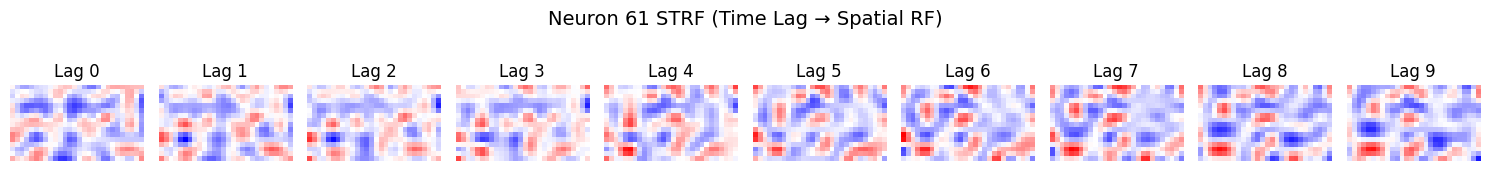

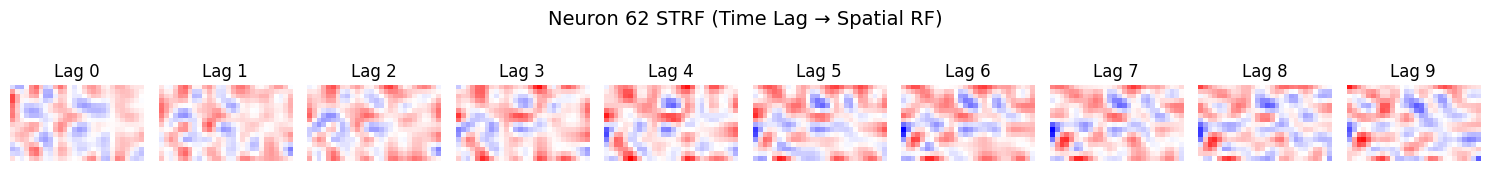

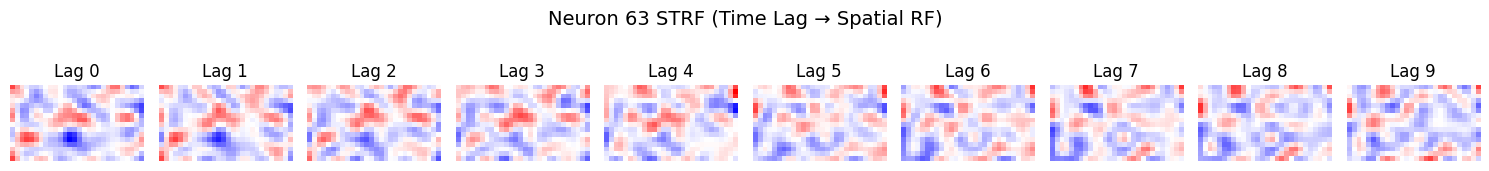

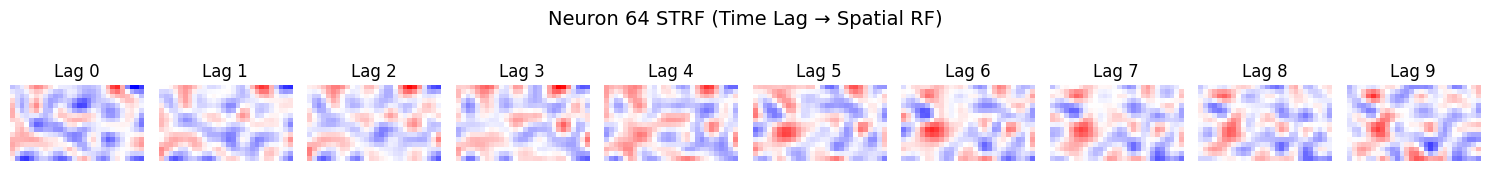

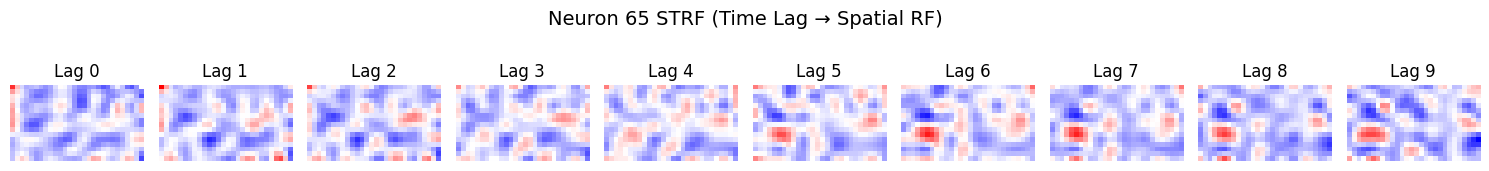

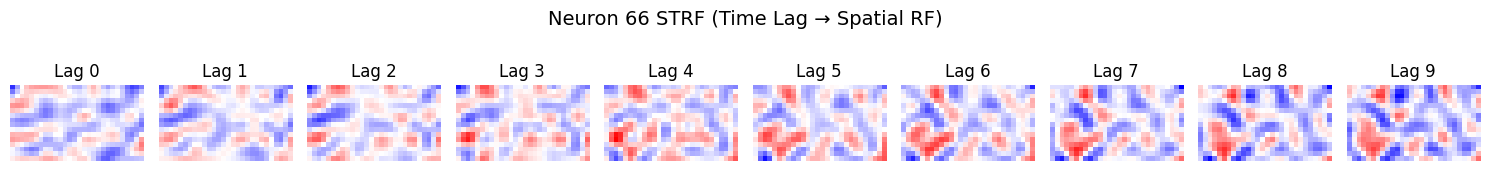

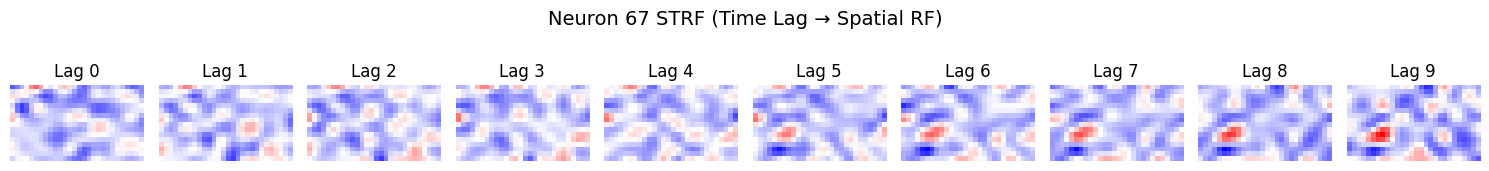

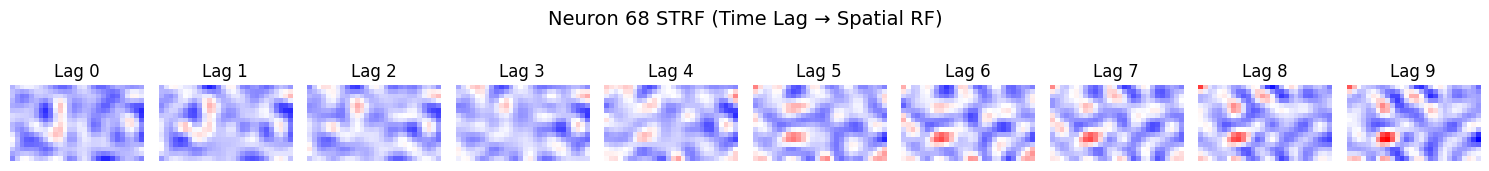

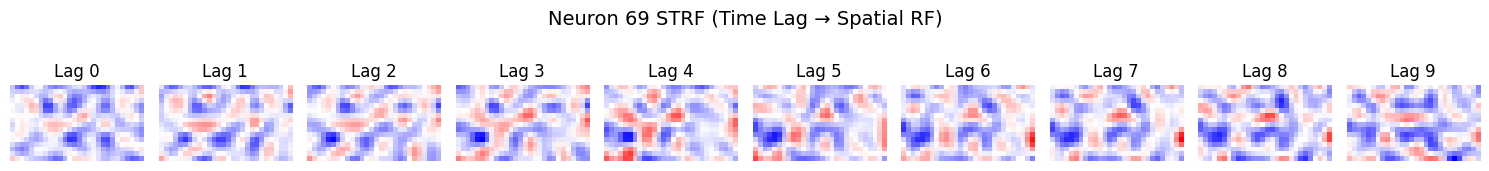

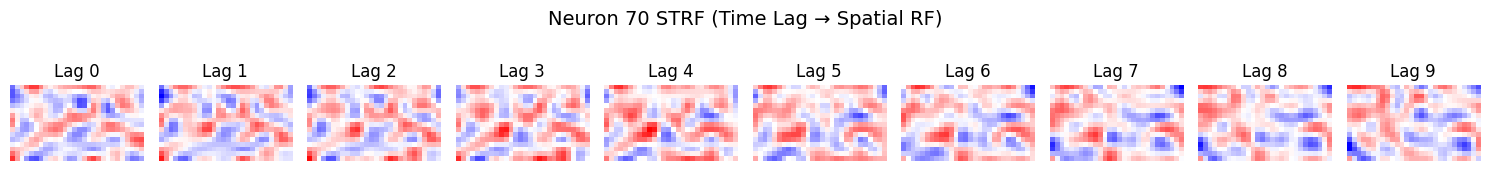

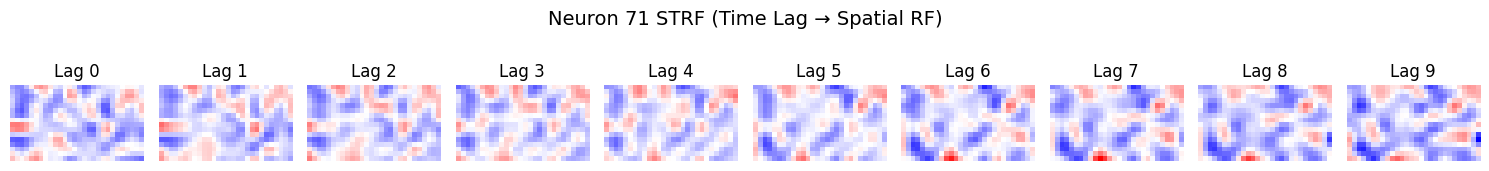

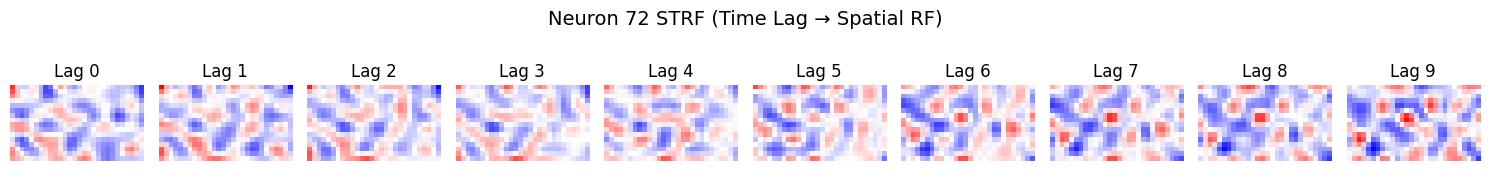

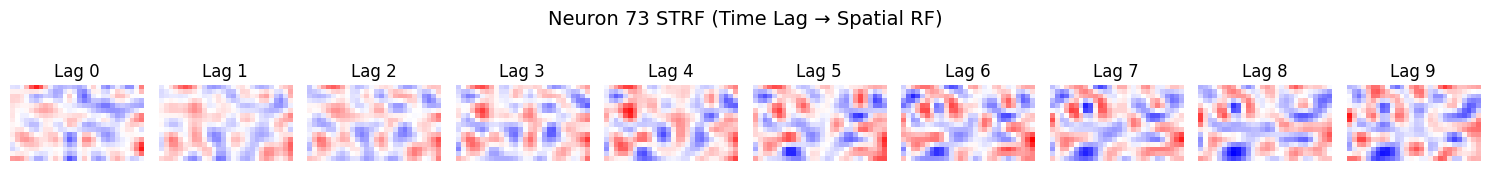

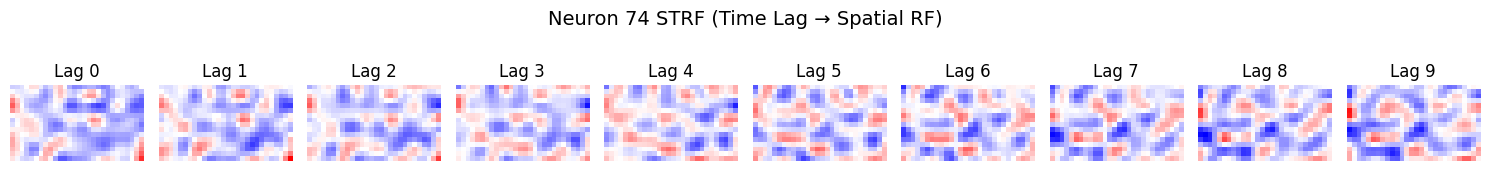

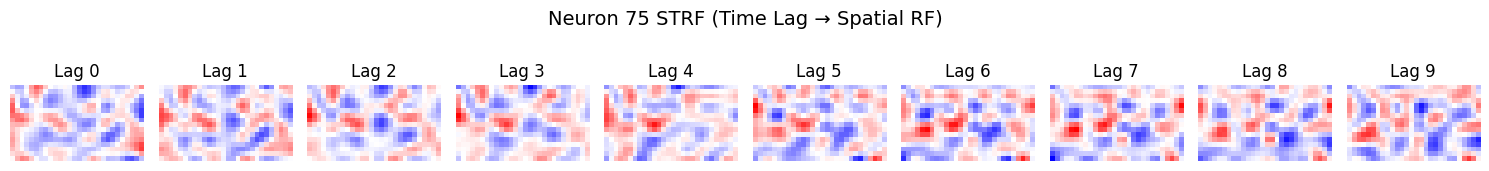

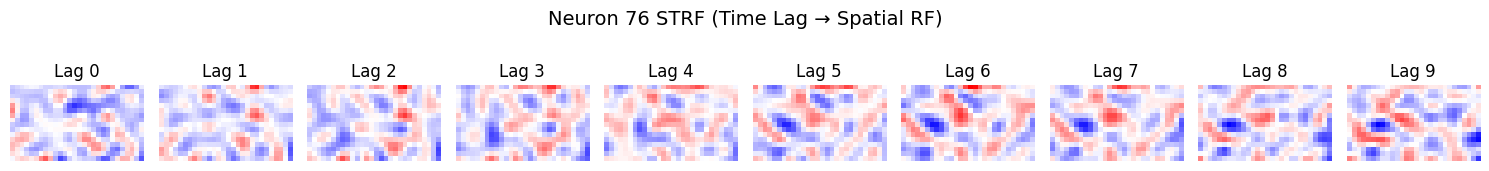

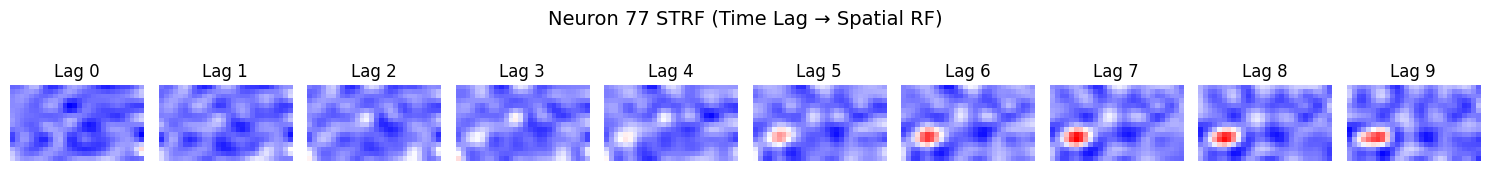

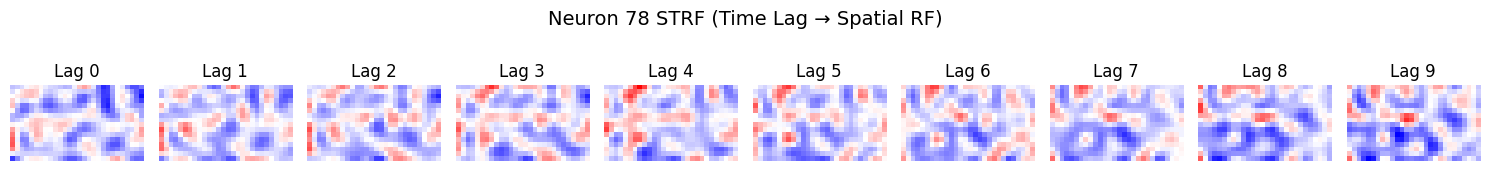

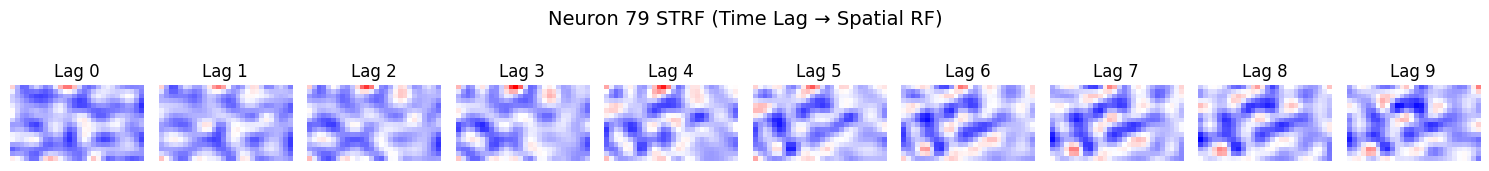

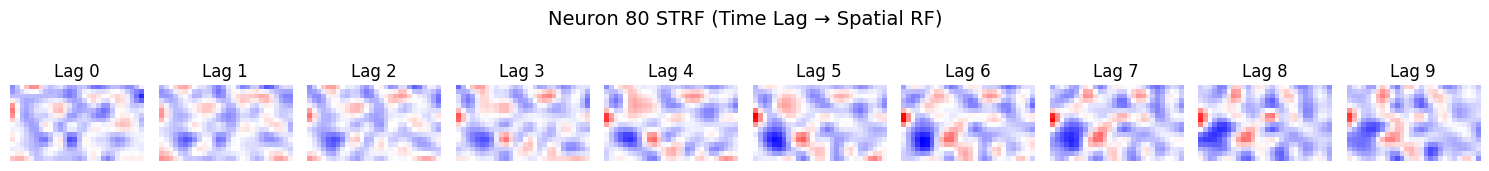

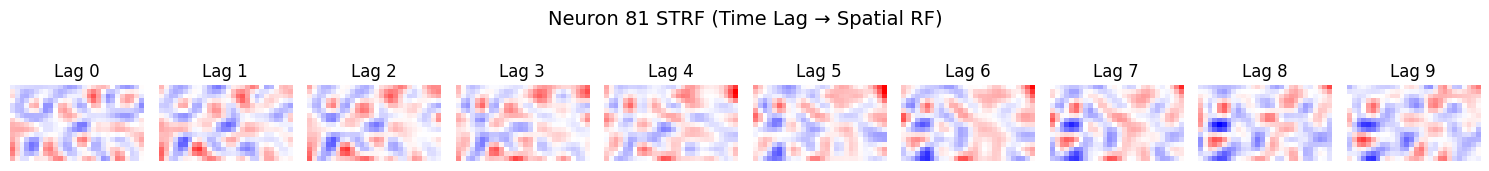

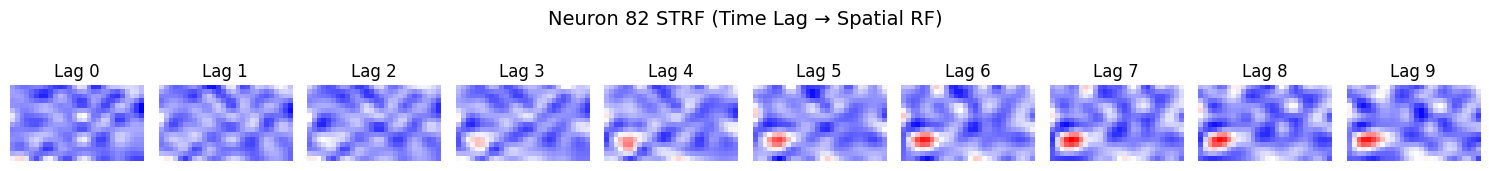

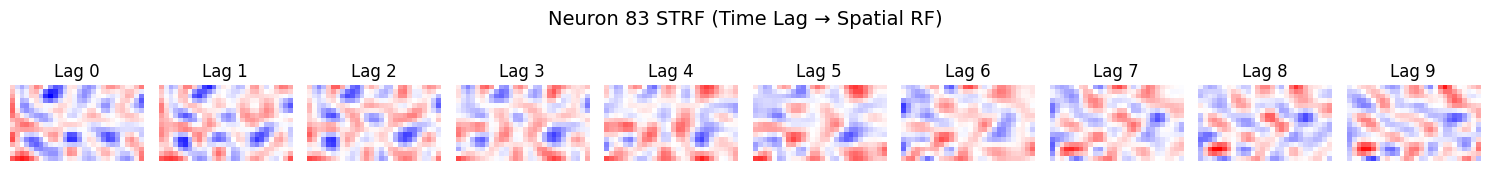

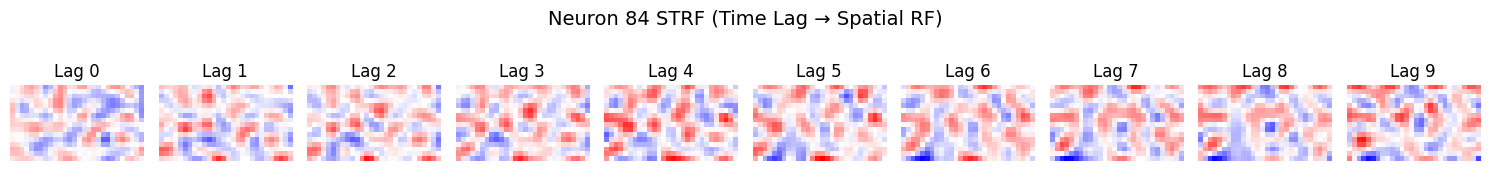

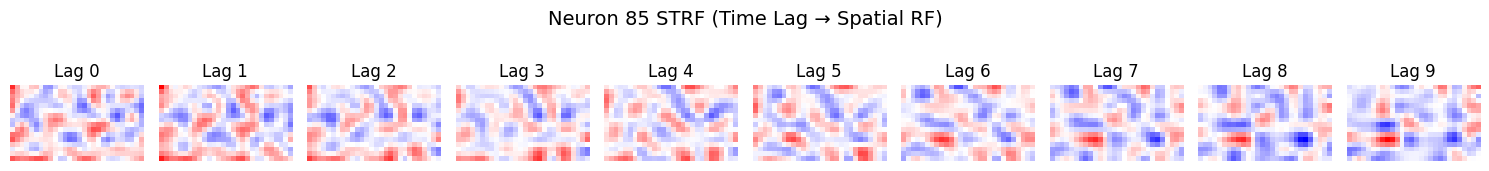

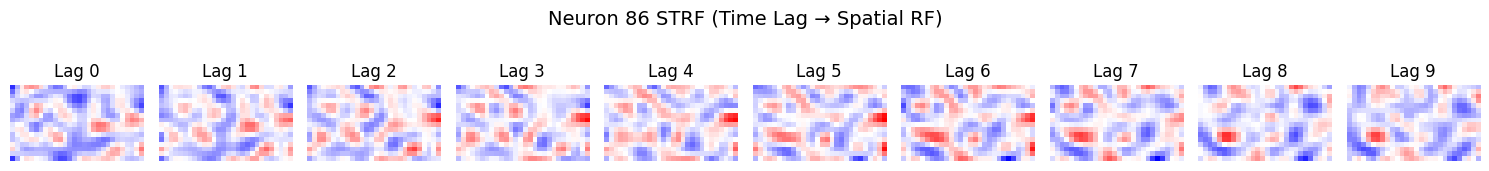

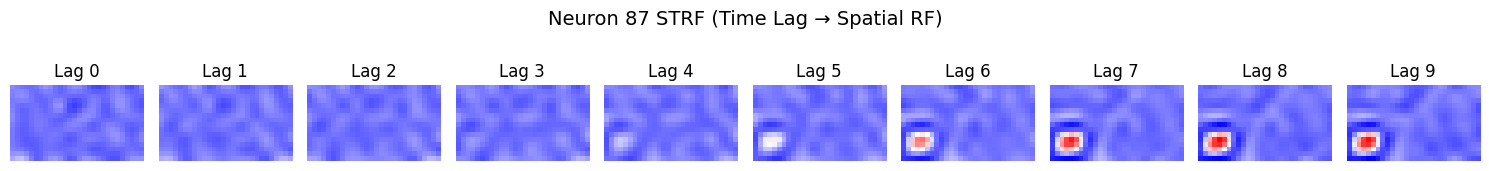

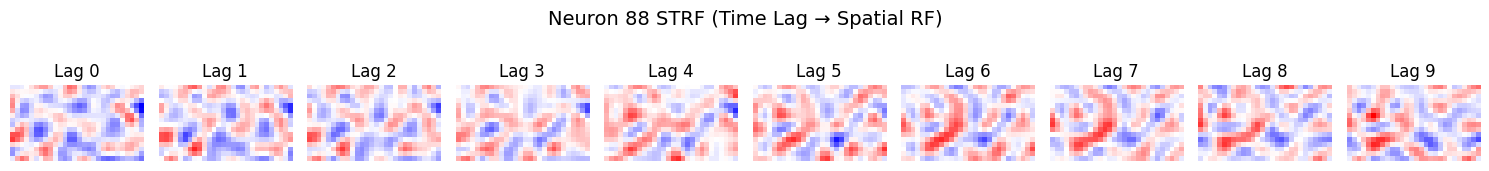

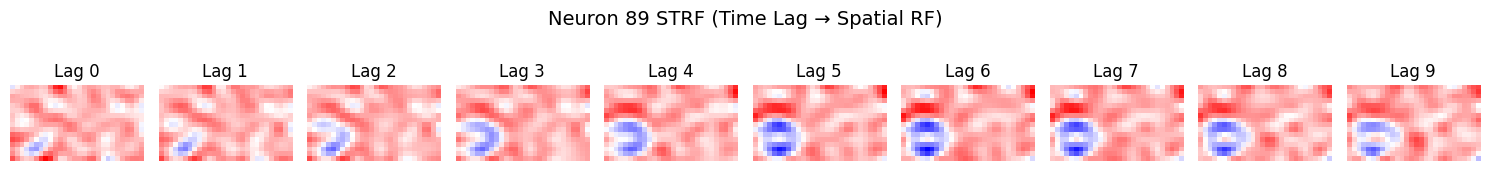

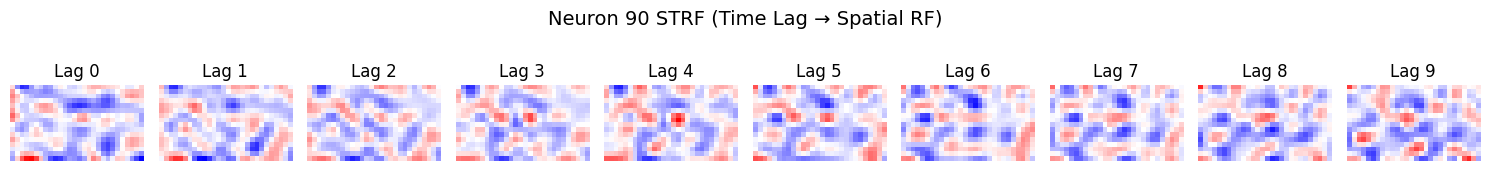

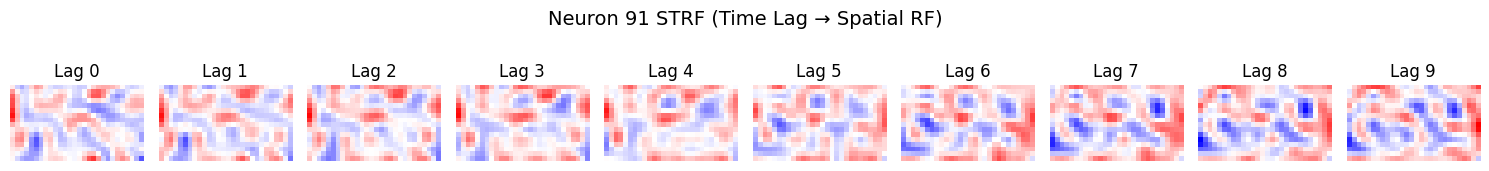

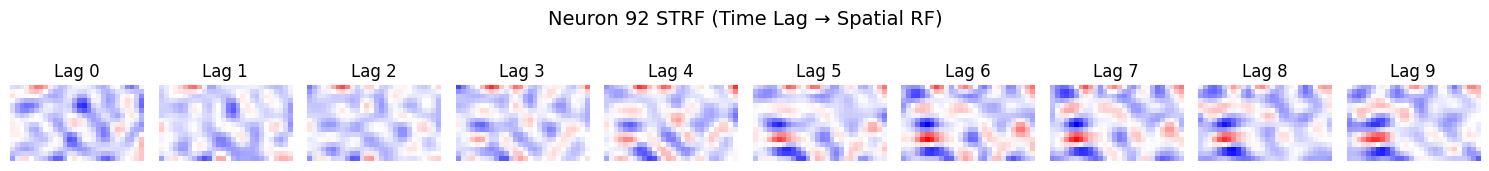

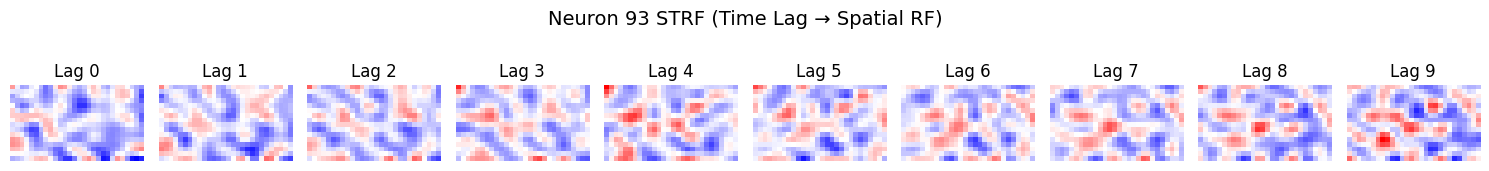

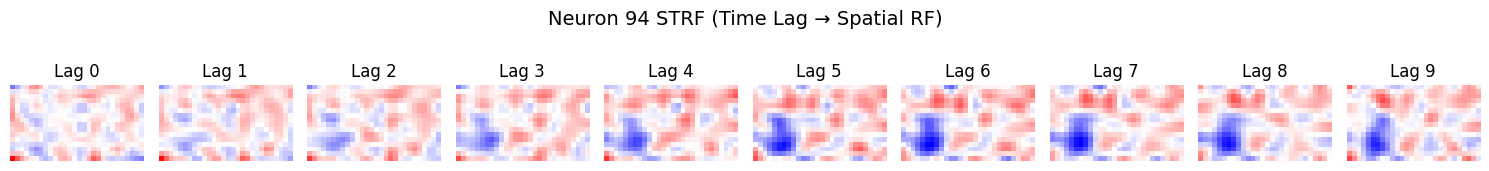

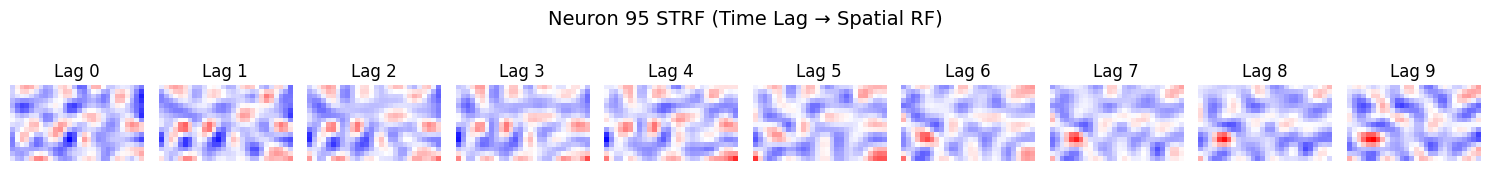

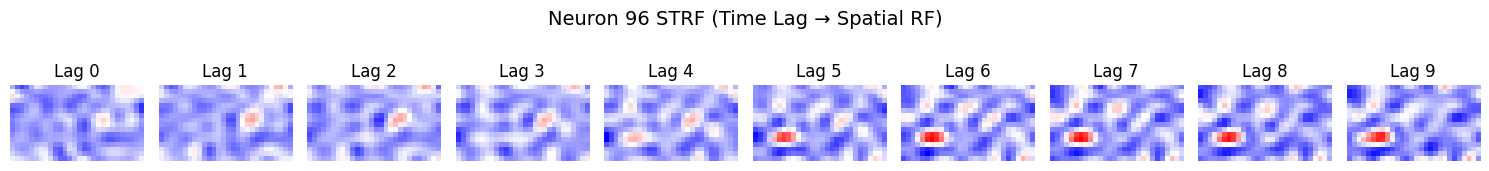

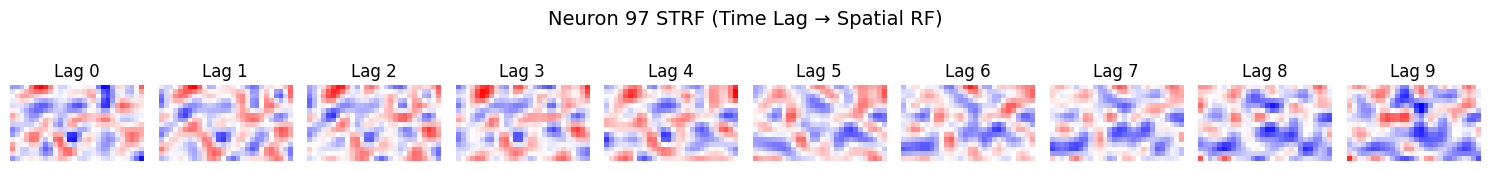

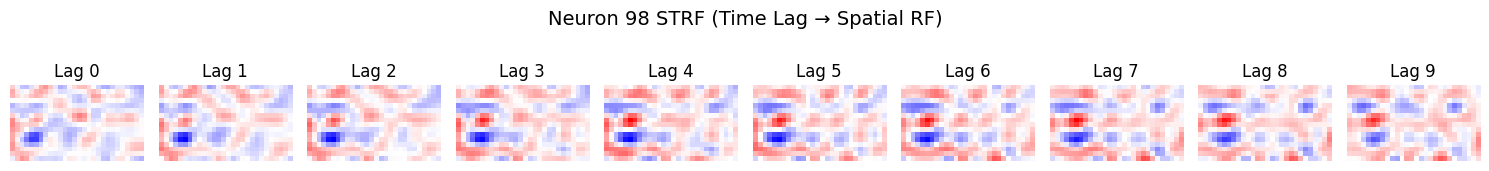

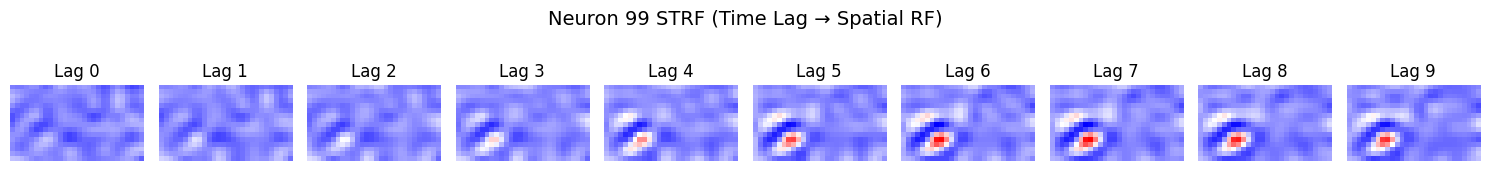

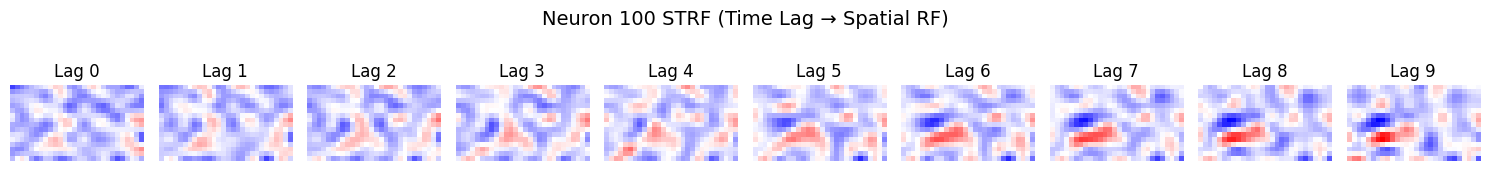

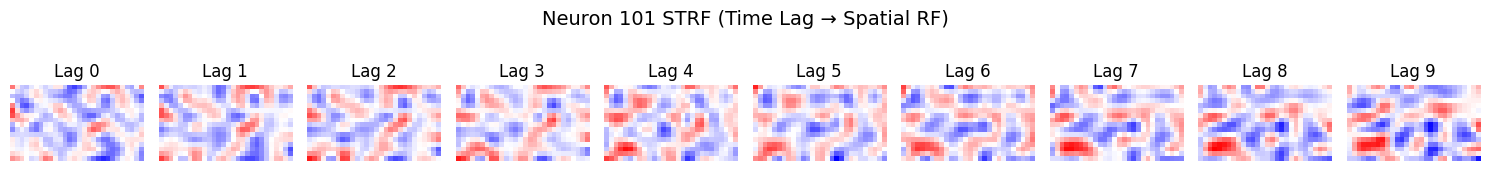

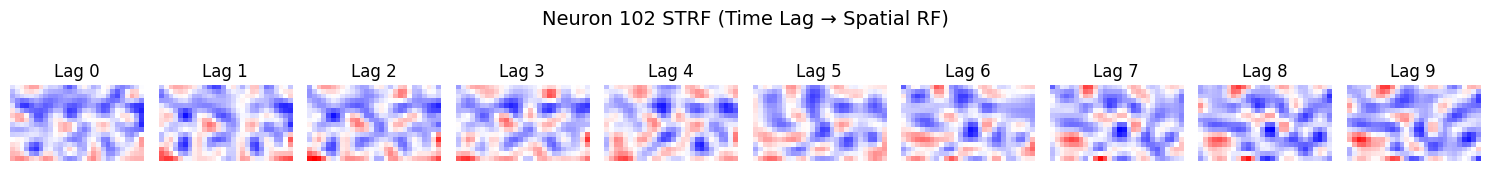

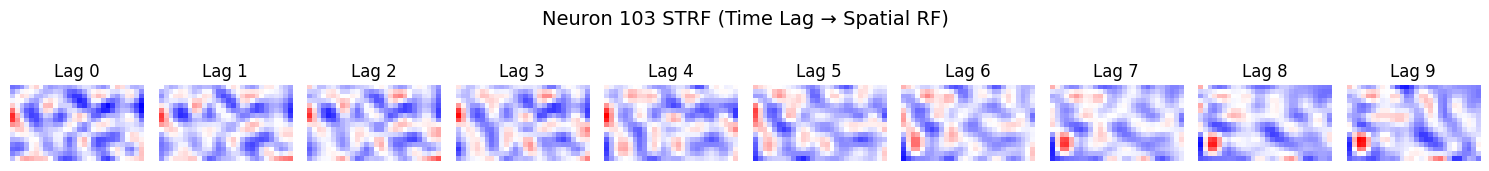

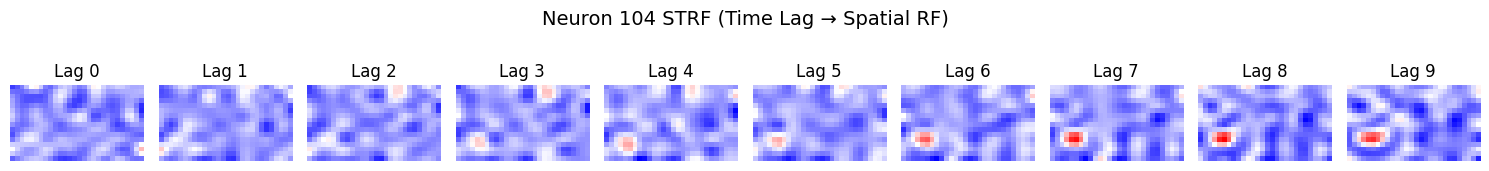

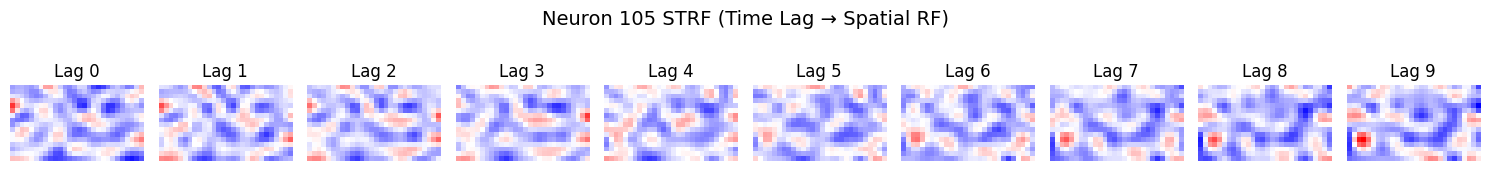

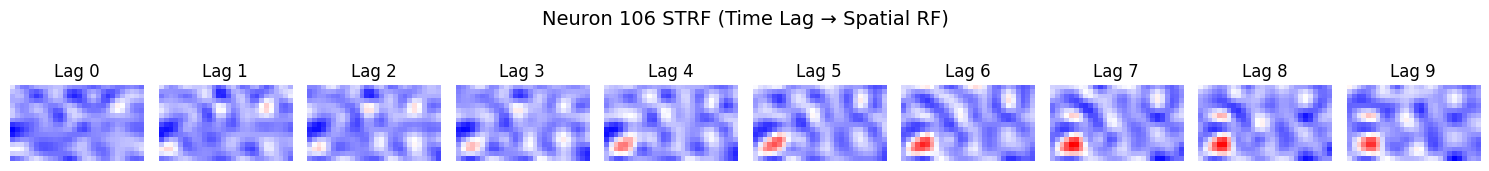

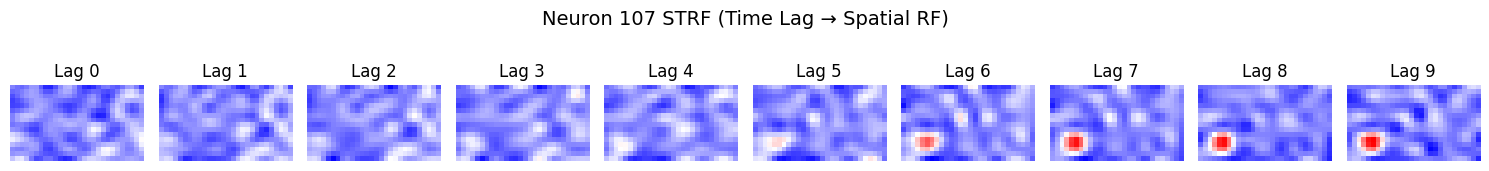

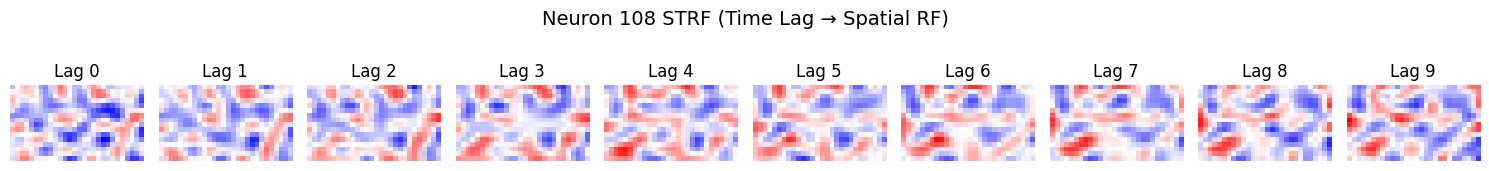

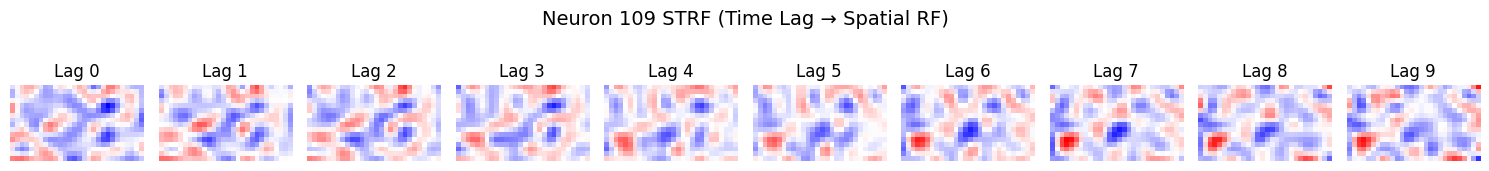

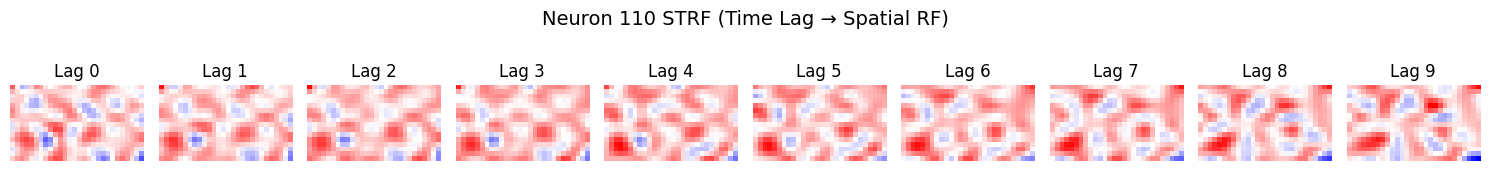

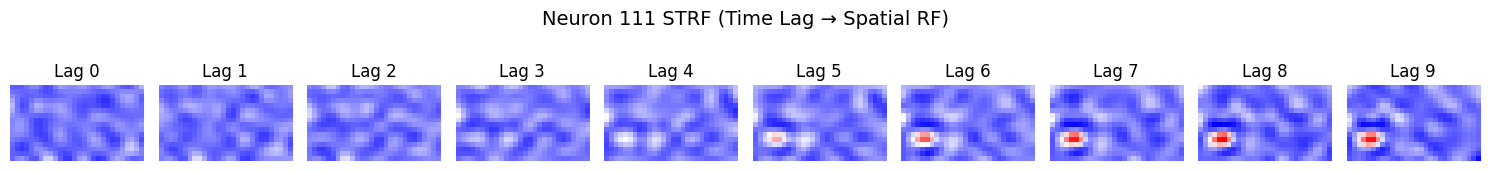

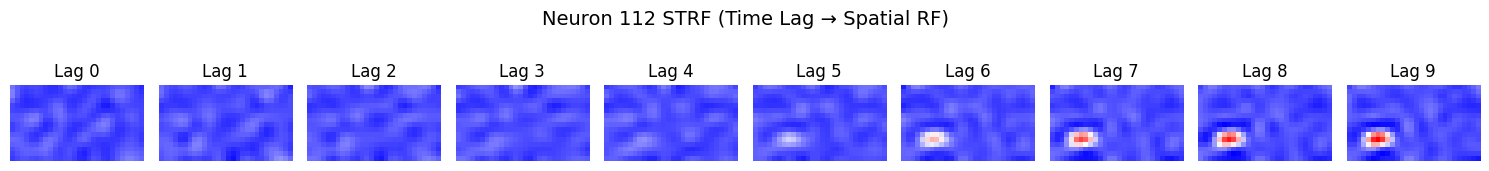

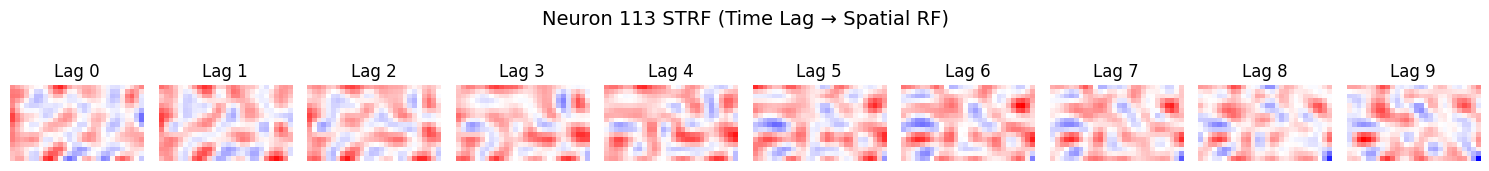

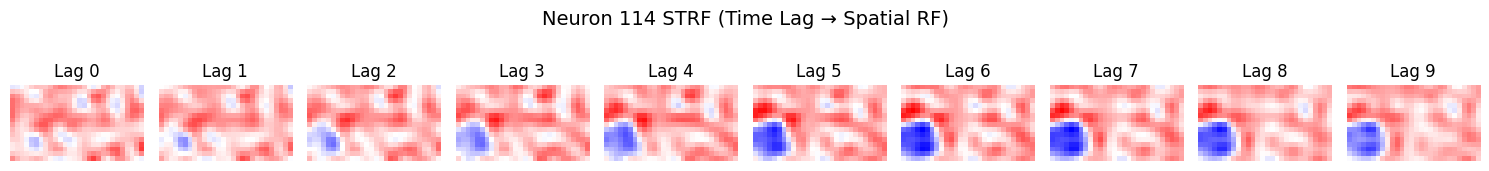

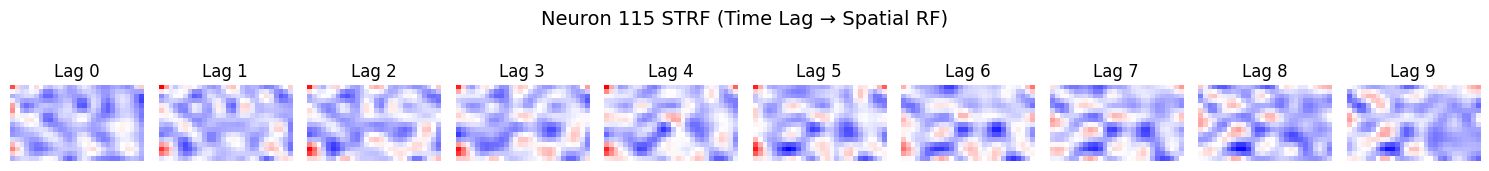

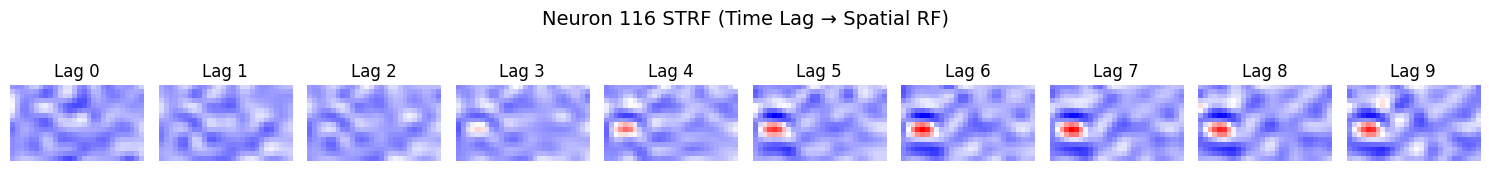

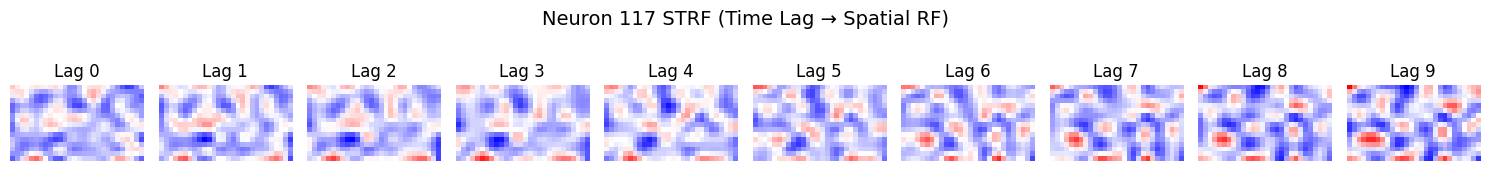

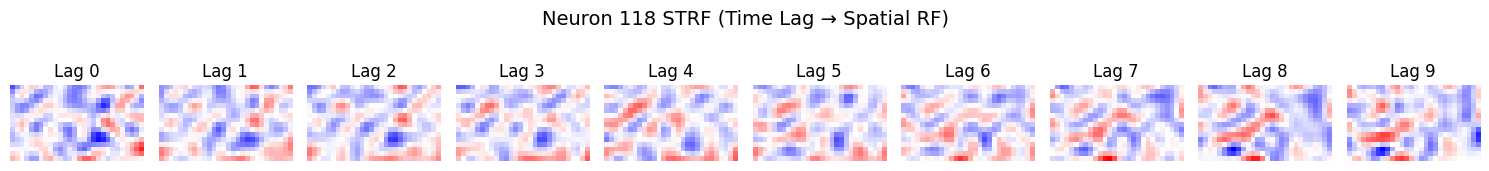

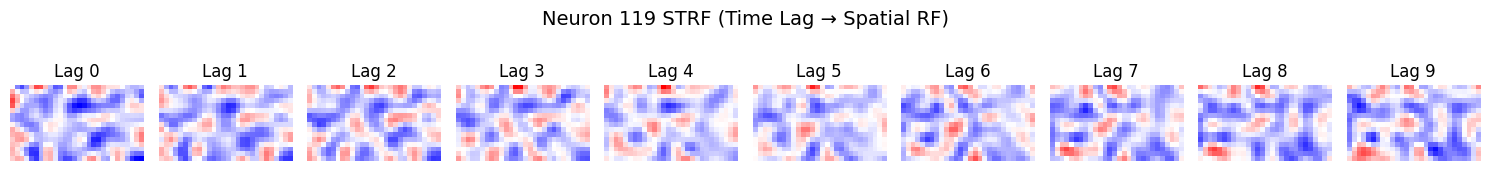

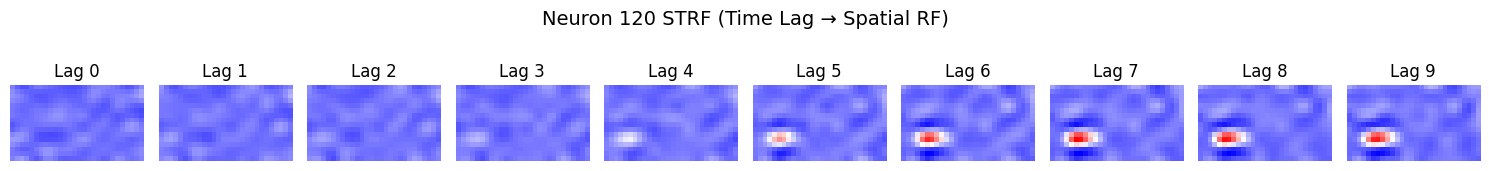

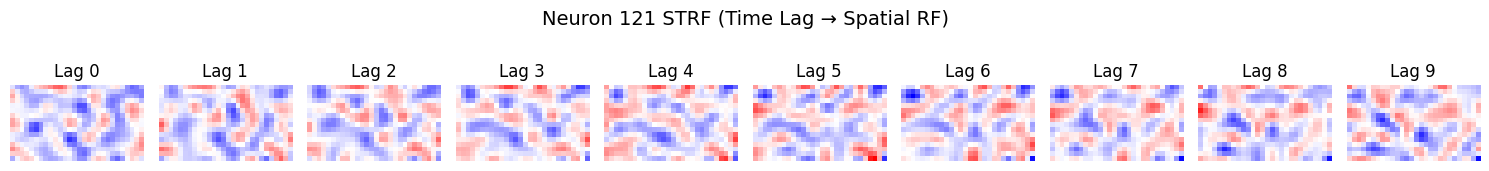

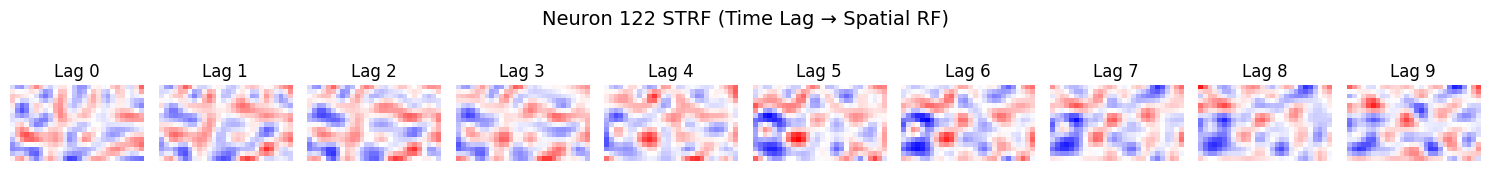

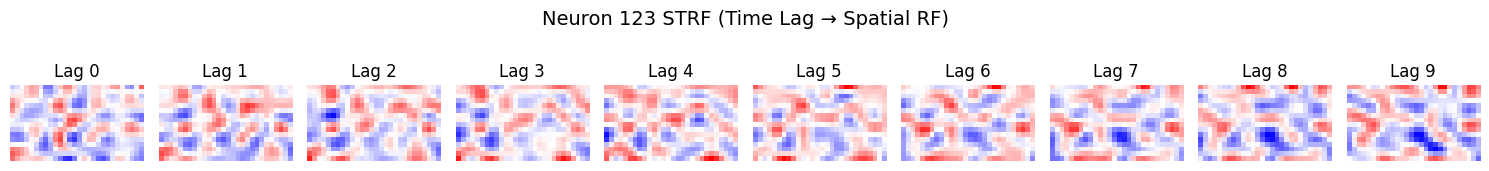

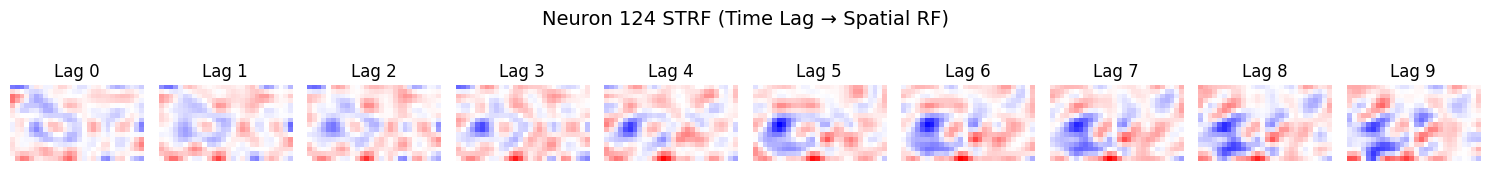

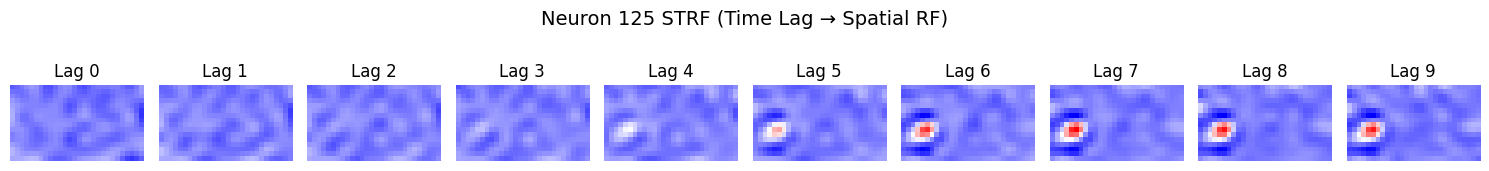

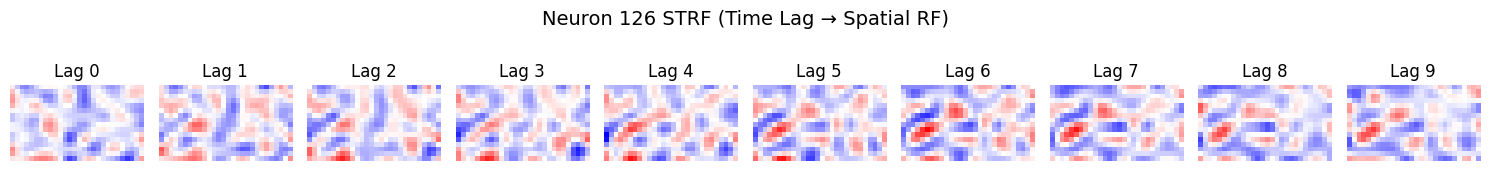

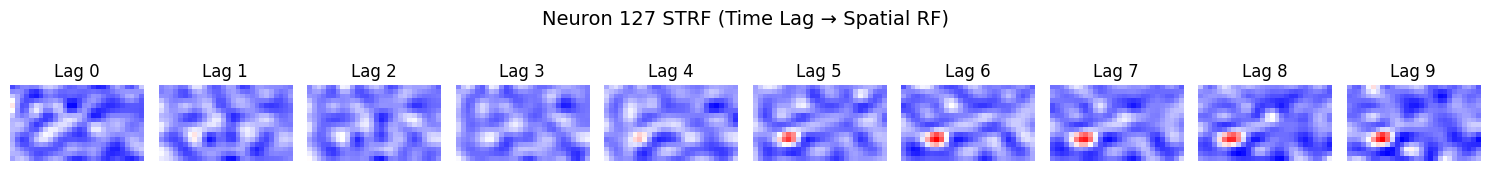

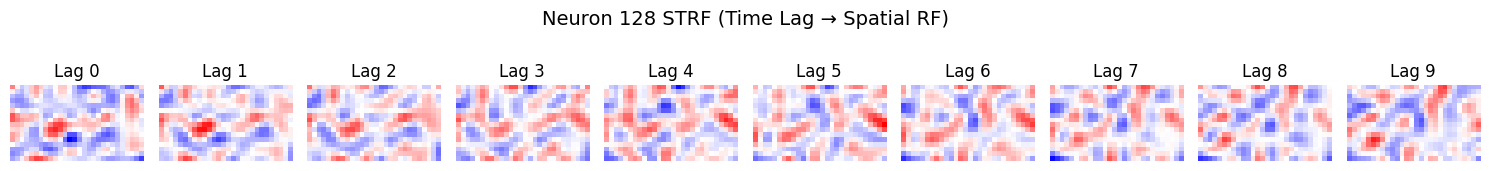

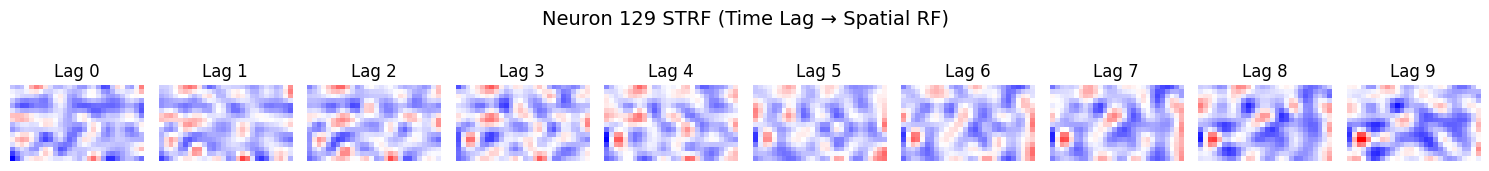

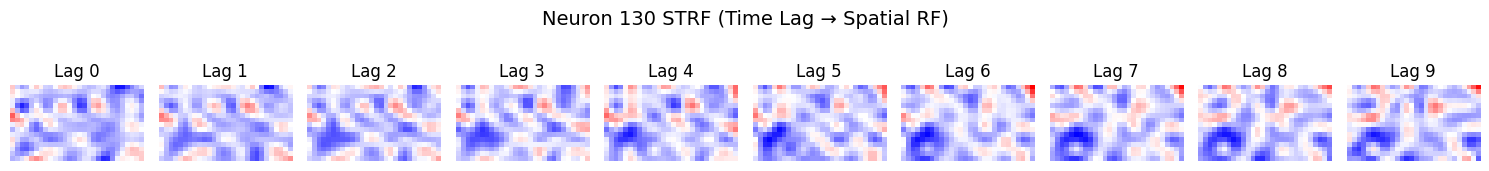

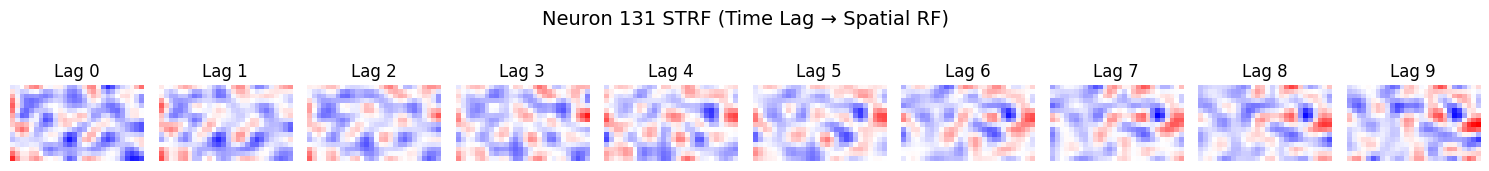

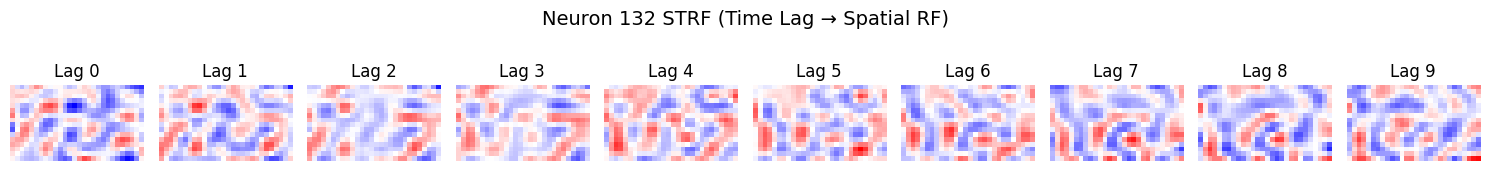

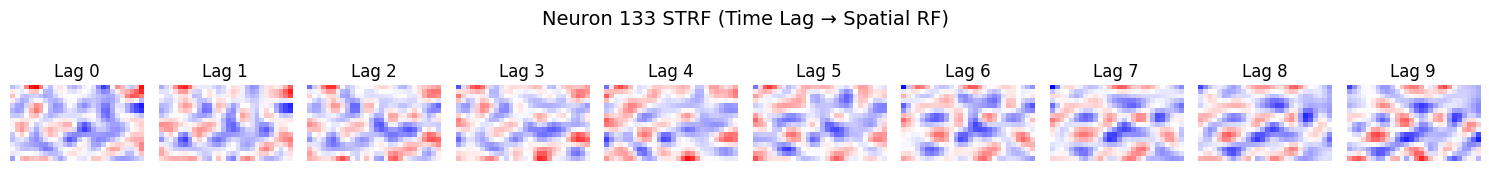

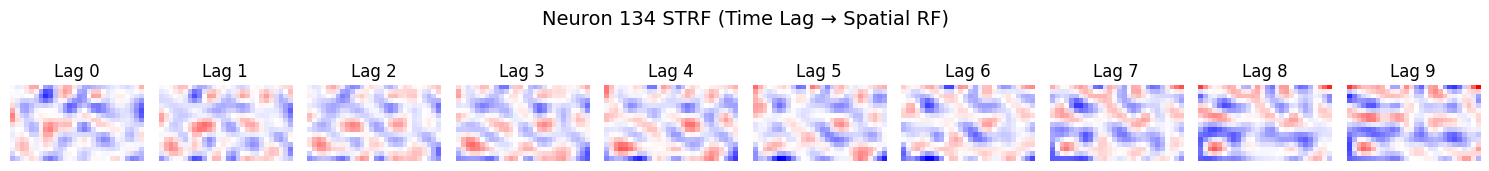

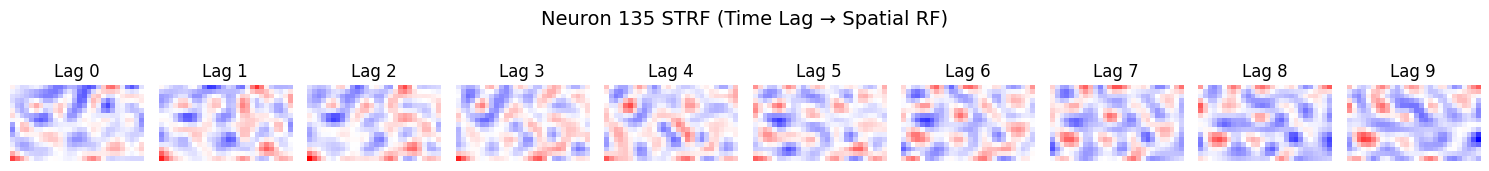

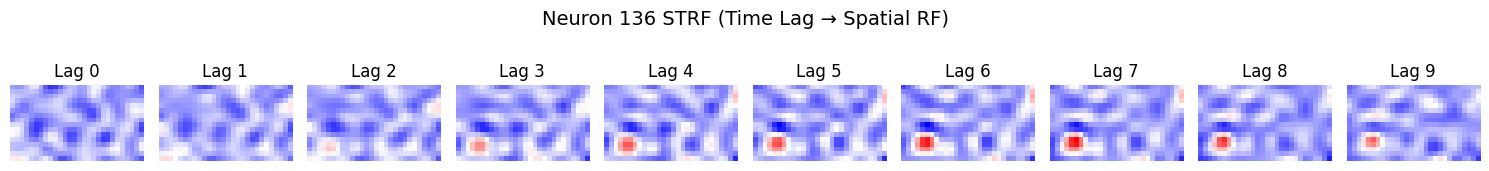

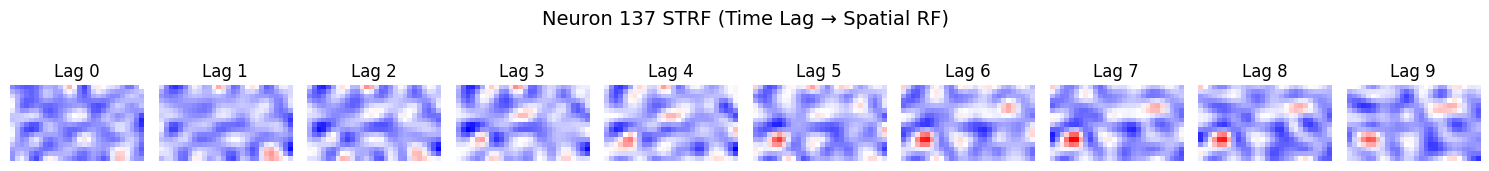

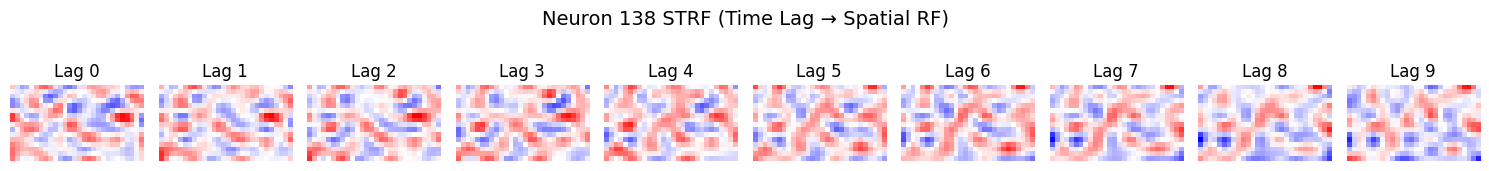

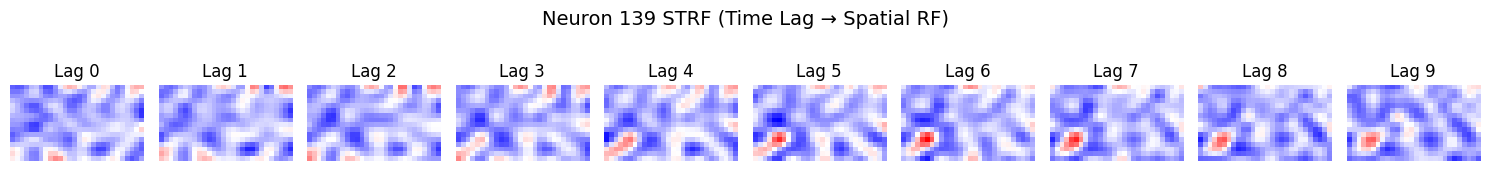

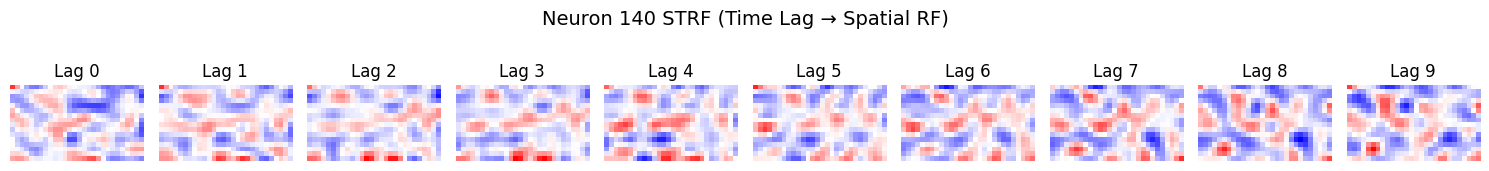

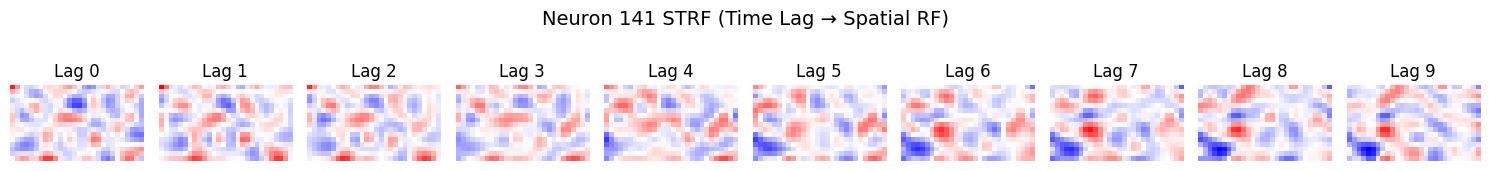

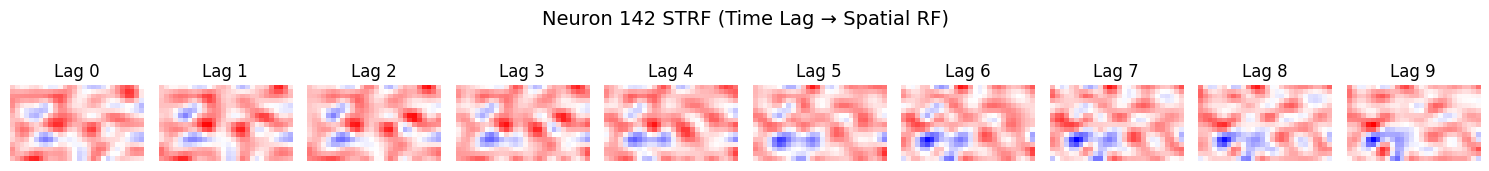

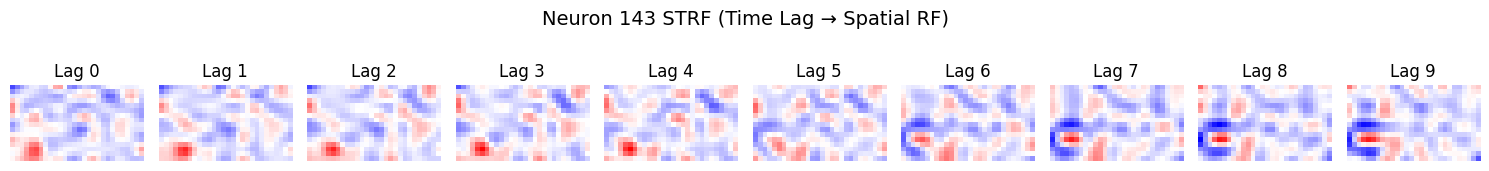

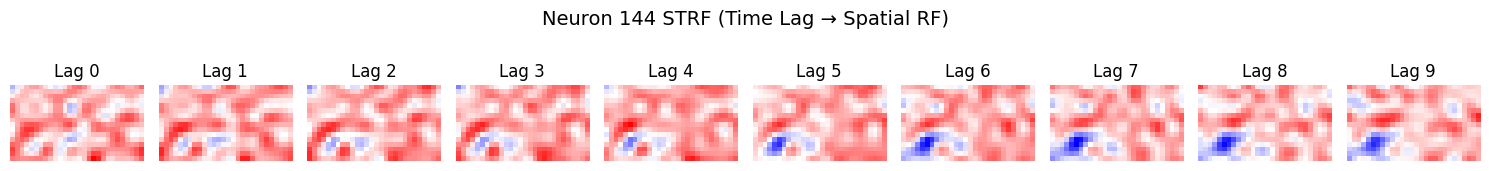

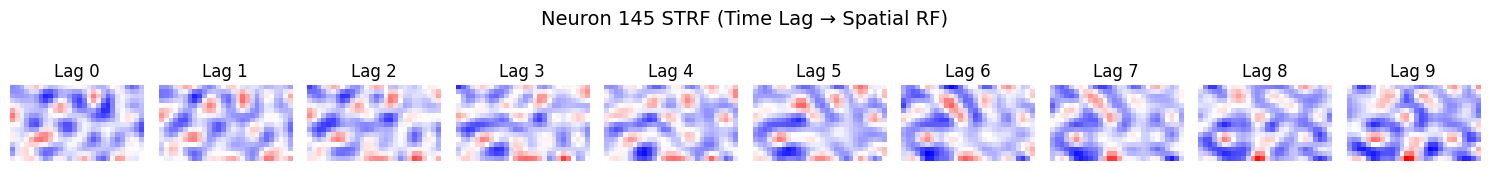

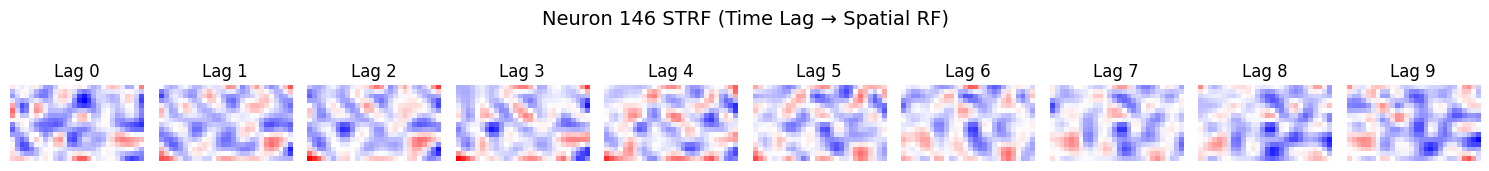

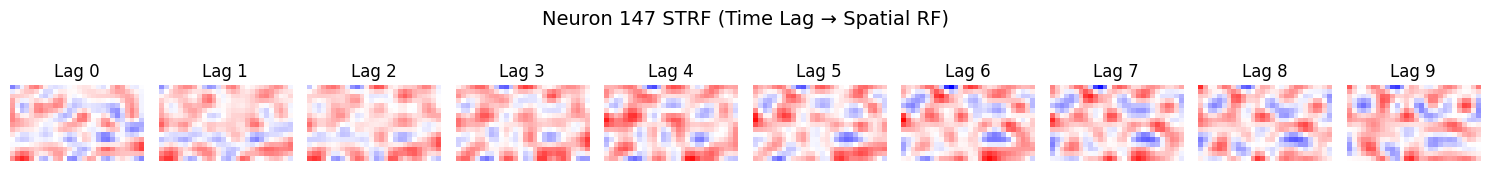

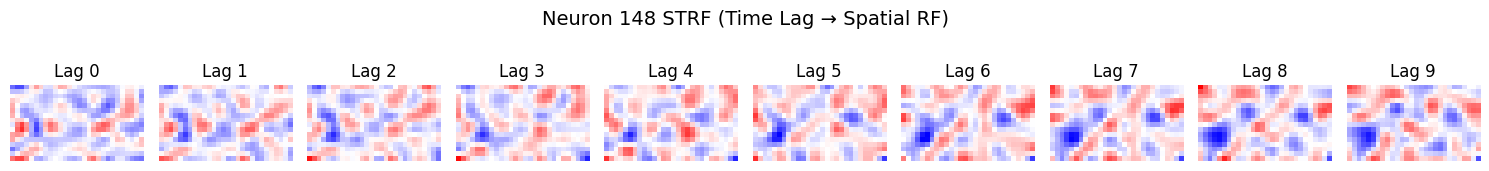

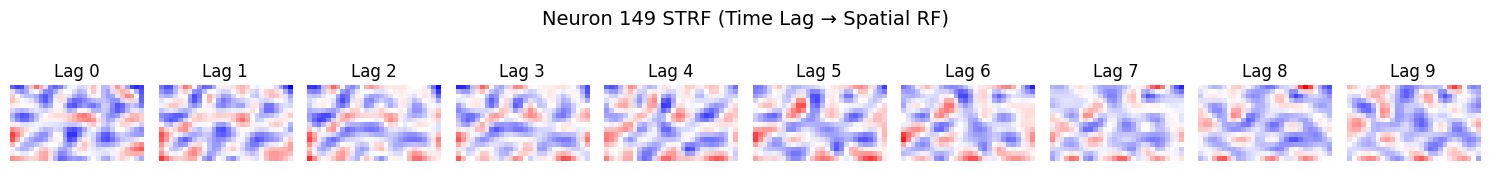

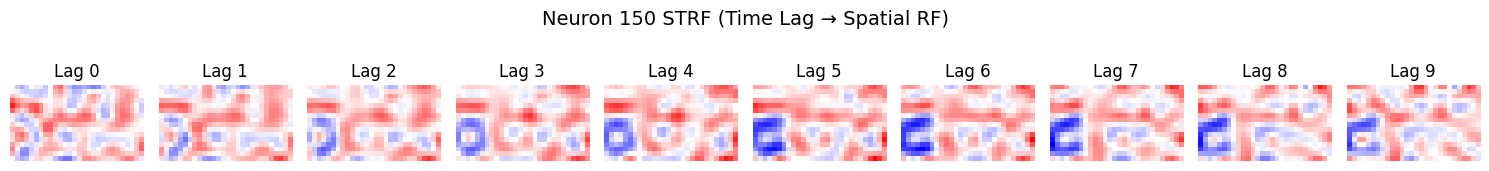

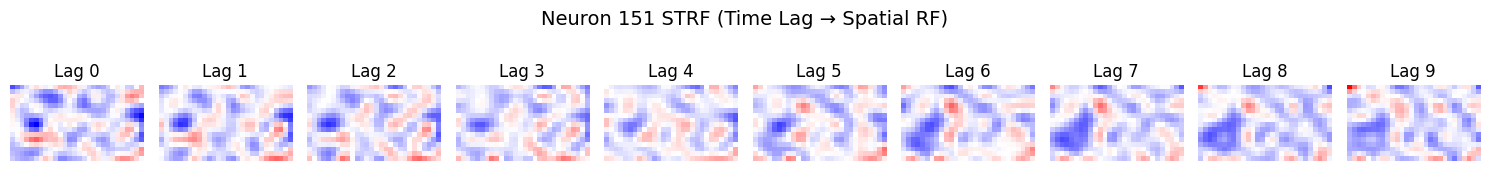

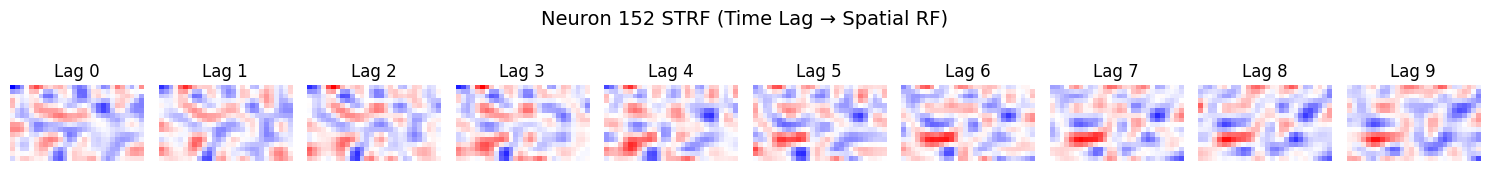

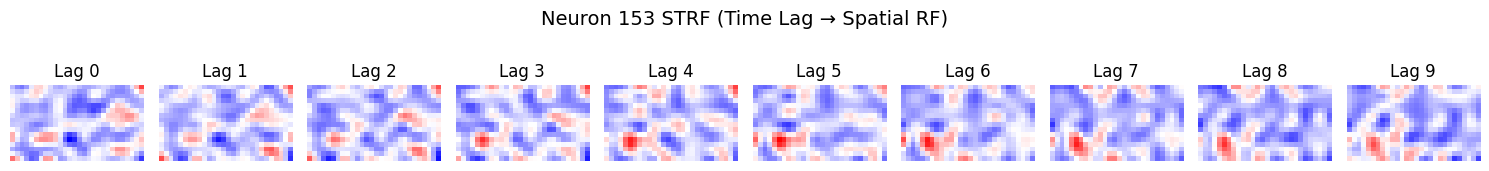

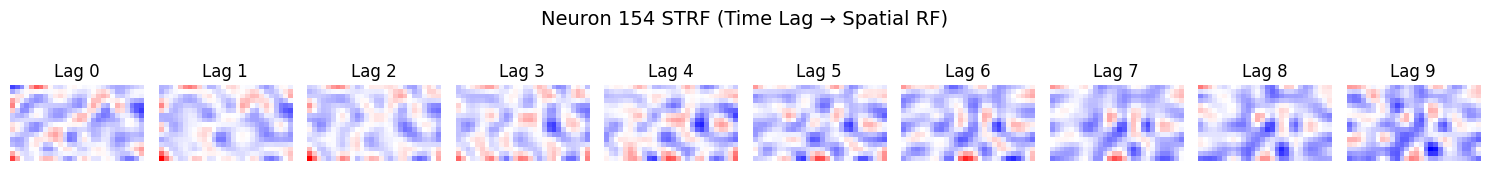

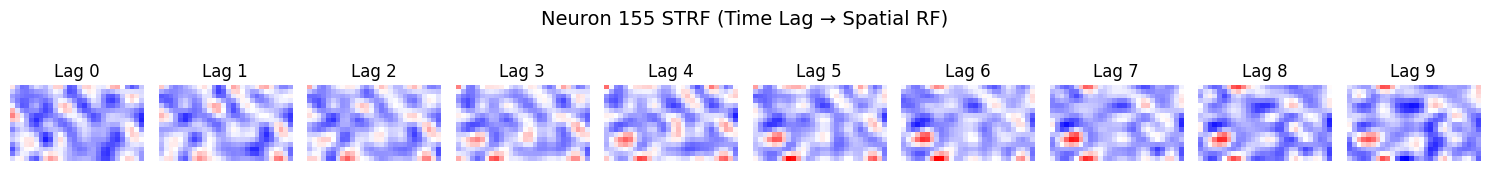

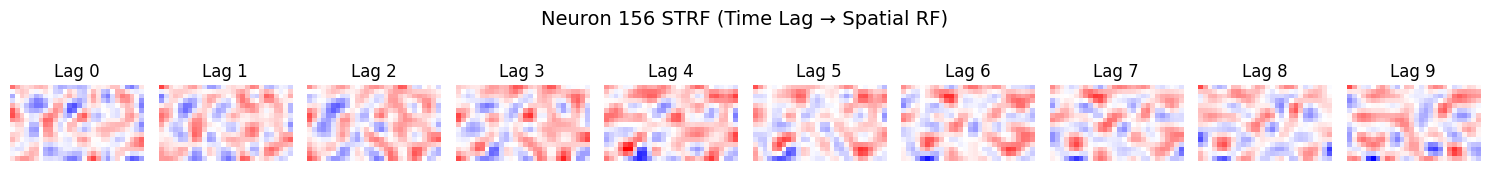

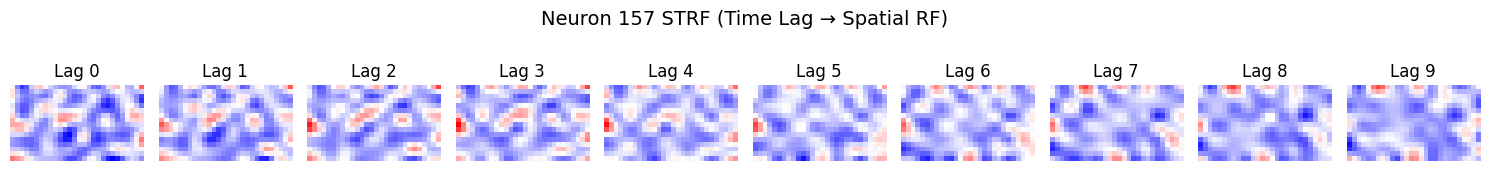

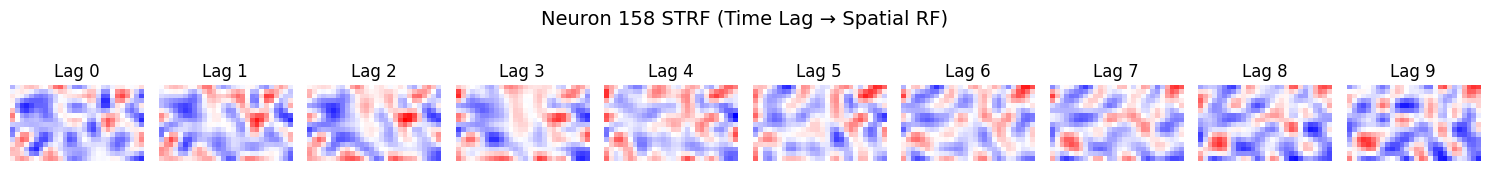

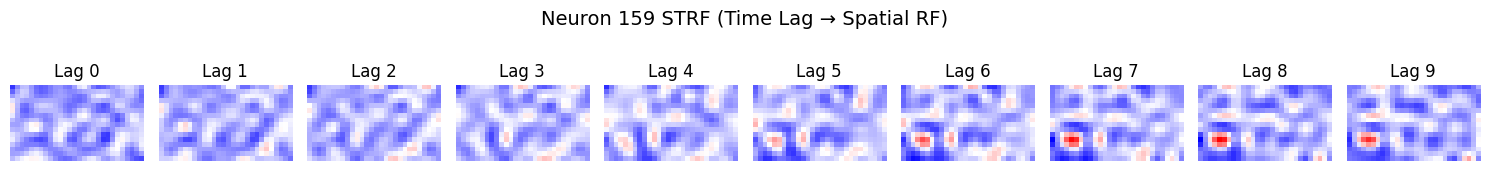

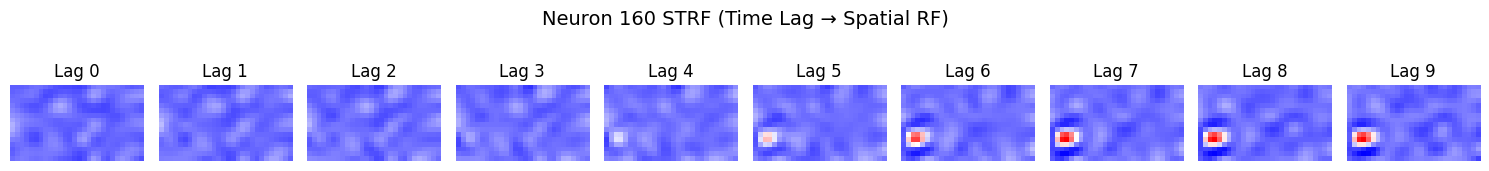

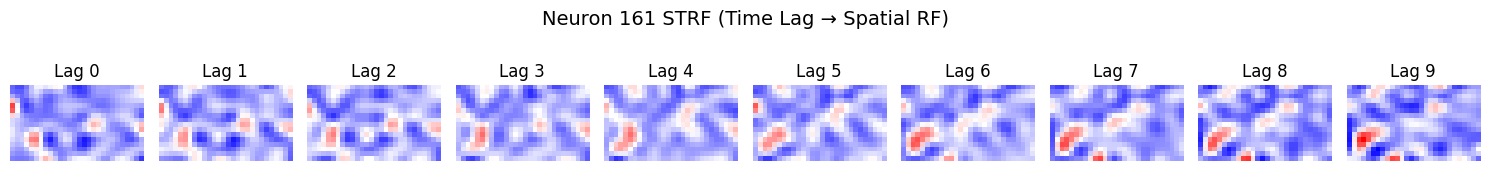

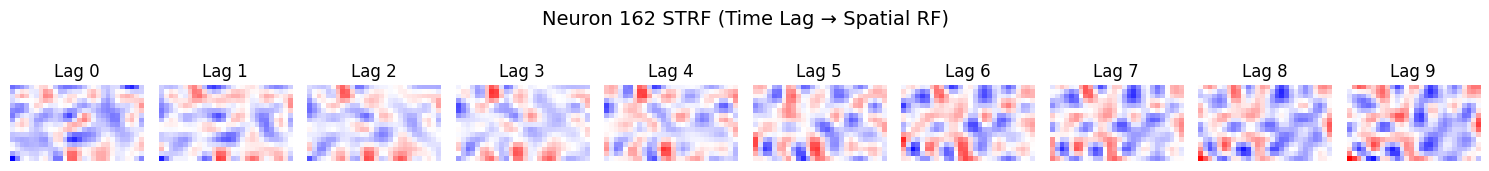

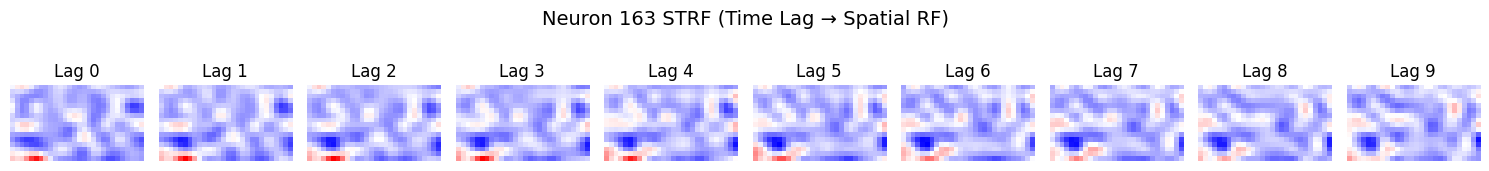

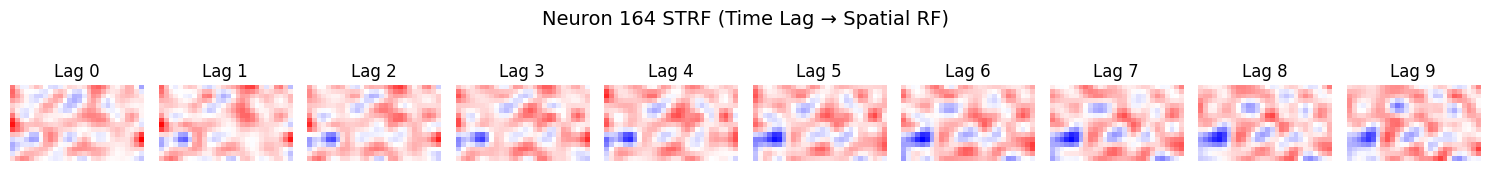

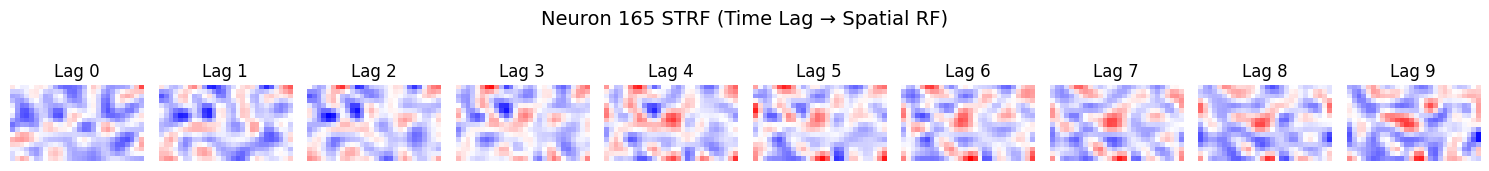

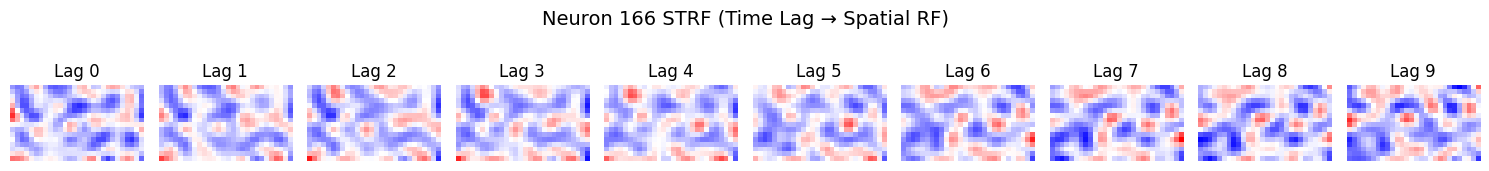

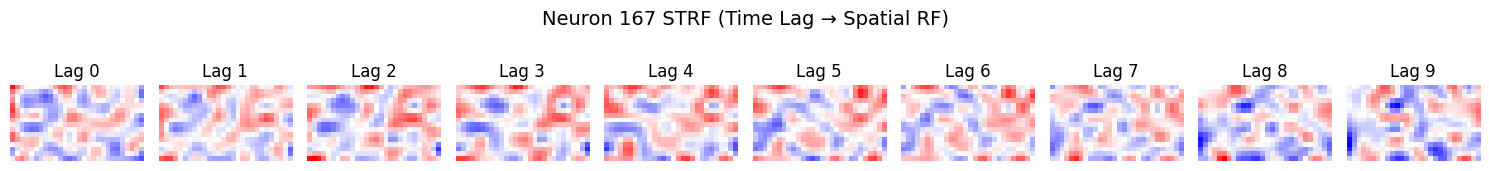

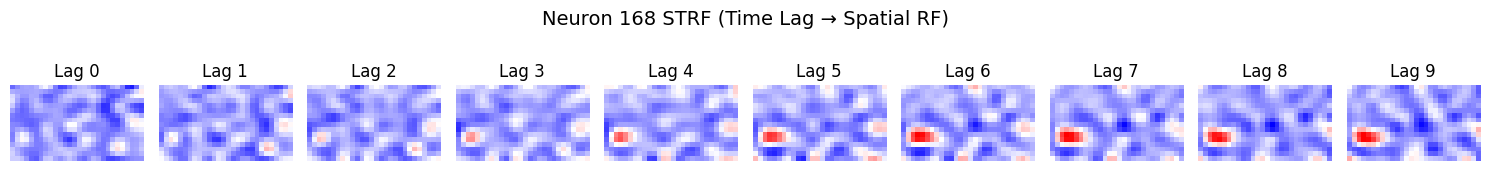

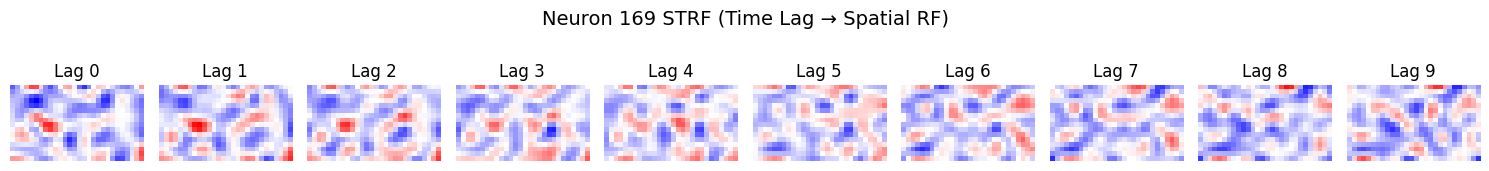

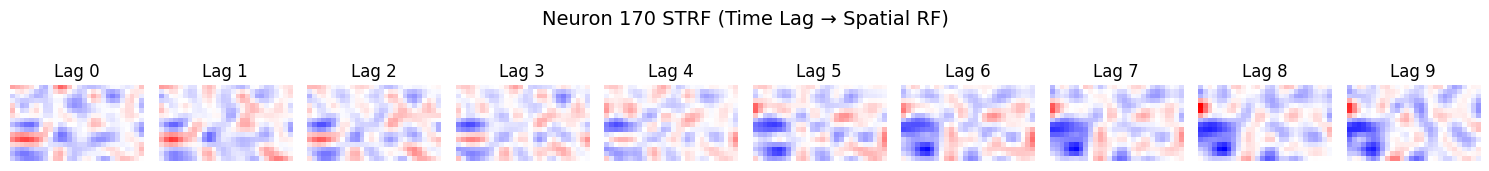

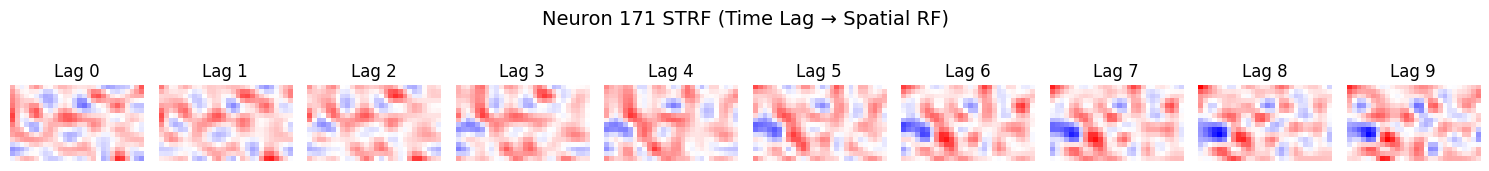

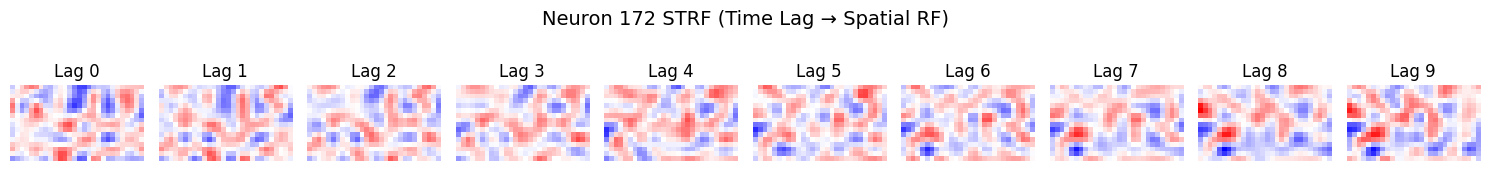

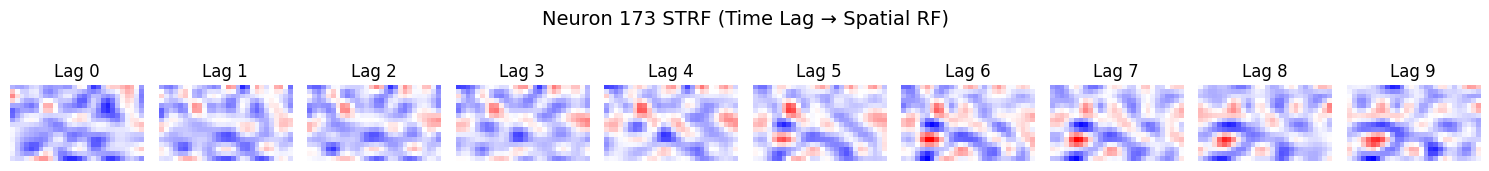

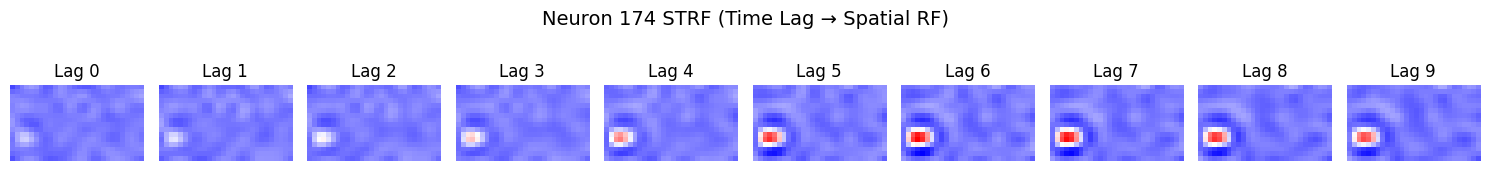

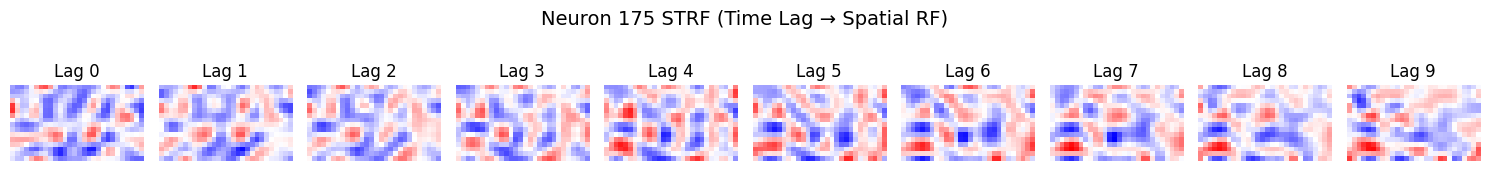

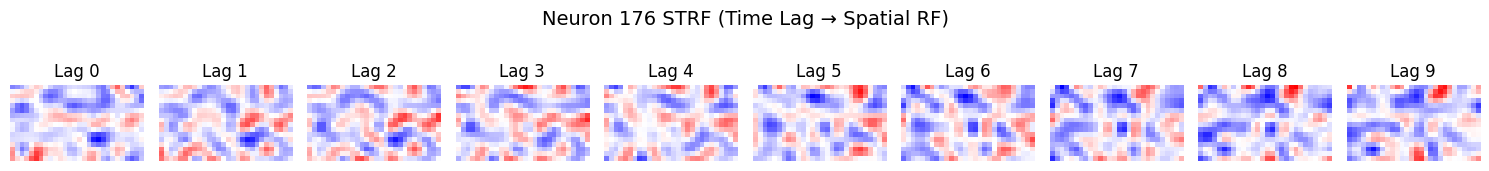

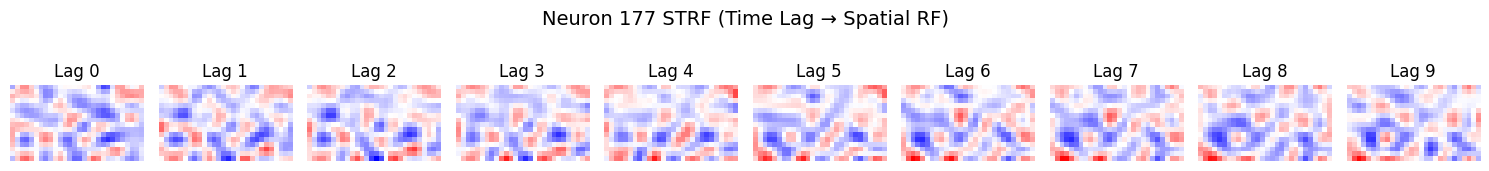

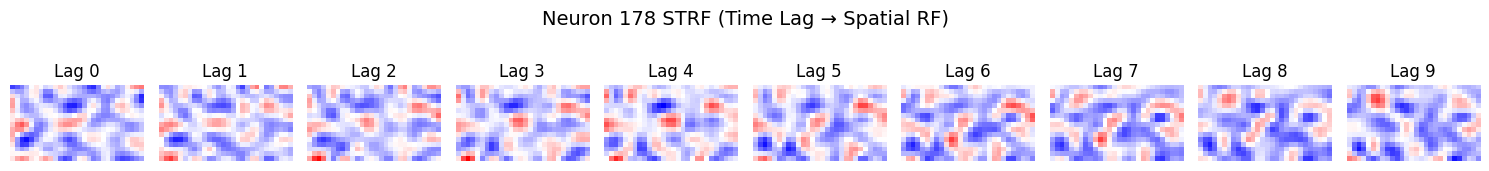

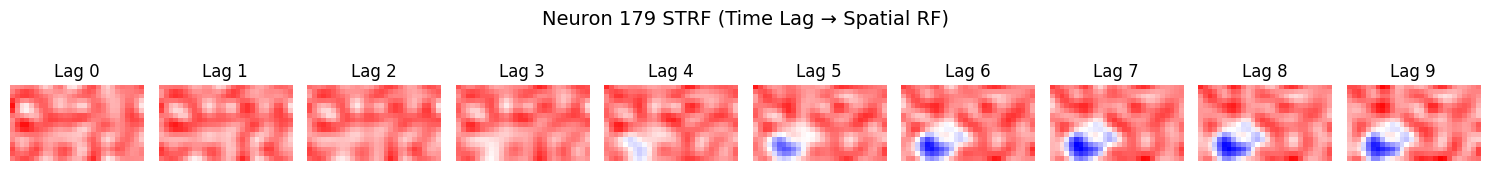

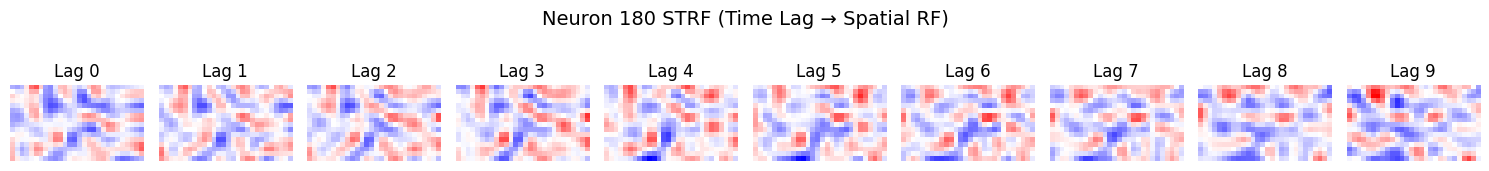

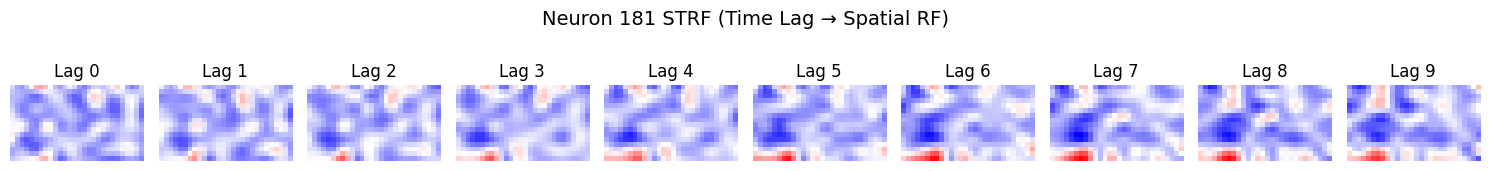

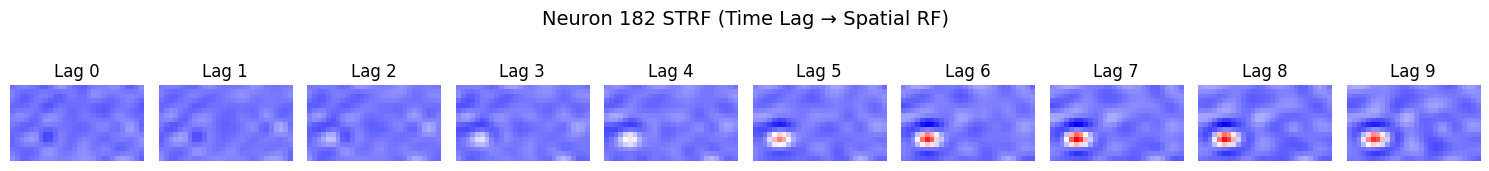

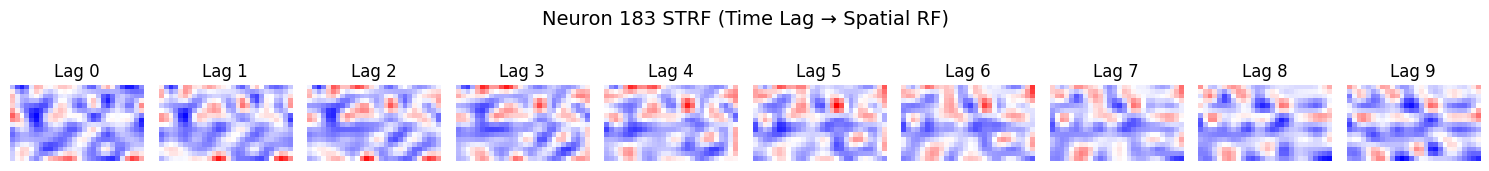

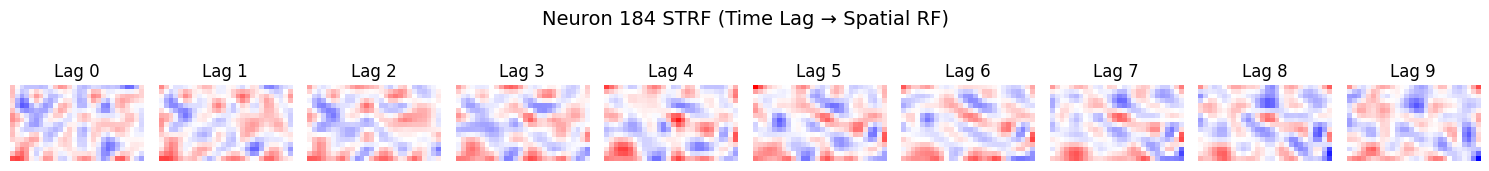

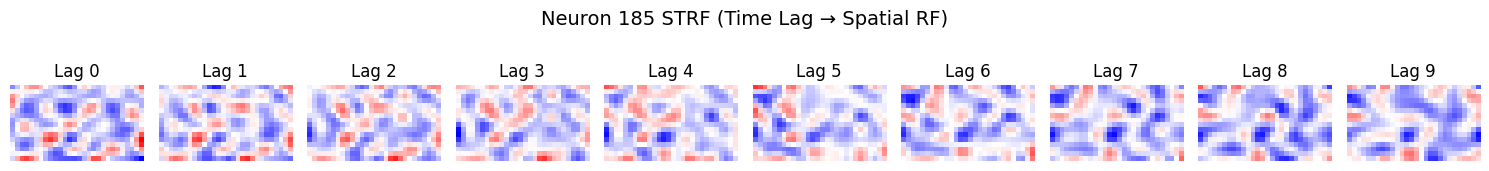

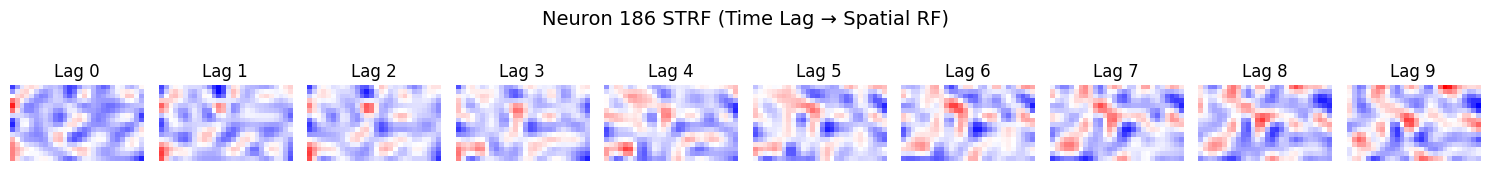

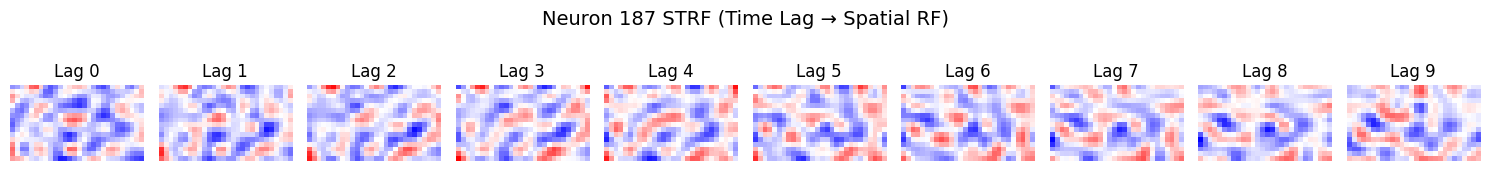

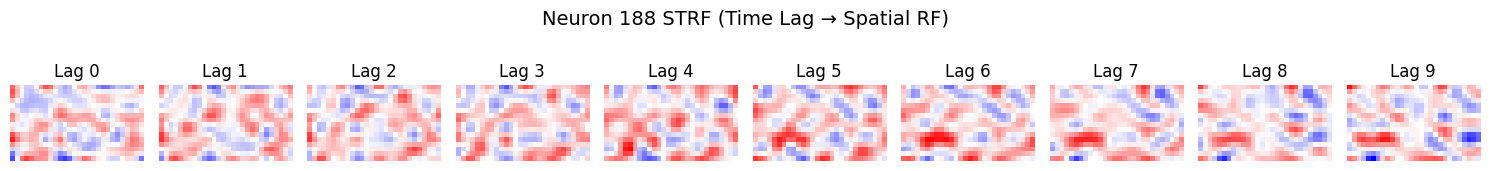

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Reuse dims and selected_neurons
num_lags, stim_h, stim_w = dims

for idx, w_flat in enumerate(w_est_spline_coeffs):
    neuron_idx = selected_neurons[idx]

    # Reshape to (time lags, height, width)
    strf = w_flat.reshape(dims)

    # Plot all lags
    fig, axes = plt.subplots(1, num_lags, figsize=(num_lags * 1.5, 2))
    fig.suptitle(f"Neuron {neuron_idx} STRF (Time Lag → Spatial RF)", fontsize=14)

    # Normalize color scale across all lags for fair comparison
    vmin, vmax = strf.min(), strf.max()
    for t in range(num_lags):
        ax = axes[t]
        ax.imshow(strf[t], cmap="bwr", vmin=vmin, vmax=vmax)
        ax.set_title(f"Lag {t}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()